# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import pygmt

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing


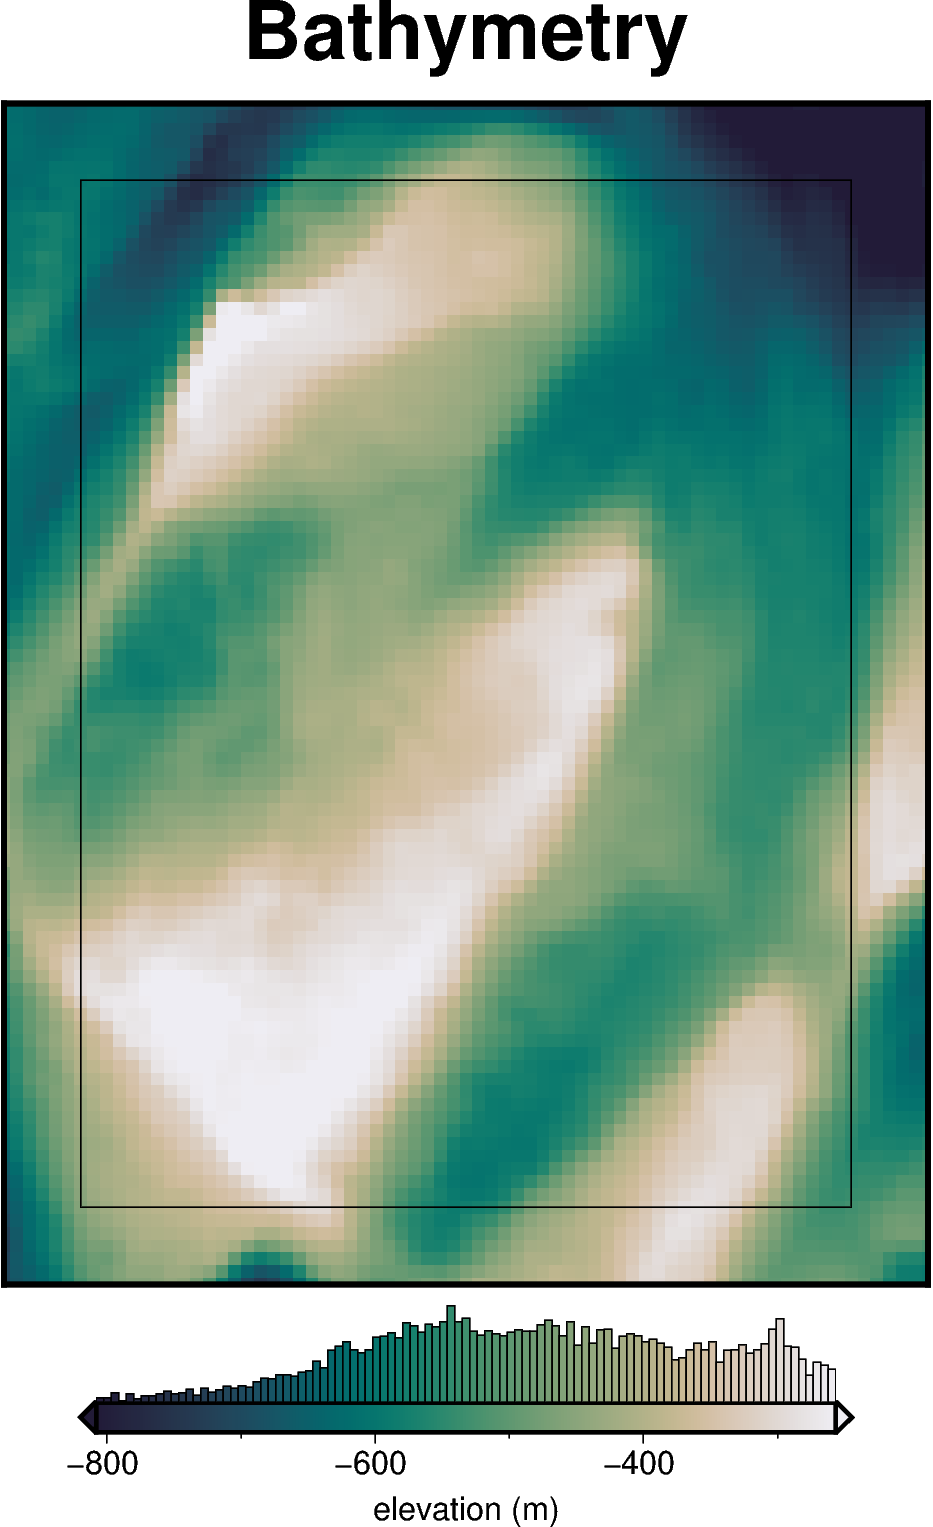

  0%|          | 0/4941 [00:00<?, ?it/s]

INFO:invert4geom:Standard deviation used for noise: [0.1]


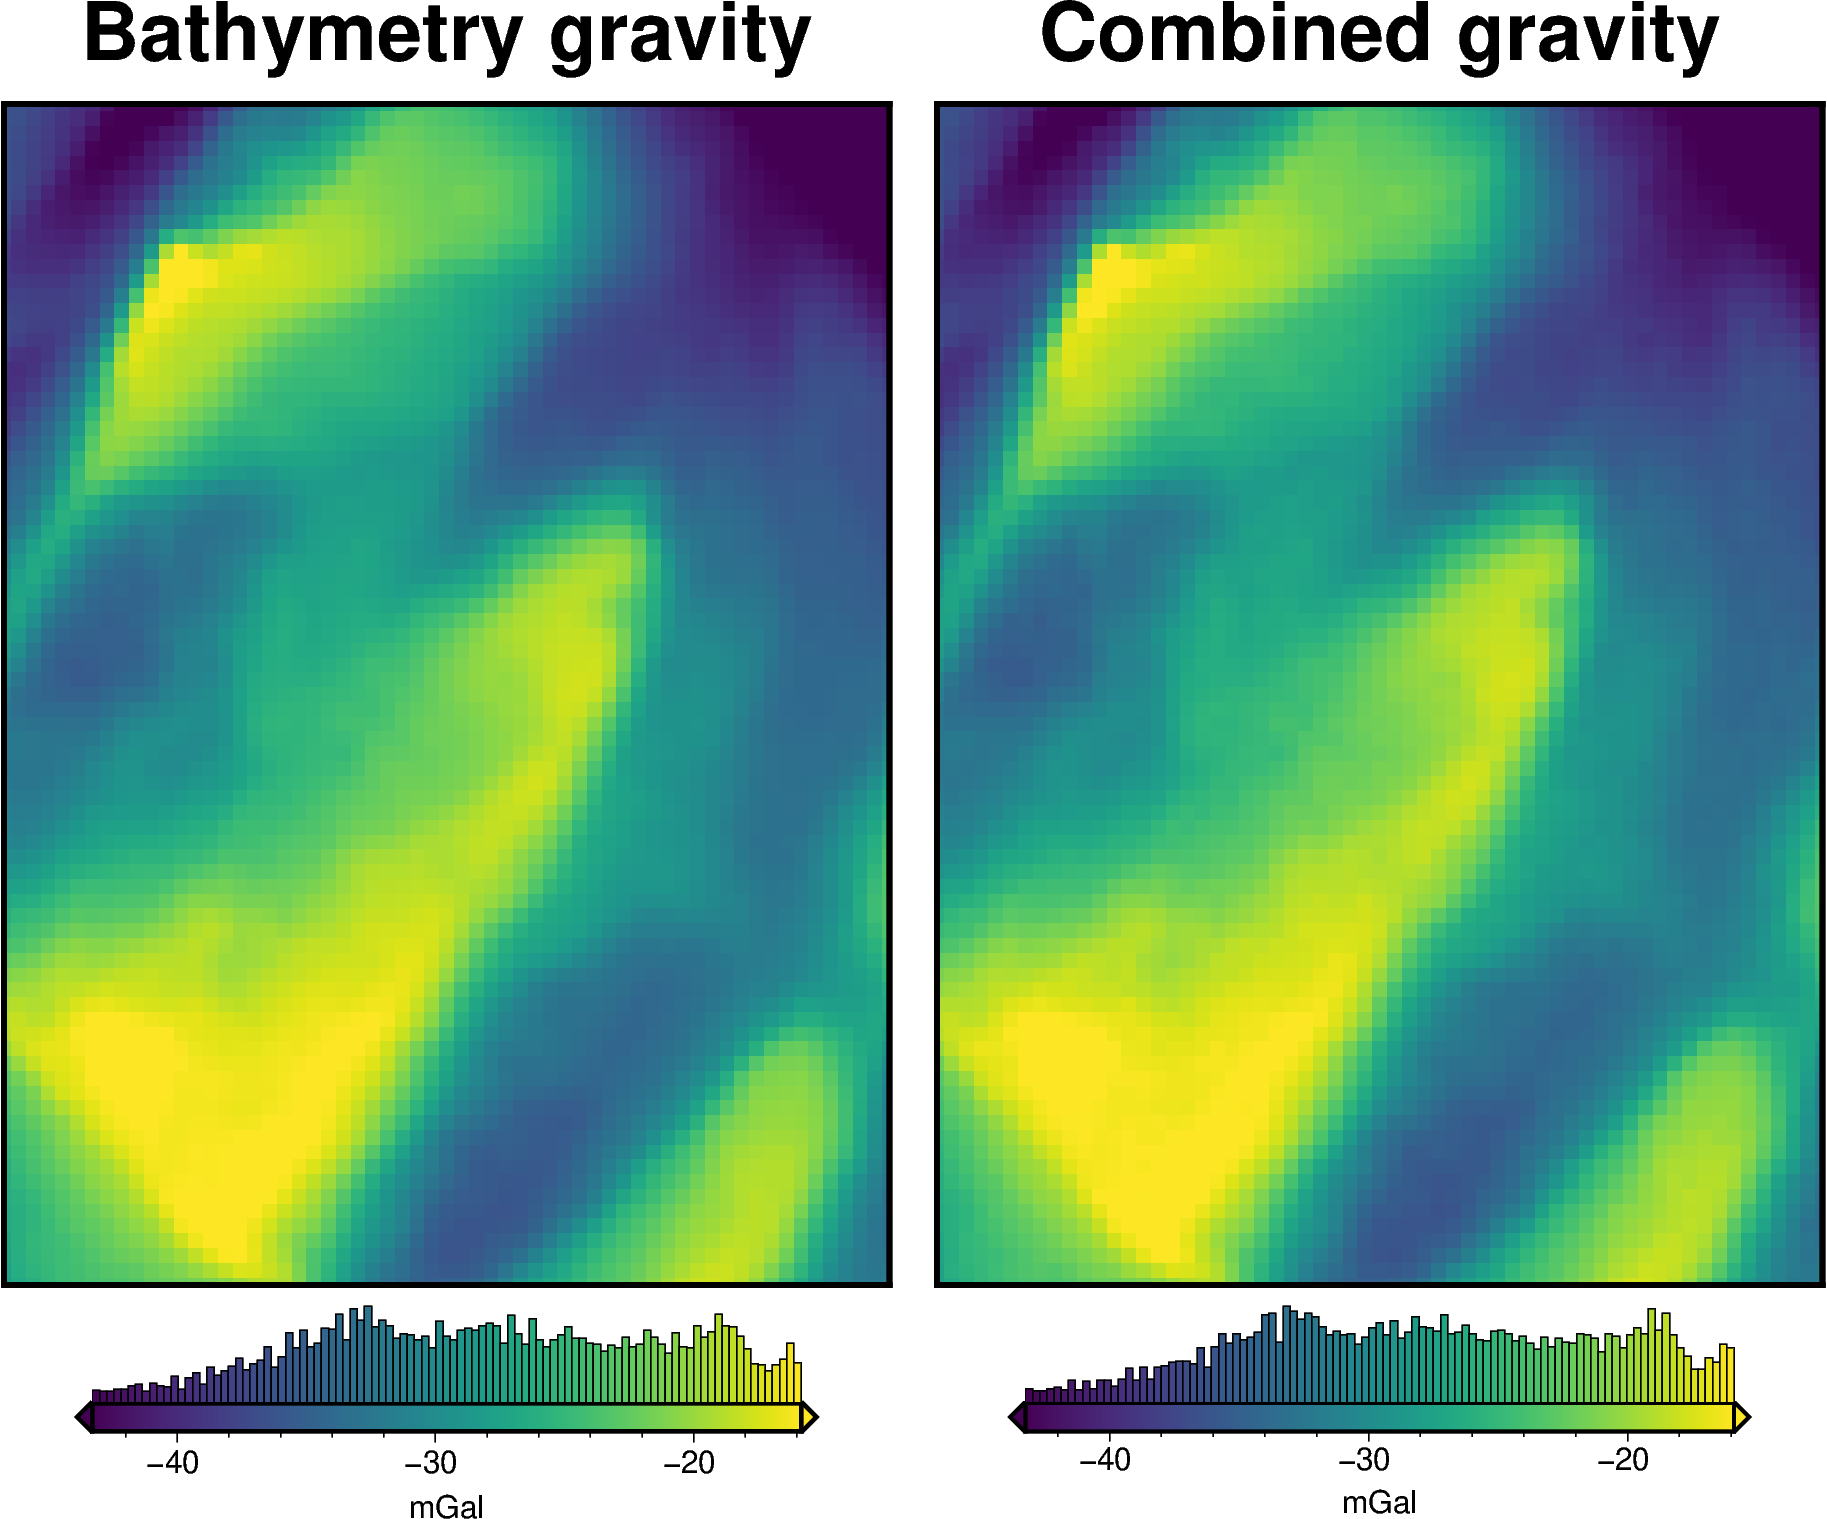

In [3]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=5e3,
    buffer=spacing*6,
    gravity_noise=0.1,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [4]:
grav_df

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.040826              0   
1    -1800000.0  -35000.0  1000.0       -26.709299              0   
2    -1800000.0  -30000.0  1000.0       -25.914227              0   
3    -1800000.0  -25000.0  1000.0       -25.232045              0   
4    -1800000.0  -20000.0  1000.0       -24.606135              0   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.314171              0   
4937 -1400000.0  245000.0  1000.0       -48.346713              0   
4938 -1400000.0  250000.0  1000.0       -49.069446              0   
4939 -1400000.0  255000.0  1000.0       -49.867457              0   
4940 -1400000.0  260000.0  1000.0       -50.824624              0   

      disturbance  uncert  gravity_anomaly  
0      -28.027666     0.1       -28.027666  
1      -26.721922     0.1       -26.721922  
2      -25.849598     0.1       -25.849598  
3      -25.220967     0.1       -25.220967  
4      -24.659114     0.1       -24.659114  
...           ...     ...              ...  
4936   -48.138121     0.1       -48.138121  
4937   -48.444430     0.1       -48.444430  
4938   -48.925229     0.1       -48.925229  
4939   -50.019481     0.1       -50.019481  
4940   -50.877246     0.1       -50.877246  

[4941 rows x 8 columns]

# Make starting bathymetry model

In [5]:
num_constraints = 25

# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    num_constraints=num_constraints,
    shift_stdev=10e3,
    region=inversion_region,
    padding=-4*spacing,
)

# # randomly spaced constraints
# coords = vd.scatter_points(
#     region=vd.pad_region(
#     inversion_region, -2*spacing),
#     size=num_constraints,
#     random_state=1,
# )
# constraint_points = pd.DataFrame(
#     data={"easting": coords[0], "northing": coords[1]},
# )

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

northing        easting  true_upward      upward
2  -1.773596e+06  108407.749901  -582.853672 -582.853672
28 -1.424577e+06  163158.820332  -514.862631 -514.862631
13 -1.638188e+06  182813.114007  -466.116978 -466.116978
10 -1.642233e+06  -32590.655321  -523.126791 -523.126791
26 -1.427435e+06   49298.636948  -417.558562 -417.558562

In [6]:
# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 5% of depth
uncert = np.abs(0.05 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

northing        easting  true_upward      upward     uncert    weight
2  -1.773596e+06  108407.749901  -582.853672 -579.189556  29.142684  0.001177
28 -1.424577e+06  163158.820332  -514.862631 -518.263424  25.743132  0.001509
13 -1.638188e+06  182813.114007  -466.116978 -451.191384  23.305849  0.001841
10 -1.642233e+06  -32590.655321  -523.126791 -520.382988  26.156340  0.001462
26 -1.427435e+06   49298.636948  -417.558562 -428.742229  20.877928  0.002294

In [7]:
# grid the sampled values using verde
starting_bathymetry = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-40, 0, 50),
    weights=constraint_points.weight,
)
# starting_bathymetry = utils.create_topography(
#     method="flat",
#     upwards=bathymetry.values.mean(),
#     region=buffer_region,
#     spacing=spacing,
# )
starting_bathymetry

INFO:invert4geom:Best SplineCV score: -4.45603530788647
INFO:invert4geom:Best damping: 4.7148663634573897e-17


<xarray.DataArray 'scalars' (northing: 93, easting: 73)> Size: 54kB
array([[-147.18375341, -146.40094921, -145.99950166, ..., -366.03865753,
        -358.3829488 , -351.06991213],
       [-150.08826062, -149.03733782, -148.36144115, ..., -368.0580063 ,
        -360.34822716, -352.99876952],
       [-153.24238613, -151.9177251 , -150.96071056, ..., -369.94937504,
        -362.19920808, -354.82586163],
       ...,
       [-810.18275338, -800.53200963, -790.56279177, ..., -857.8634427 ,
        -861.28148208, -864.32787484],
       [-814.06327927, -804.32154644, -794.26165122, ..., -863.05057602,
        -866.81034008, -870.17346349],
       [-817.98646578, -808.16541418, -798.02940031, ..., -867.94532606,
        -872.03593304, -875.71054453]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06
Attributes:
    metadata:  Generated by SplineCV(dampings=array([1.00000000e-40, 6.551285...
    damping:   4.7148663634573897e-17

In [8]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 22.00 m


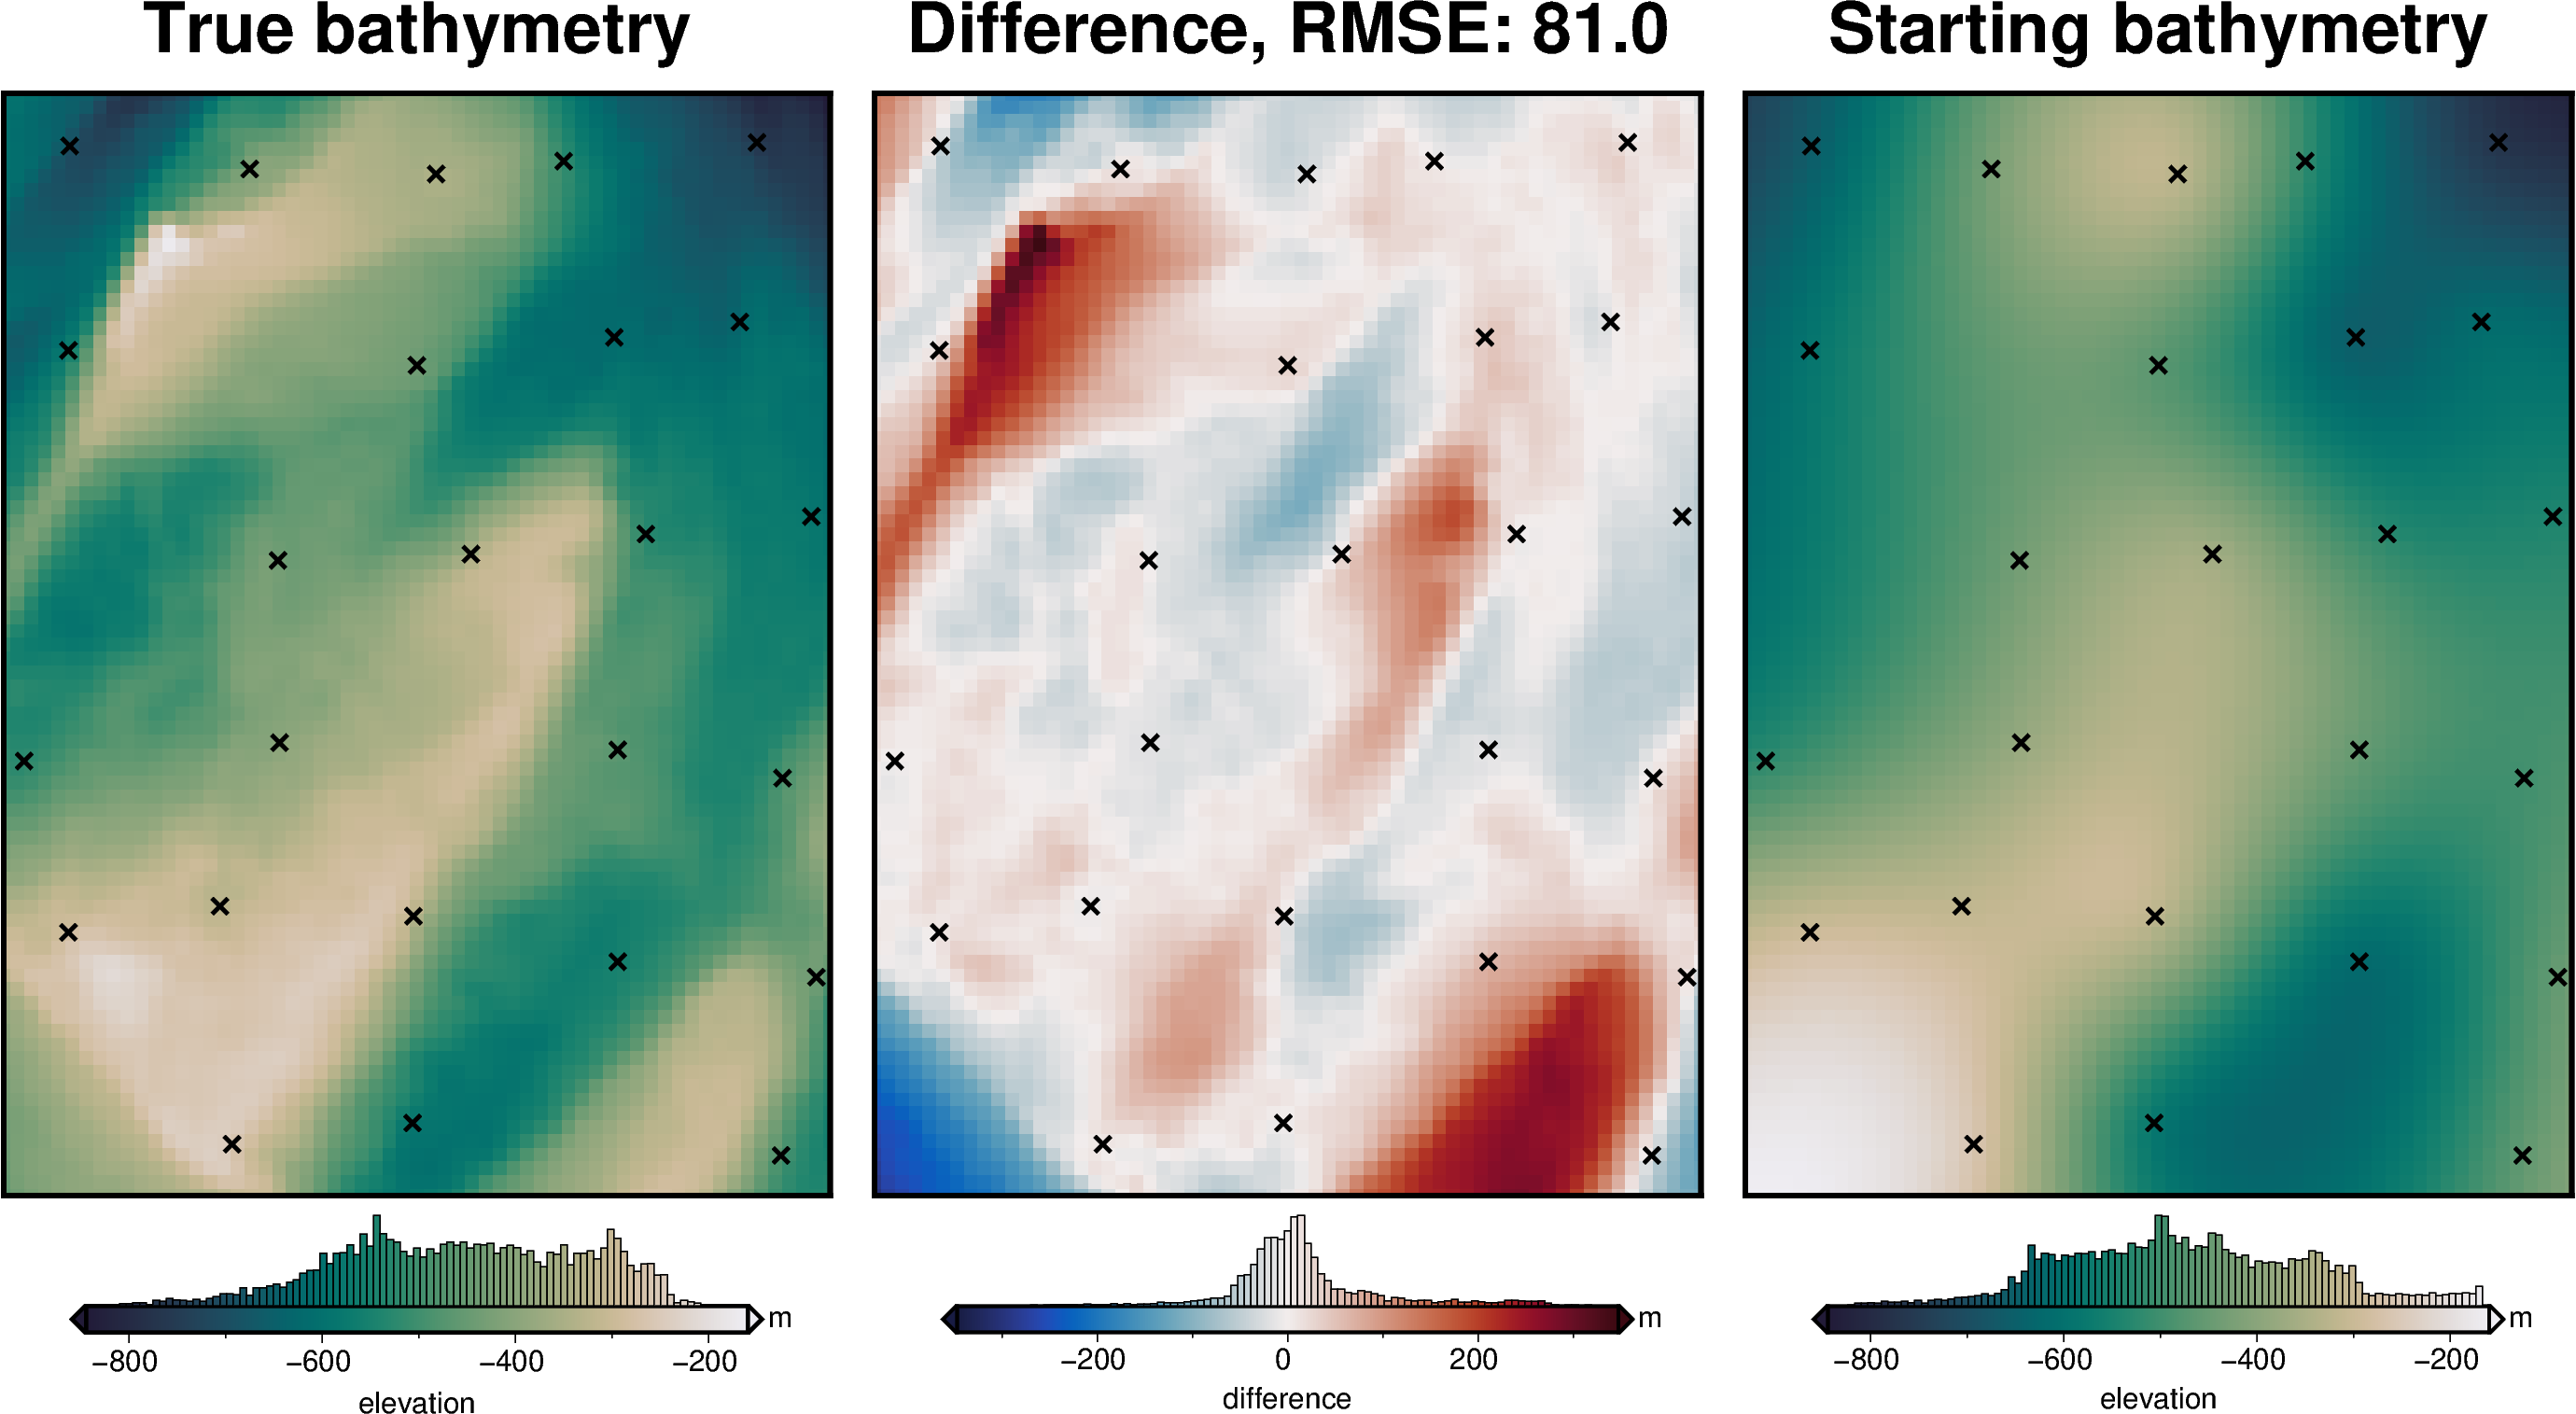

In [9]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [10]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.040826              0   
1    -1800000.0  -35000.0  1000.0       -26.709299              0   
2    -1800000.0  -30000.0  1000.0       -25.914227              0   
3    -1800000.0  -25000.0  1000.0       -25.232045              0   
4    -1800000.0  -20000.0  1000.0       -24.606135              0   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.314171              0   
4937 -1400000.0  245000.0  1000.0       -48.346713              0   
4938 -1400000.0  250000.0  1000.0       -49.069446              0   
4939 -1400000.0  255000.0  1000.0       -49.867457              0   
4940 -1400000.0  260000.0  1000.0       -50.824624              0   

      disturbance  uncert  gravity_anomaly  starting_gravity  
0      -28.027666     0.1       -28.027666         -9.816314  
1      -26.721922     0.1       -26.721922         -9.839073  
2      -25.849598     0.1       -25.849598         -9.892305  
3      -25.220967     0.1       -25.220967         -9.979860  
4      -24.659114     0.1       -24.659114        -10.105282  
...           ...     ...              ...               ...  
4936   -48.138121     0.1       -48.138121        -48.075607  
4937   -48.444430     0.1       -48.444430        -48.506904  
4938   -48.925229     0.1       -48.925229        -48.852233  
4939   -50.019481     0.1       -50.019481        -49.120923  
4940   -50.877246     0.1       -50.877246        -49.318085  

[4941 rows x 9 columns]

In [11]:
grav_df = regional.regional_separation(
    grav_df=grav_df,
    method="constant",
    constant=0,
)
grav_df

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1800000.0  -40000.0  1000.0       -28.040826              0   
1    -1800000.0  -35000.0  1000.0       -26.709299              0   
2    -1800000.0  -30000.0  1000.0       -25.914227              0   
3    -1800000.0  -25000.0  1000.0       -25.232045              0   
4    -1800000.0  -20000.0  1000.0       -24.606135              0   
...         ...       ...     ...              ...            ...   
4936 -1400000.0  240000.0  1000.0       -48.314171              0   
4937 -1400000.0  245000.0  1000.0       -48.346713              0   
4938 -1400000.0  250000.0  1000.0       -49.069446              0   
4939 -1400000.0  255000.0  1000.0       -49.867457              0   
4940 -1400000.0  260000.0  1000.0       -50.824624              0   

      disturbance  uncert  gravity_anomaly  starting_gravity     misfit  reg  \
0      -28.027666     0.1       -28.027666         -9.816314 -18.211352    0   
1      -26.721922     0.1       -26.721922         -9.839073 -16.882849    0   
2      -25.849598     0.1       -25.849598         -9.892305 -15.957293    0   
3      -25.220967     0.1       -25.220967         -9.979860 -15.241107    0   
4      -24.659114     0.1       -24.659114        -10.105282 -14.553833    0   
...           ...     ...              ...               ...        ...  ...   
4936   -48.138121     0.1       -48.138121        -48.075607  -0.062515    0   
4937   -48.444430     0.1       -48.444430        -48.506904   0.062474    0   
4938   -48.925229     0.1       -48.925229        -48.852233  -0.072997    0   
4939   -50.019481     0.1       -50.019481        -49.120923  -0.898558    0   
4940   -50.877246     0.1       -50.877246        -49.318085  -1.559161    0   

            res  
0    -18.211352  
1    -16.882849  
2    -15.957293  
3    -15.241107  
4    -14.553833  
...         ...  
4936  -0.062515  
4937   0.062474  
4938  -0.072997  
4939  -0.898558  
4940  -1.559161  

[4941 rows x 12 columns]

makecpt [ERROR]: Option T: min >= max


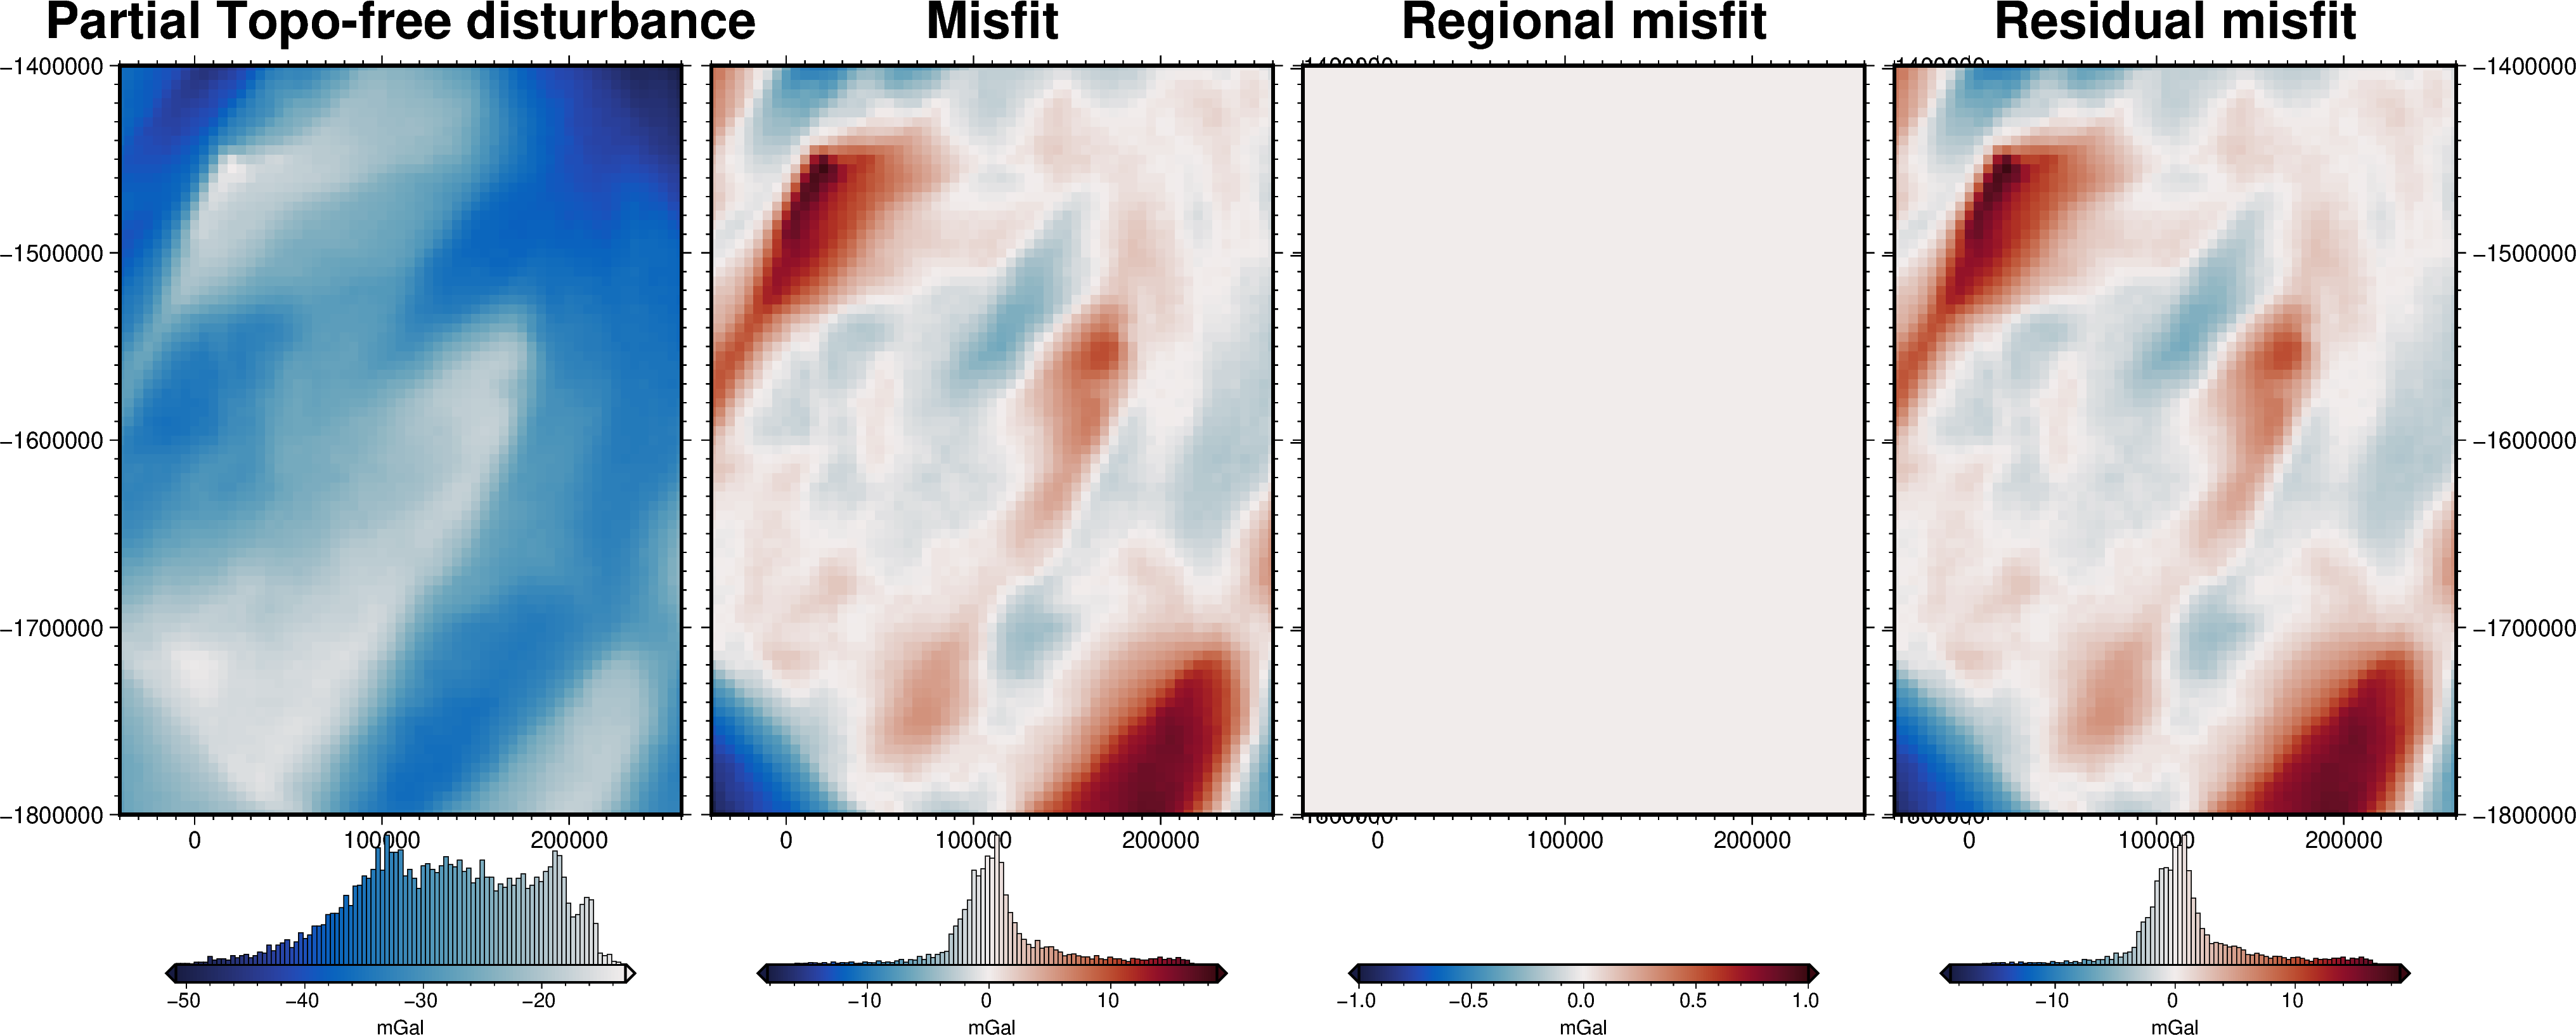

In [12]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)
fig.show()

# Run initial inversion
choose a damping value and use the inversion results to set appropriate stopping criteria.

In [35]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .1**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


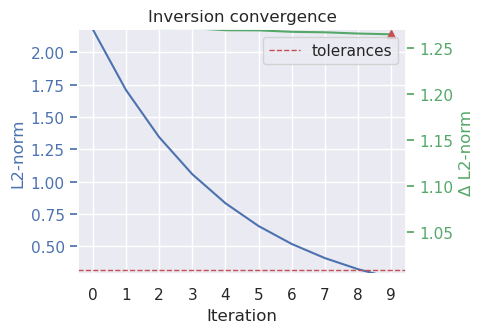

In [14]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    solver_damping=0.01,
    fname="../../results/Ross_Sea_no_regional",
    plot_dynamic_convergence=True,
    **kwargs,
)

In [15]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

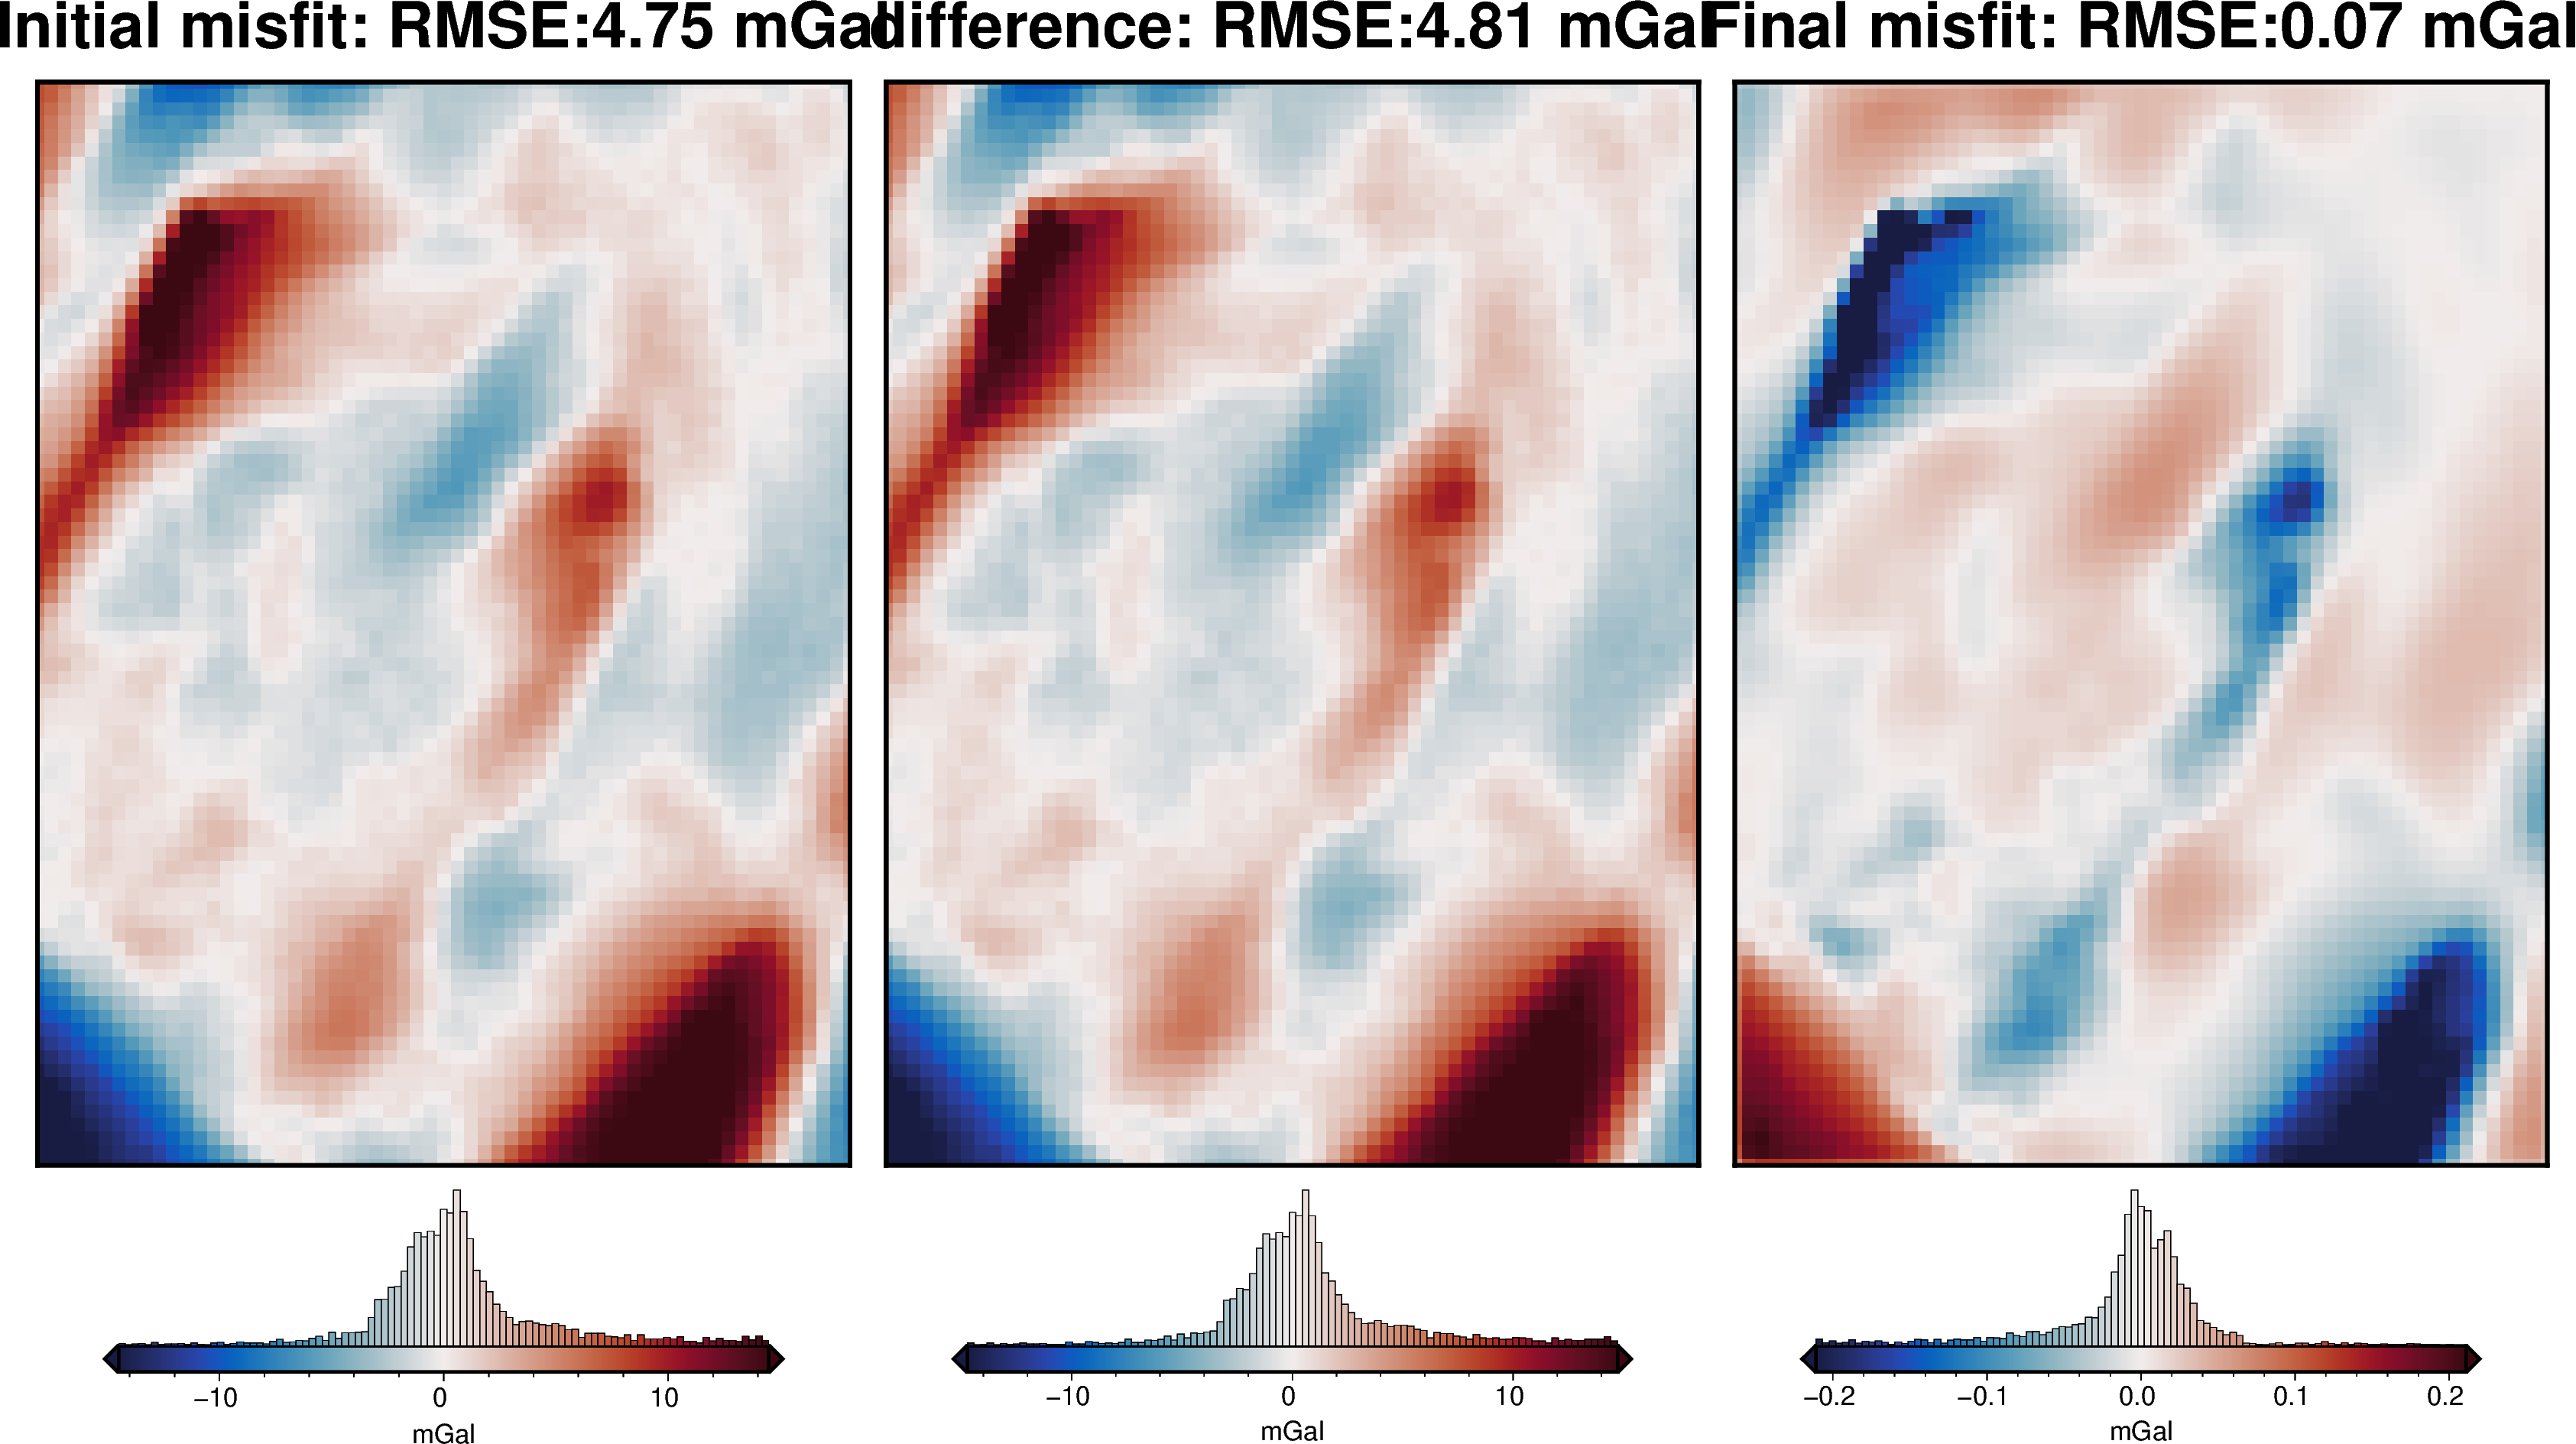

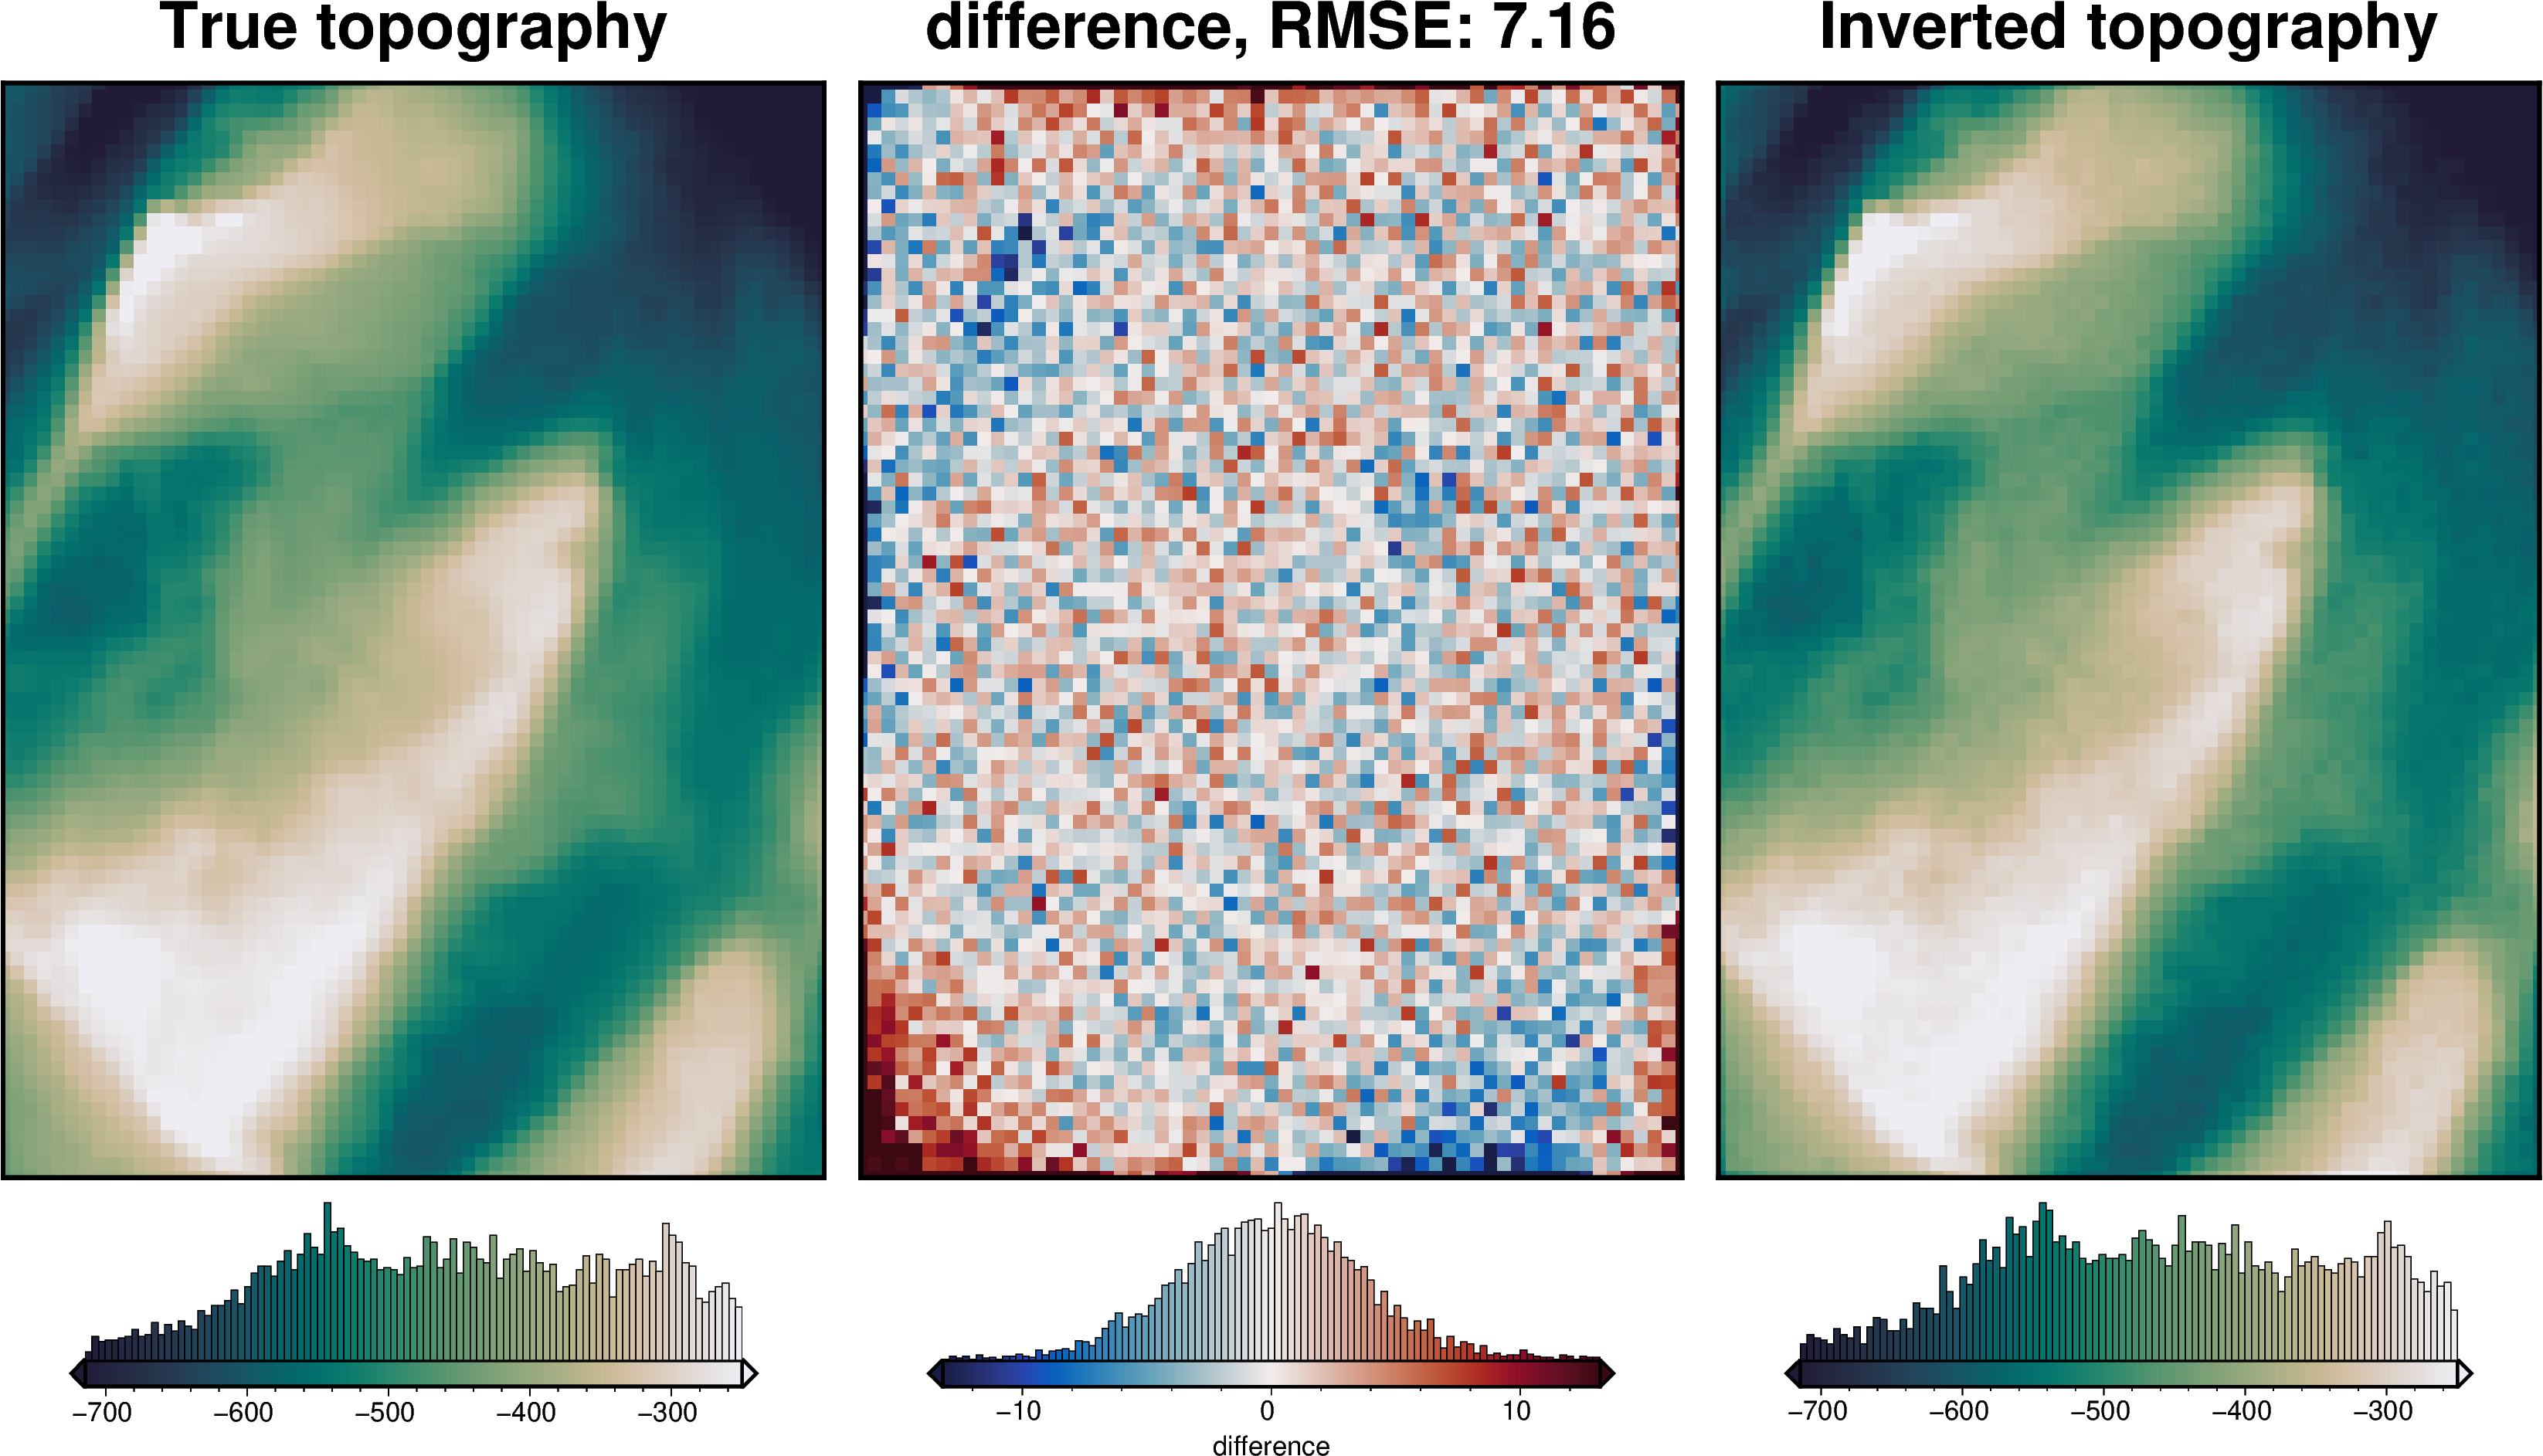

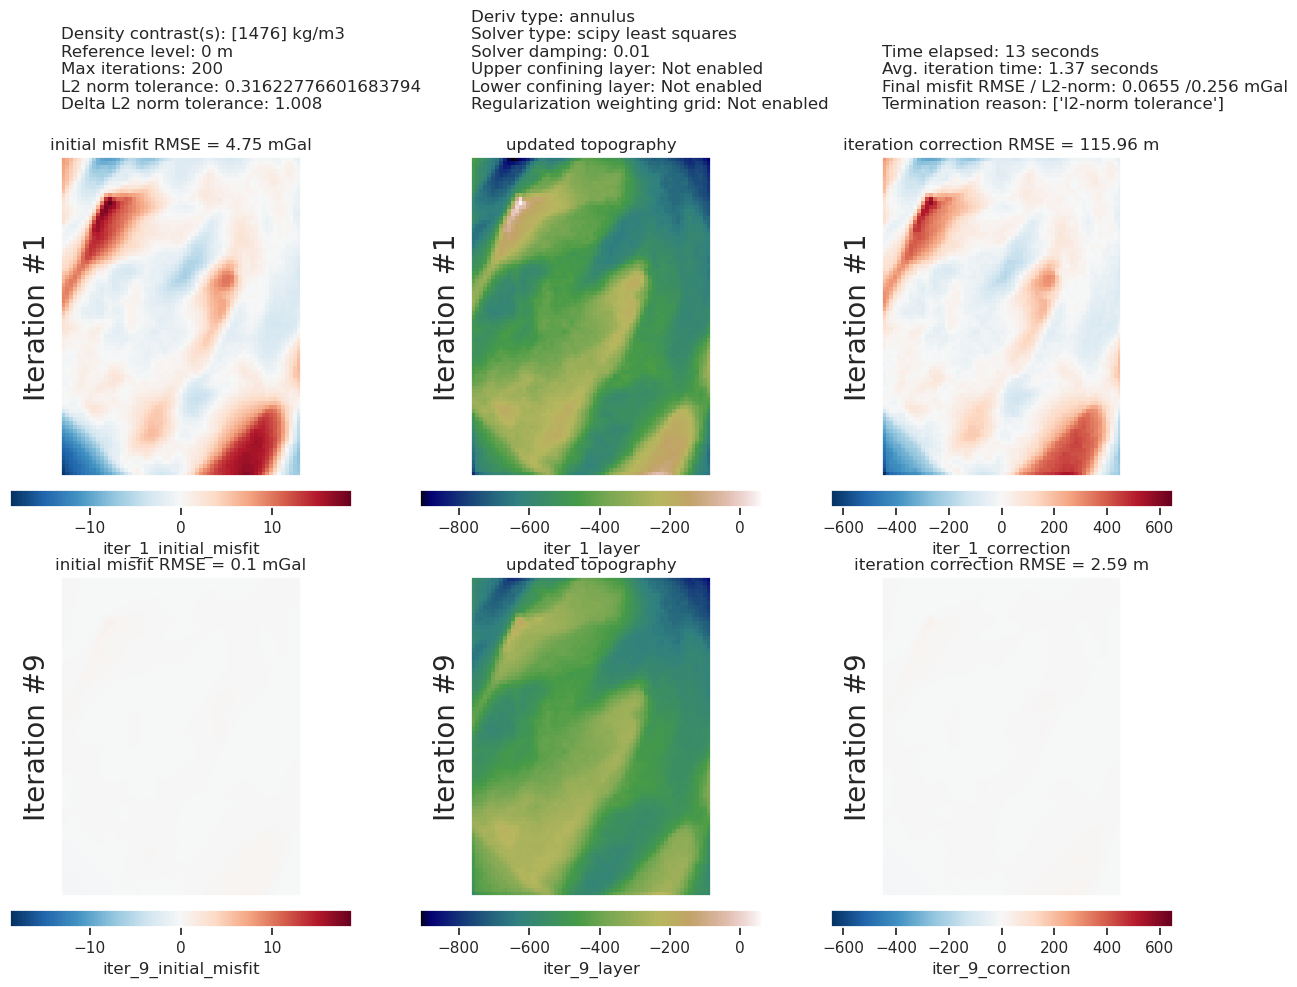

In [16]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    # plot_iter_results=False,
    plot_topo_results=False,
    # plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

# Damping Cross Validation

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_no_regional_with_starting_damping_cv'
INFO:invert4geom:running damping cross validation


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.05109412690255546}
INFO:invert4geom:	scores: [0.07060138514809627]
INFO:invert4geom:results saved to ../../results/Ross_Sea_no_regional_with_starting_damping_cv_results.pickle.pickle


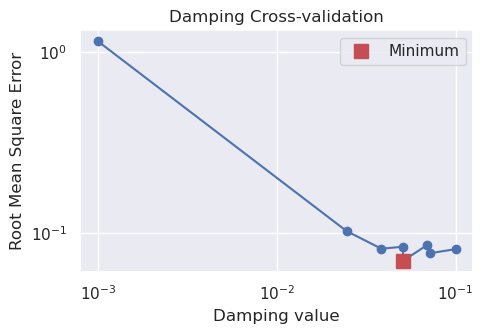

In [17]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    plot_cv=True,
    fname="../../results/Ross_Sea_no_regional_with_starting_damping_cv",
    # plot_dynamic_convergence=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [48]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_no_regional_with_starting_damping_cv_results.pickle").open("rb") as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_no_regional_damping_cv_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [49]:
best_damping = parameters.get("Solver damping")
best_damping

0.05109412690255546

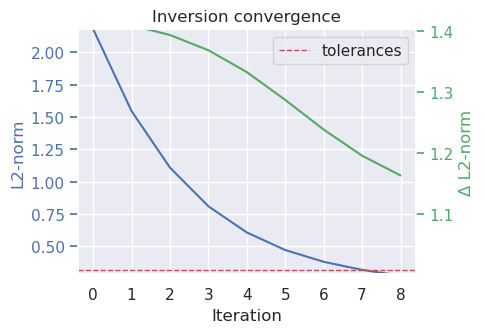

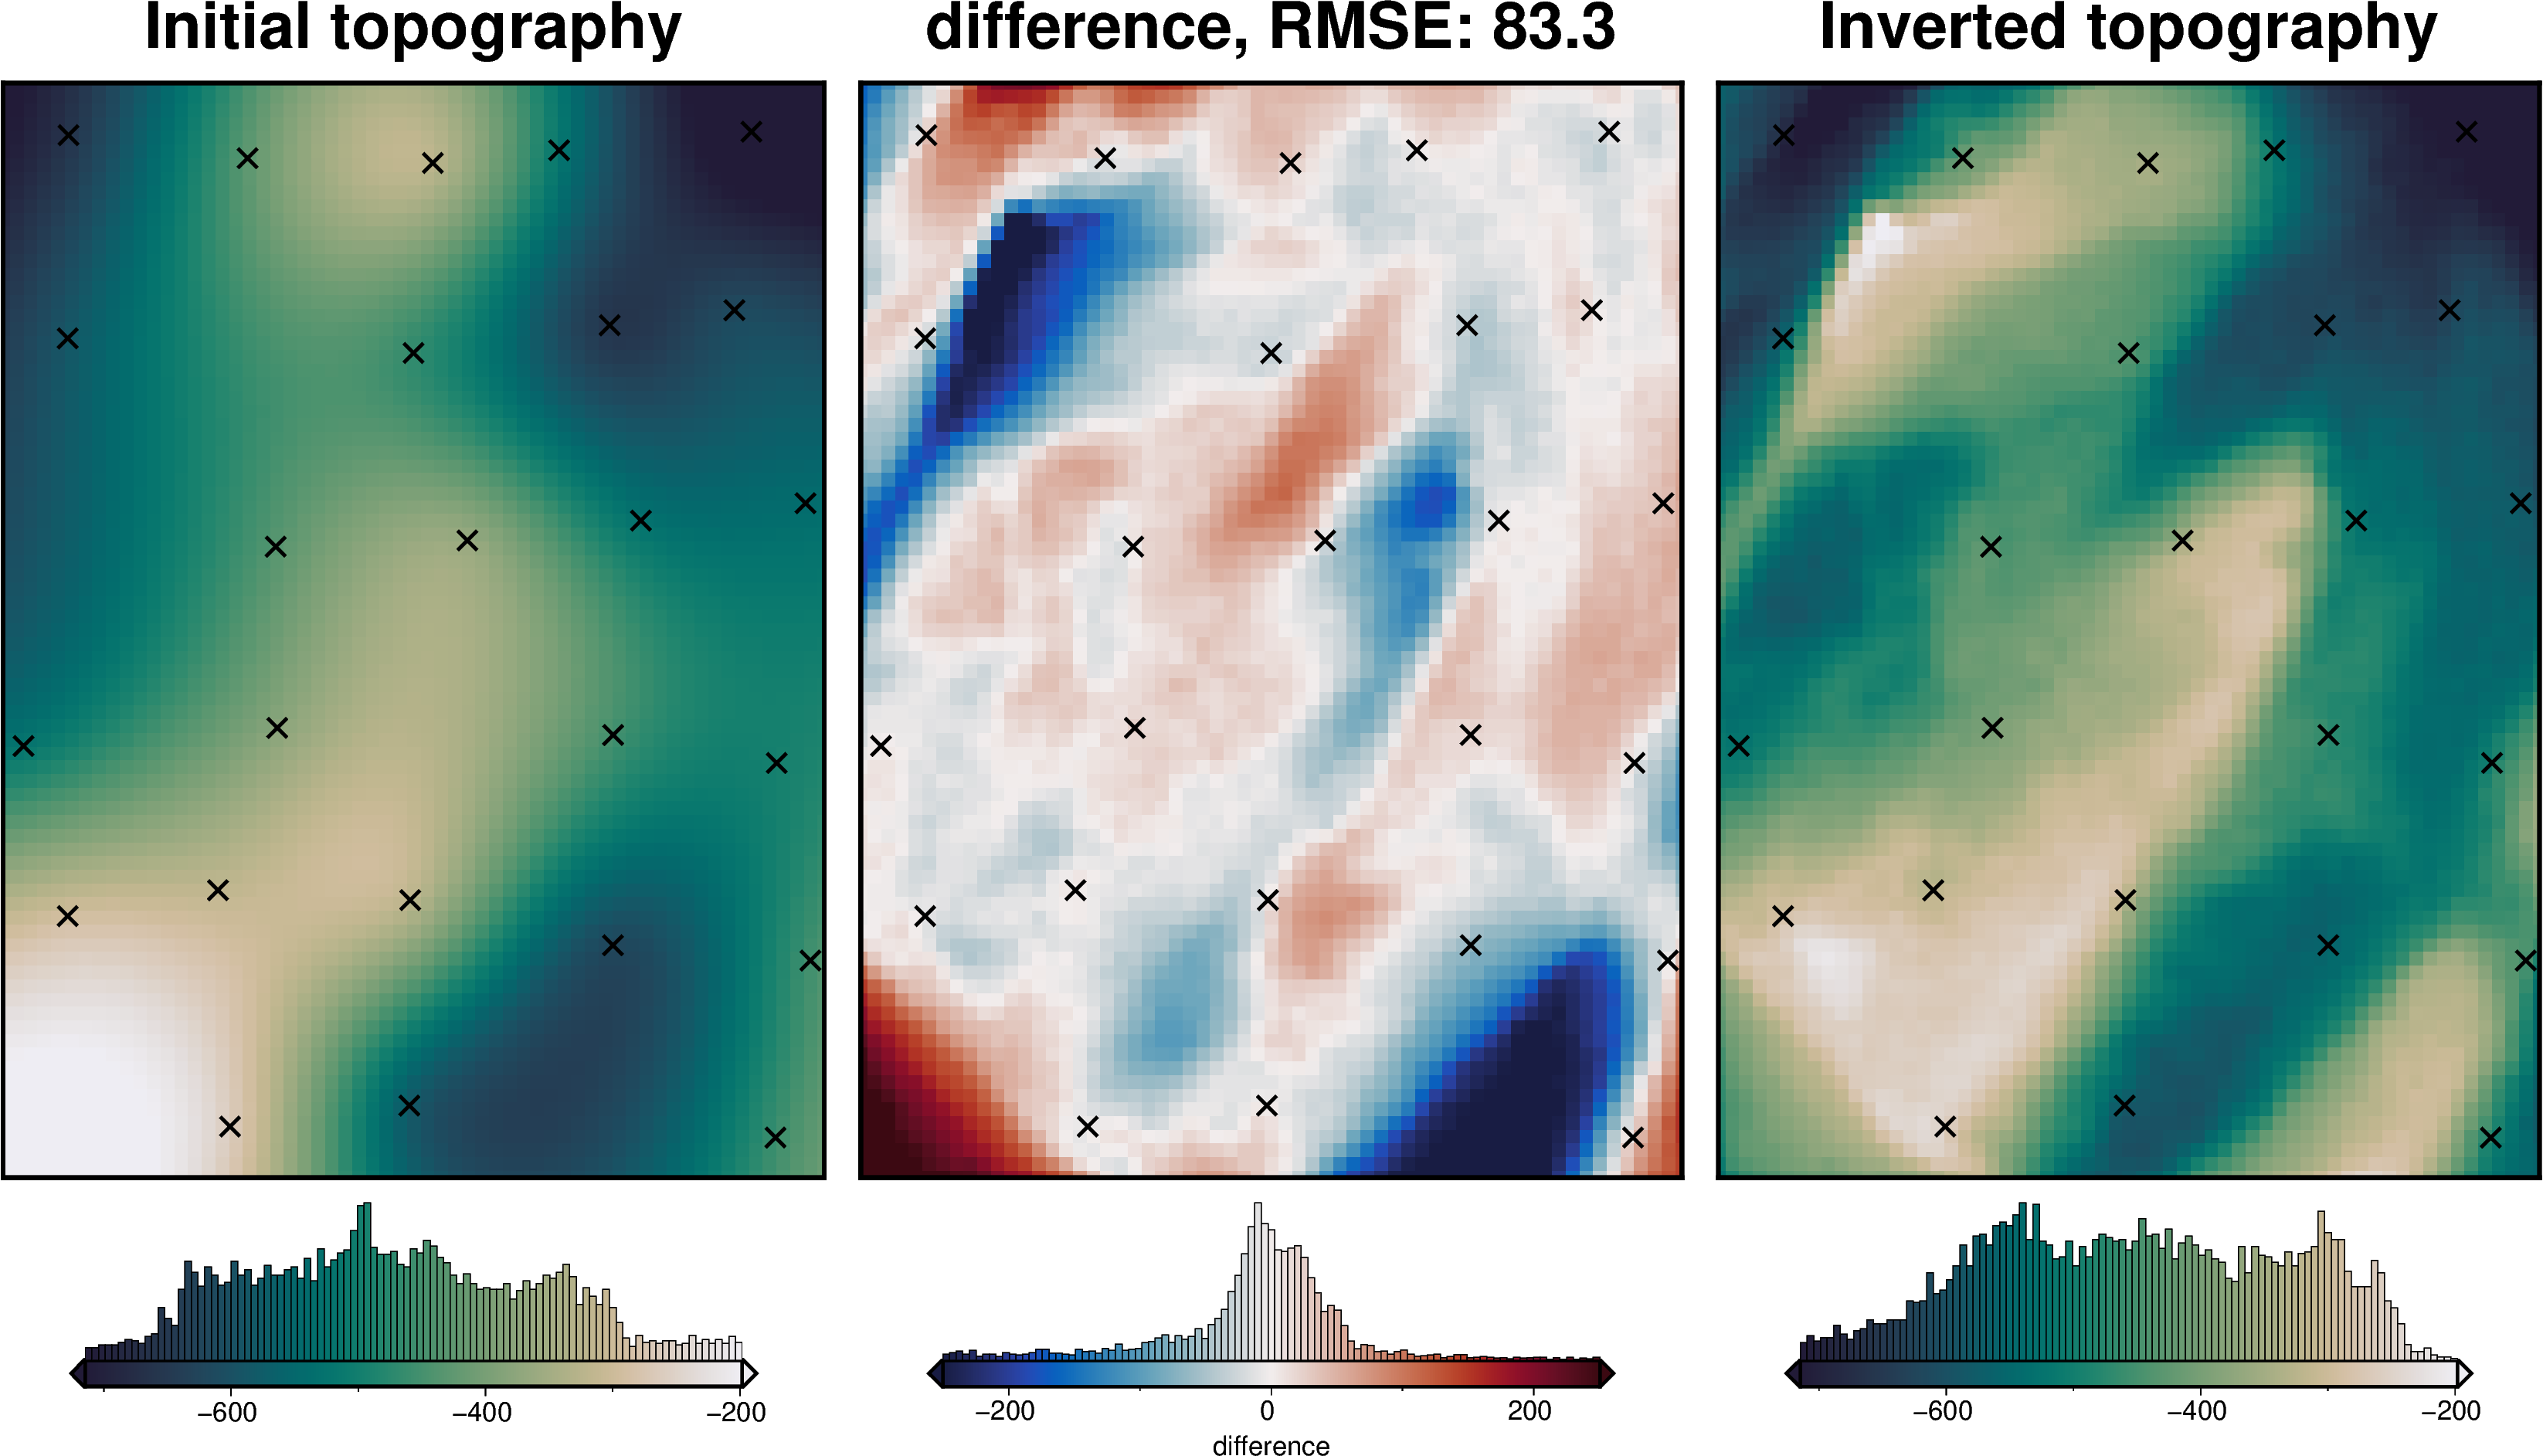

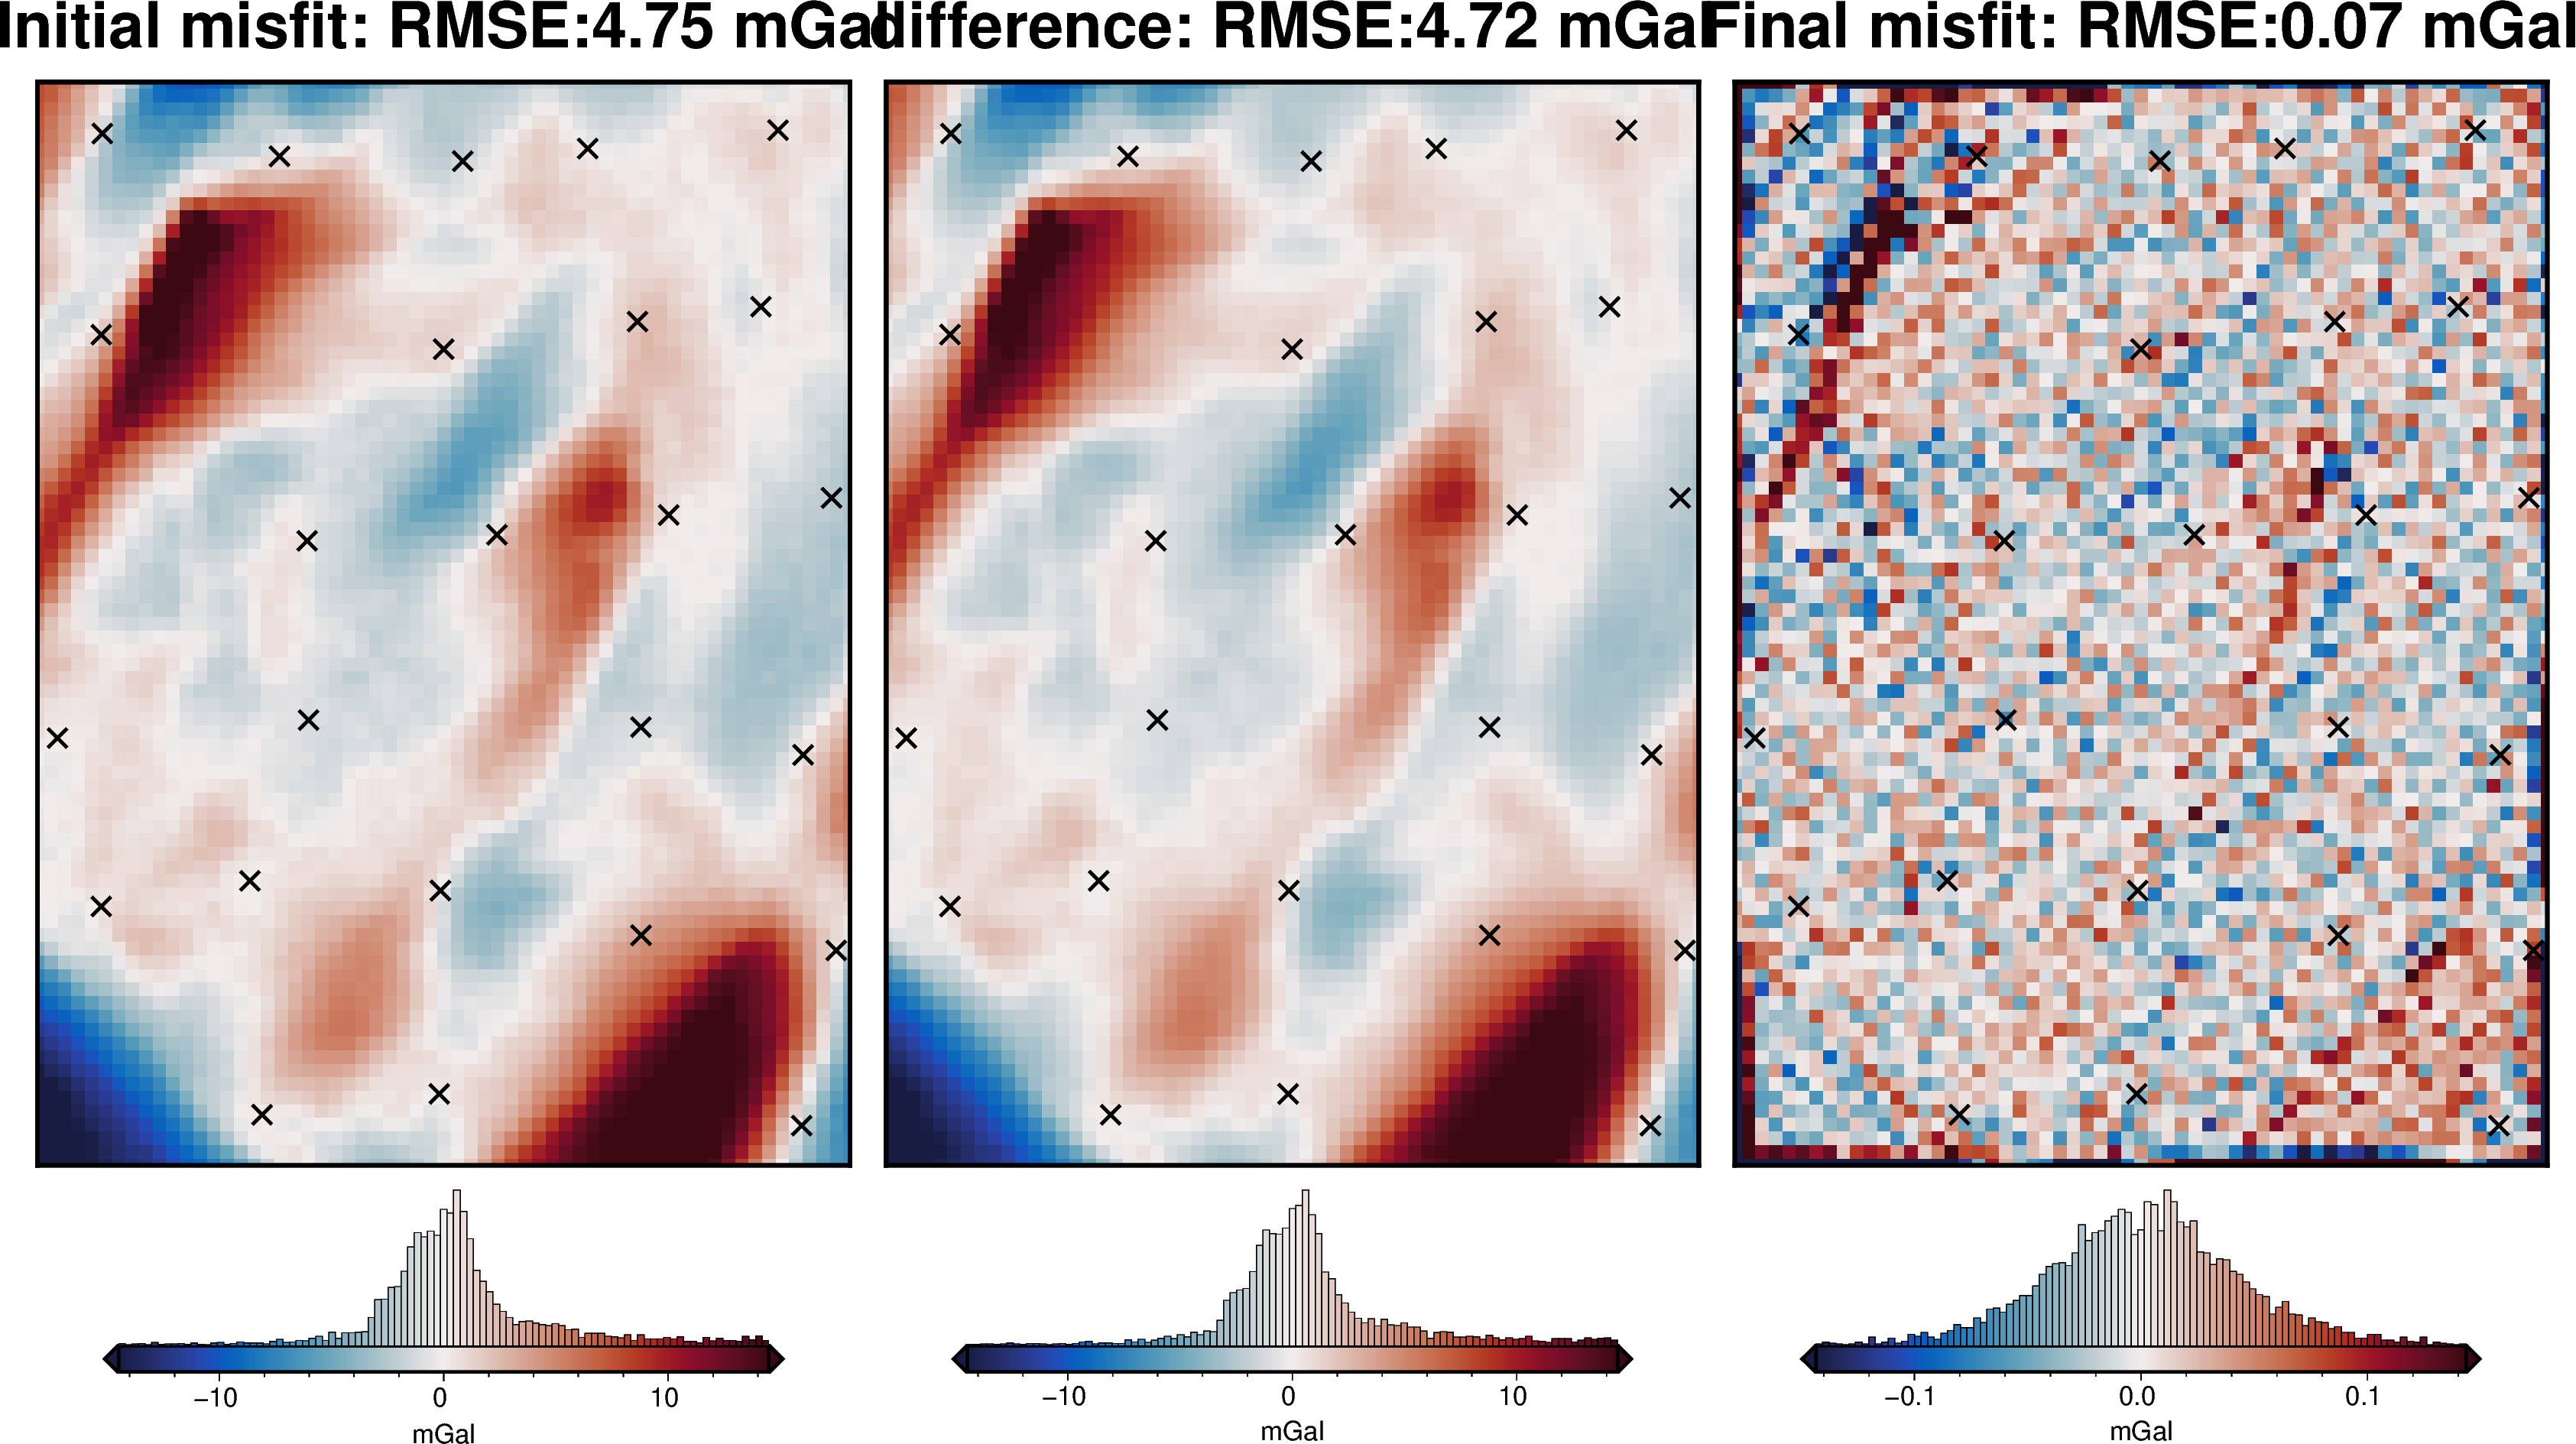

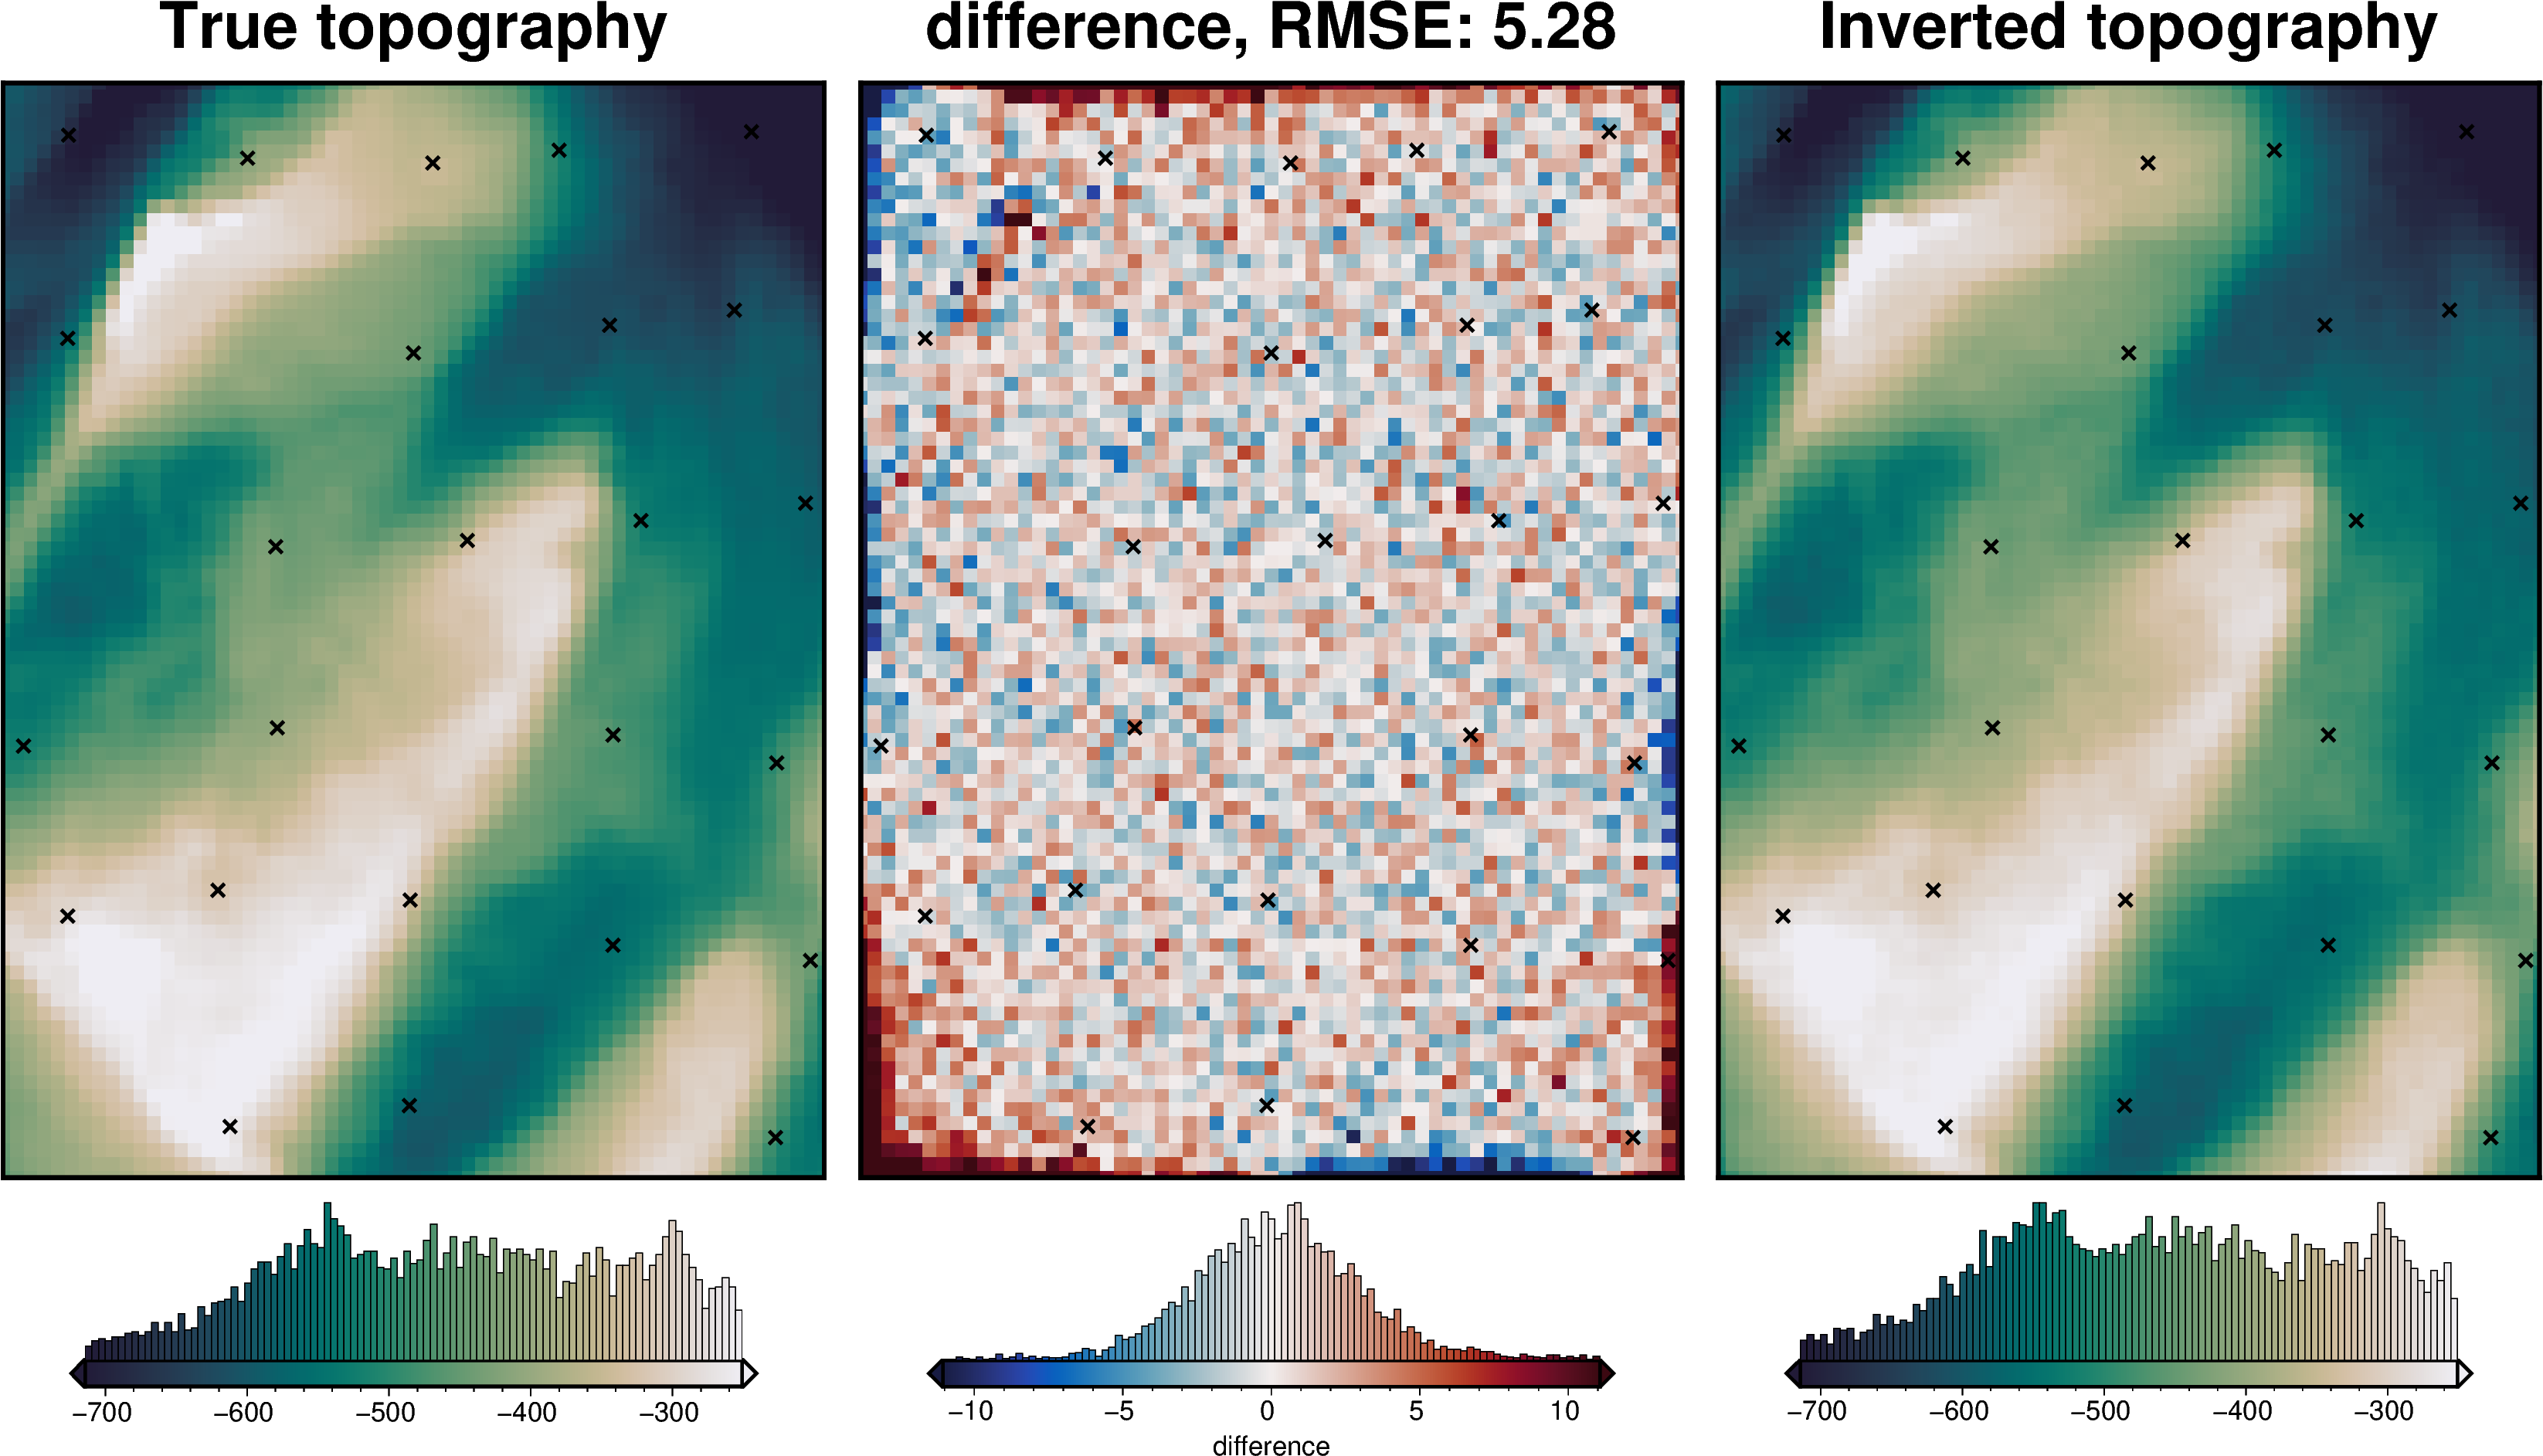

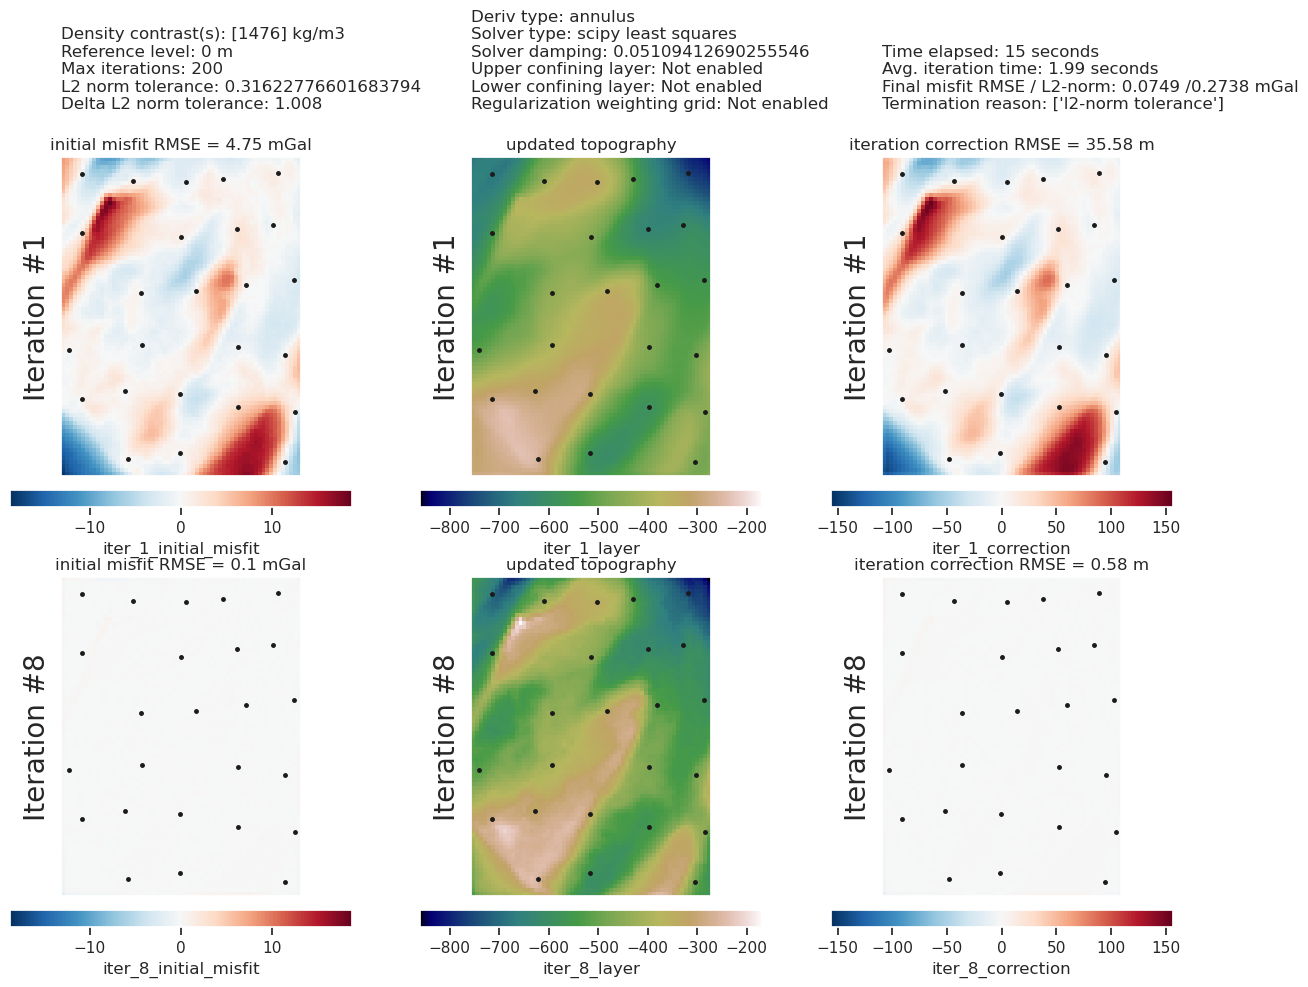

In [20]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints_df=constraint_points,
    constraint_size=5,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    points_pen="1p",
)

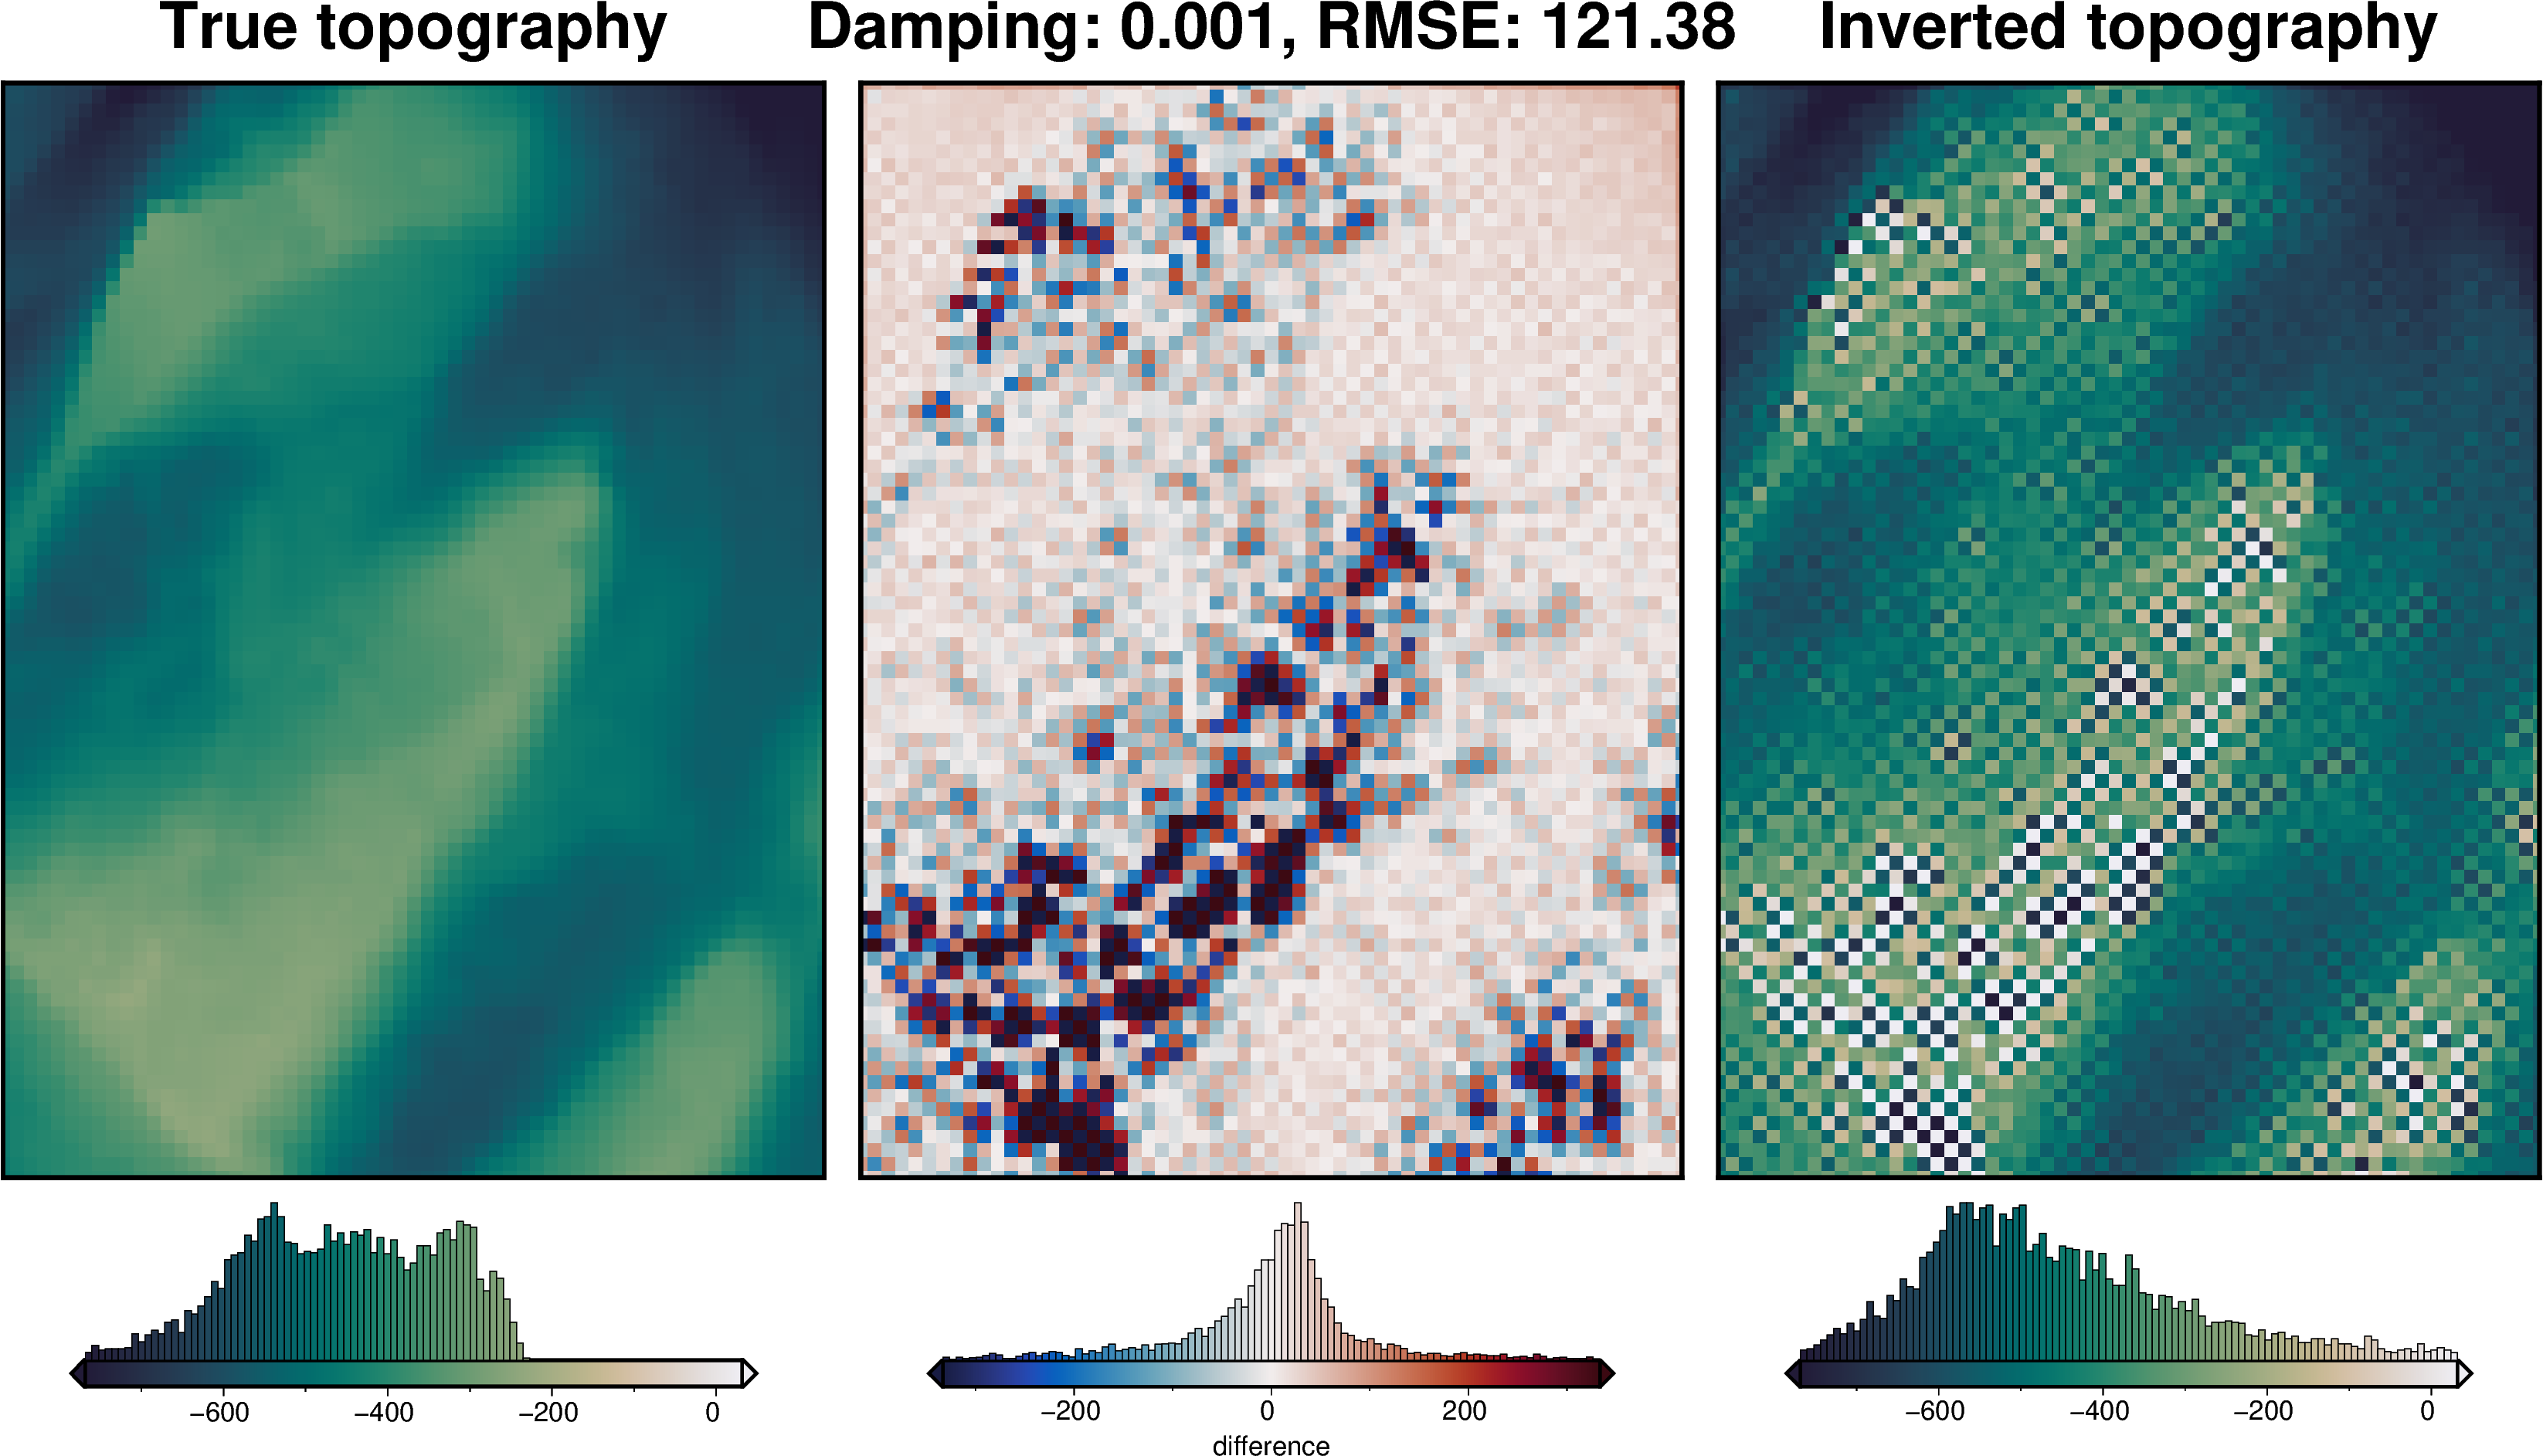

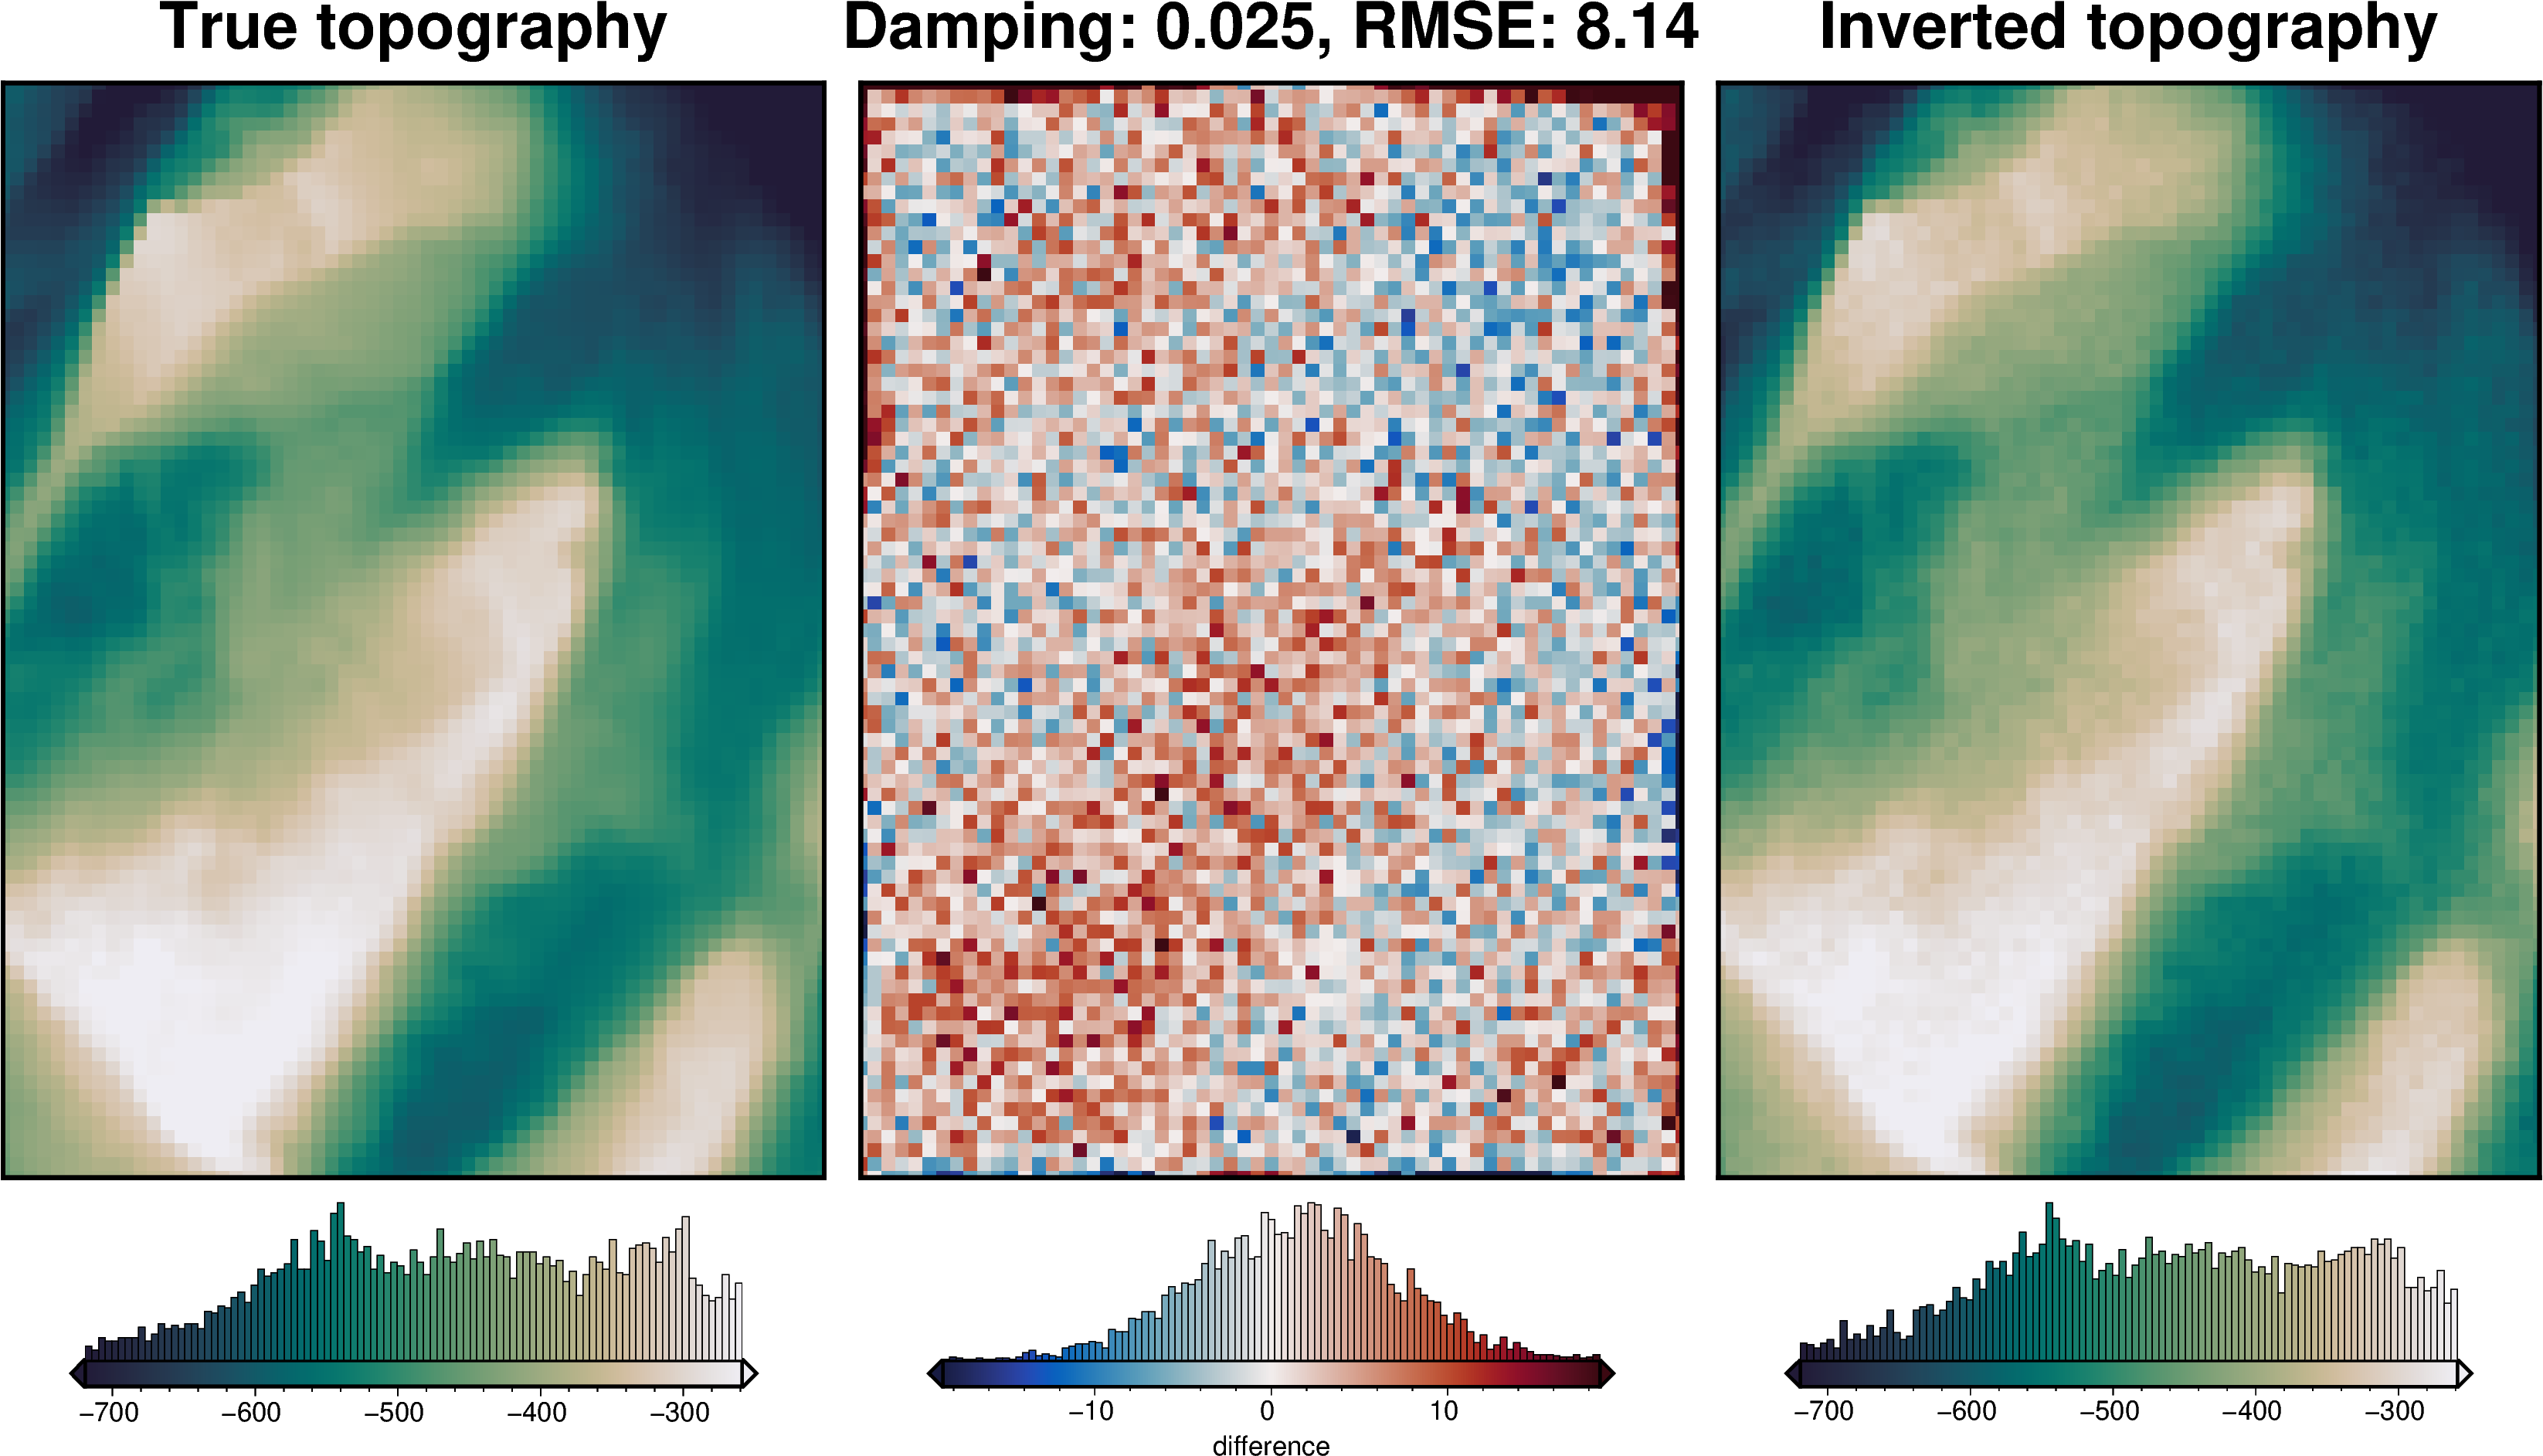

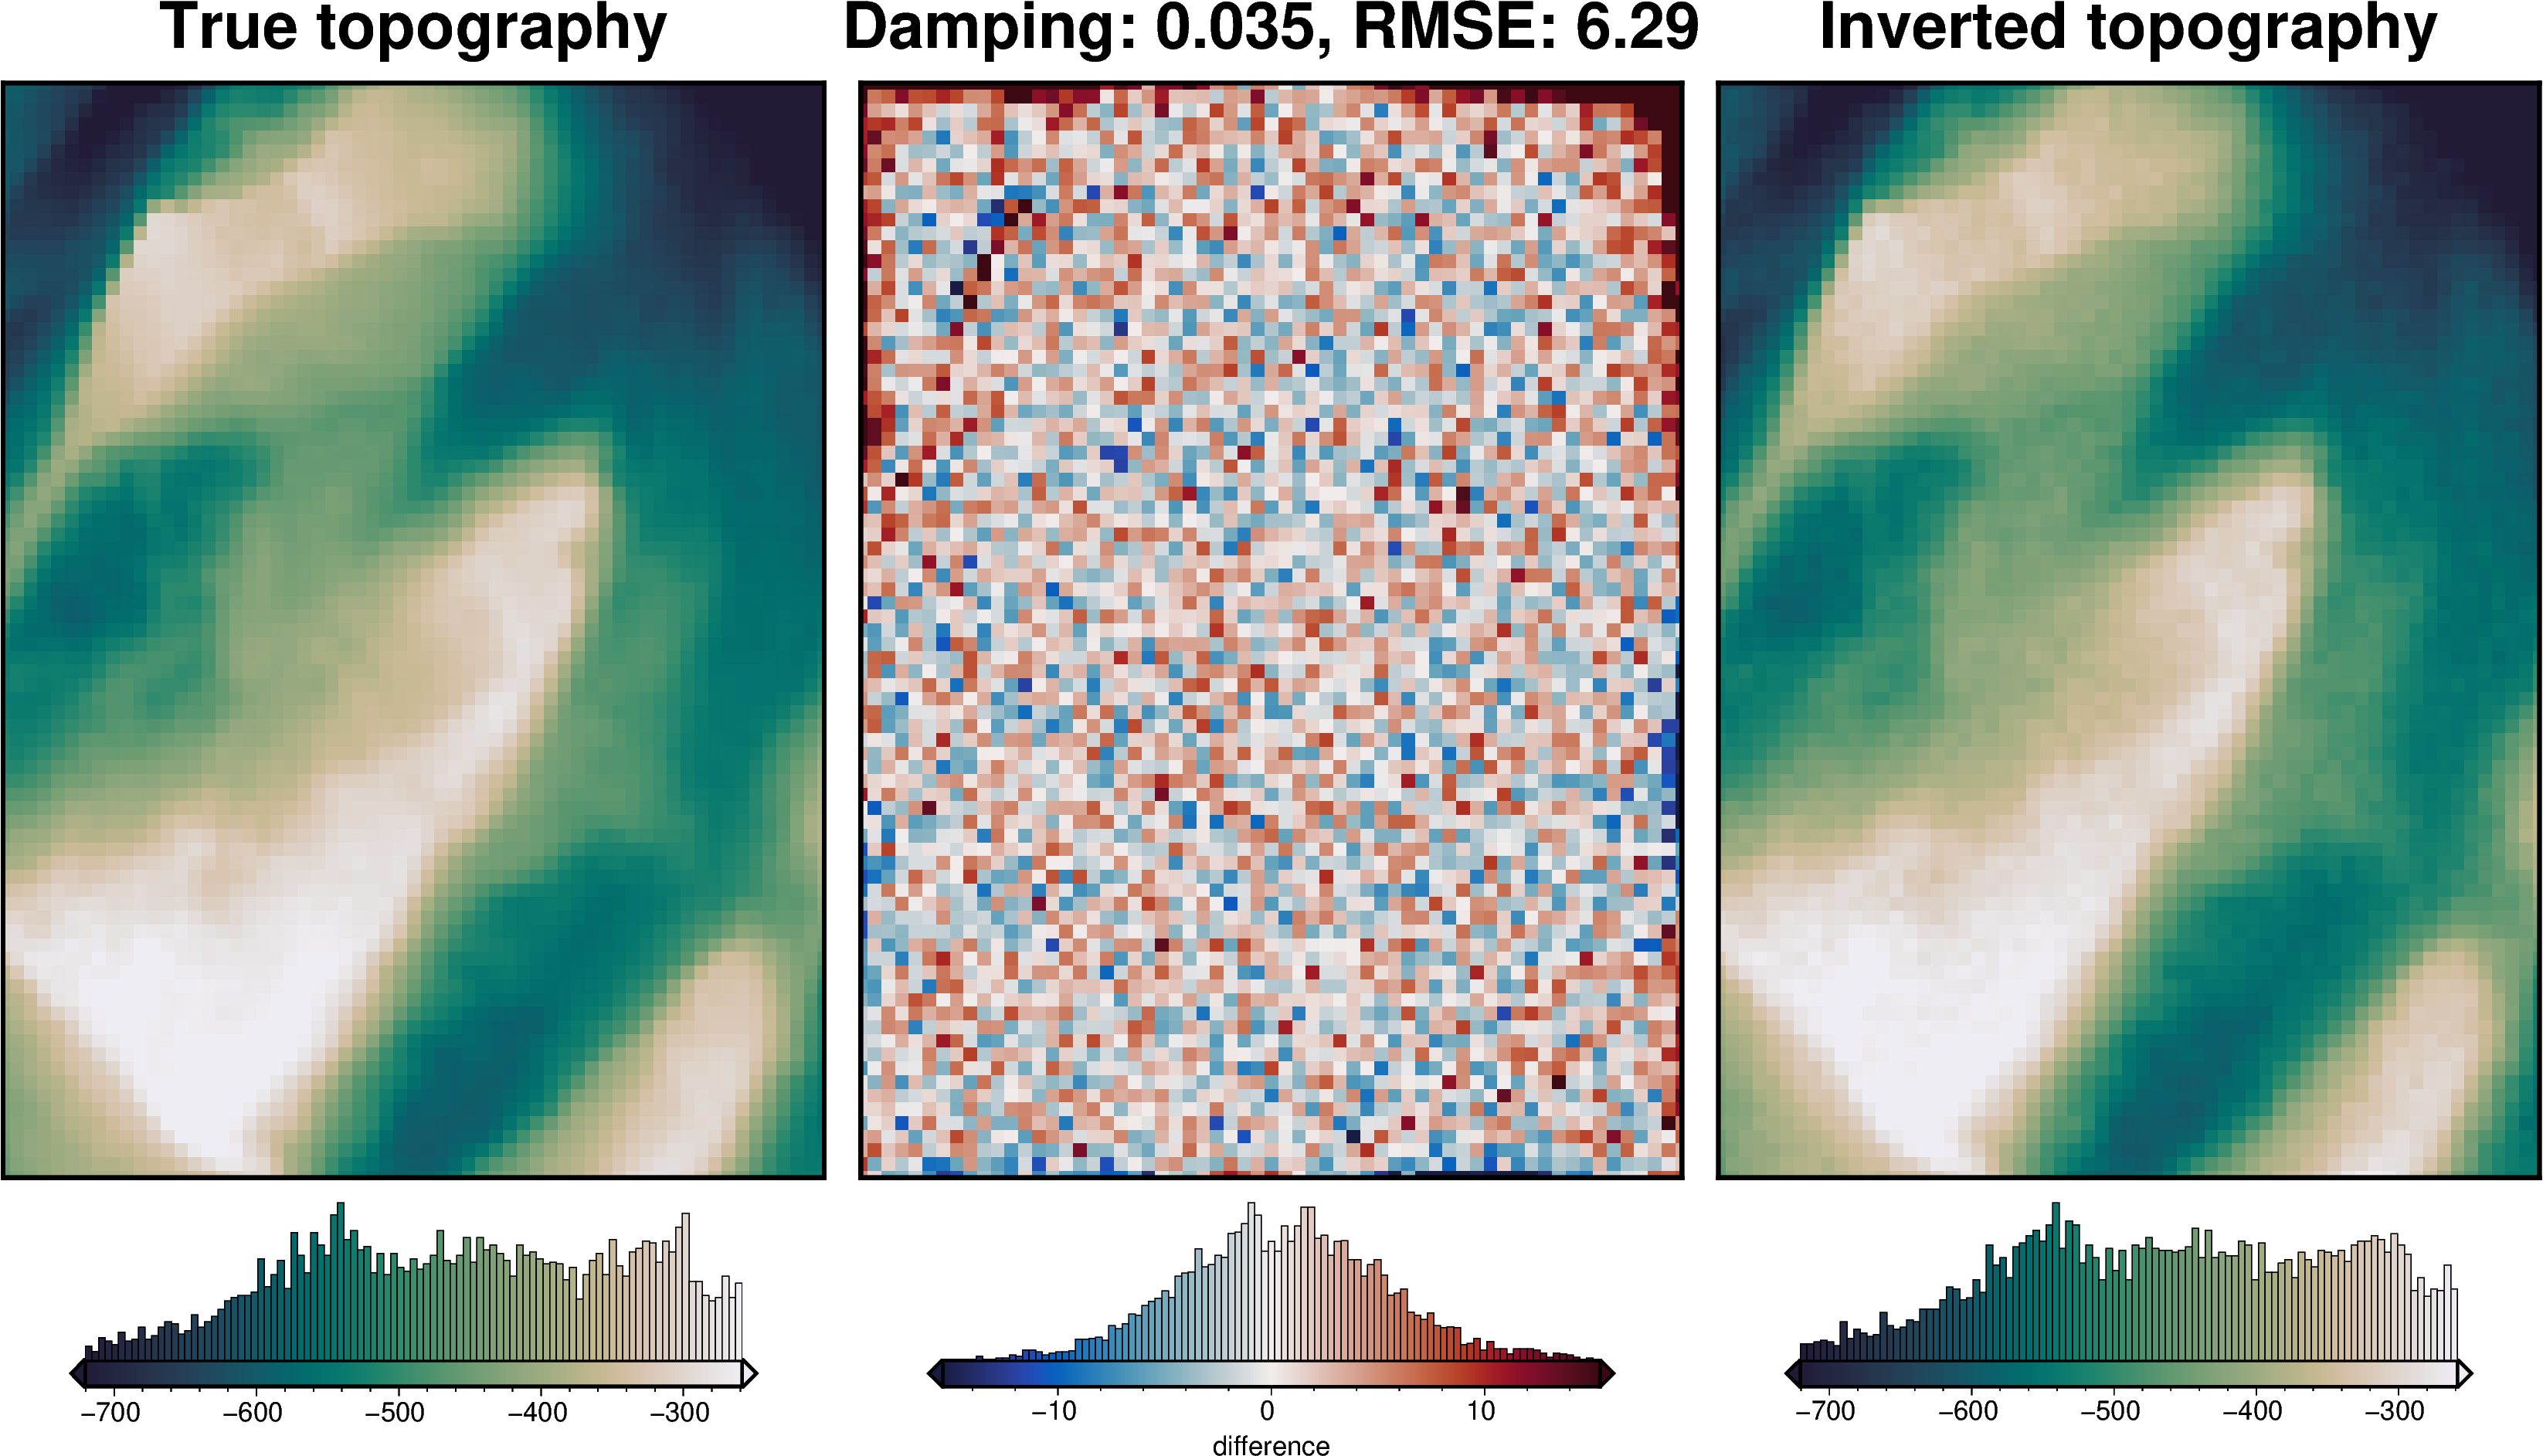

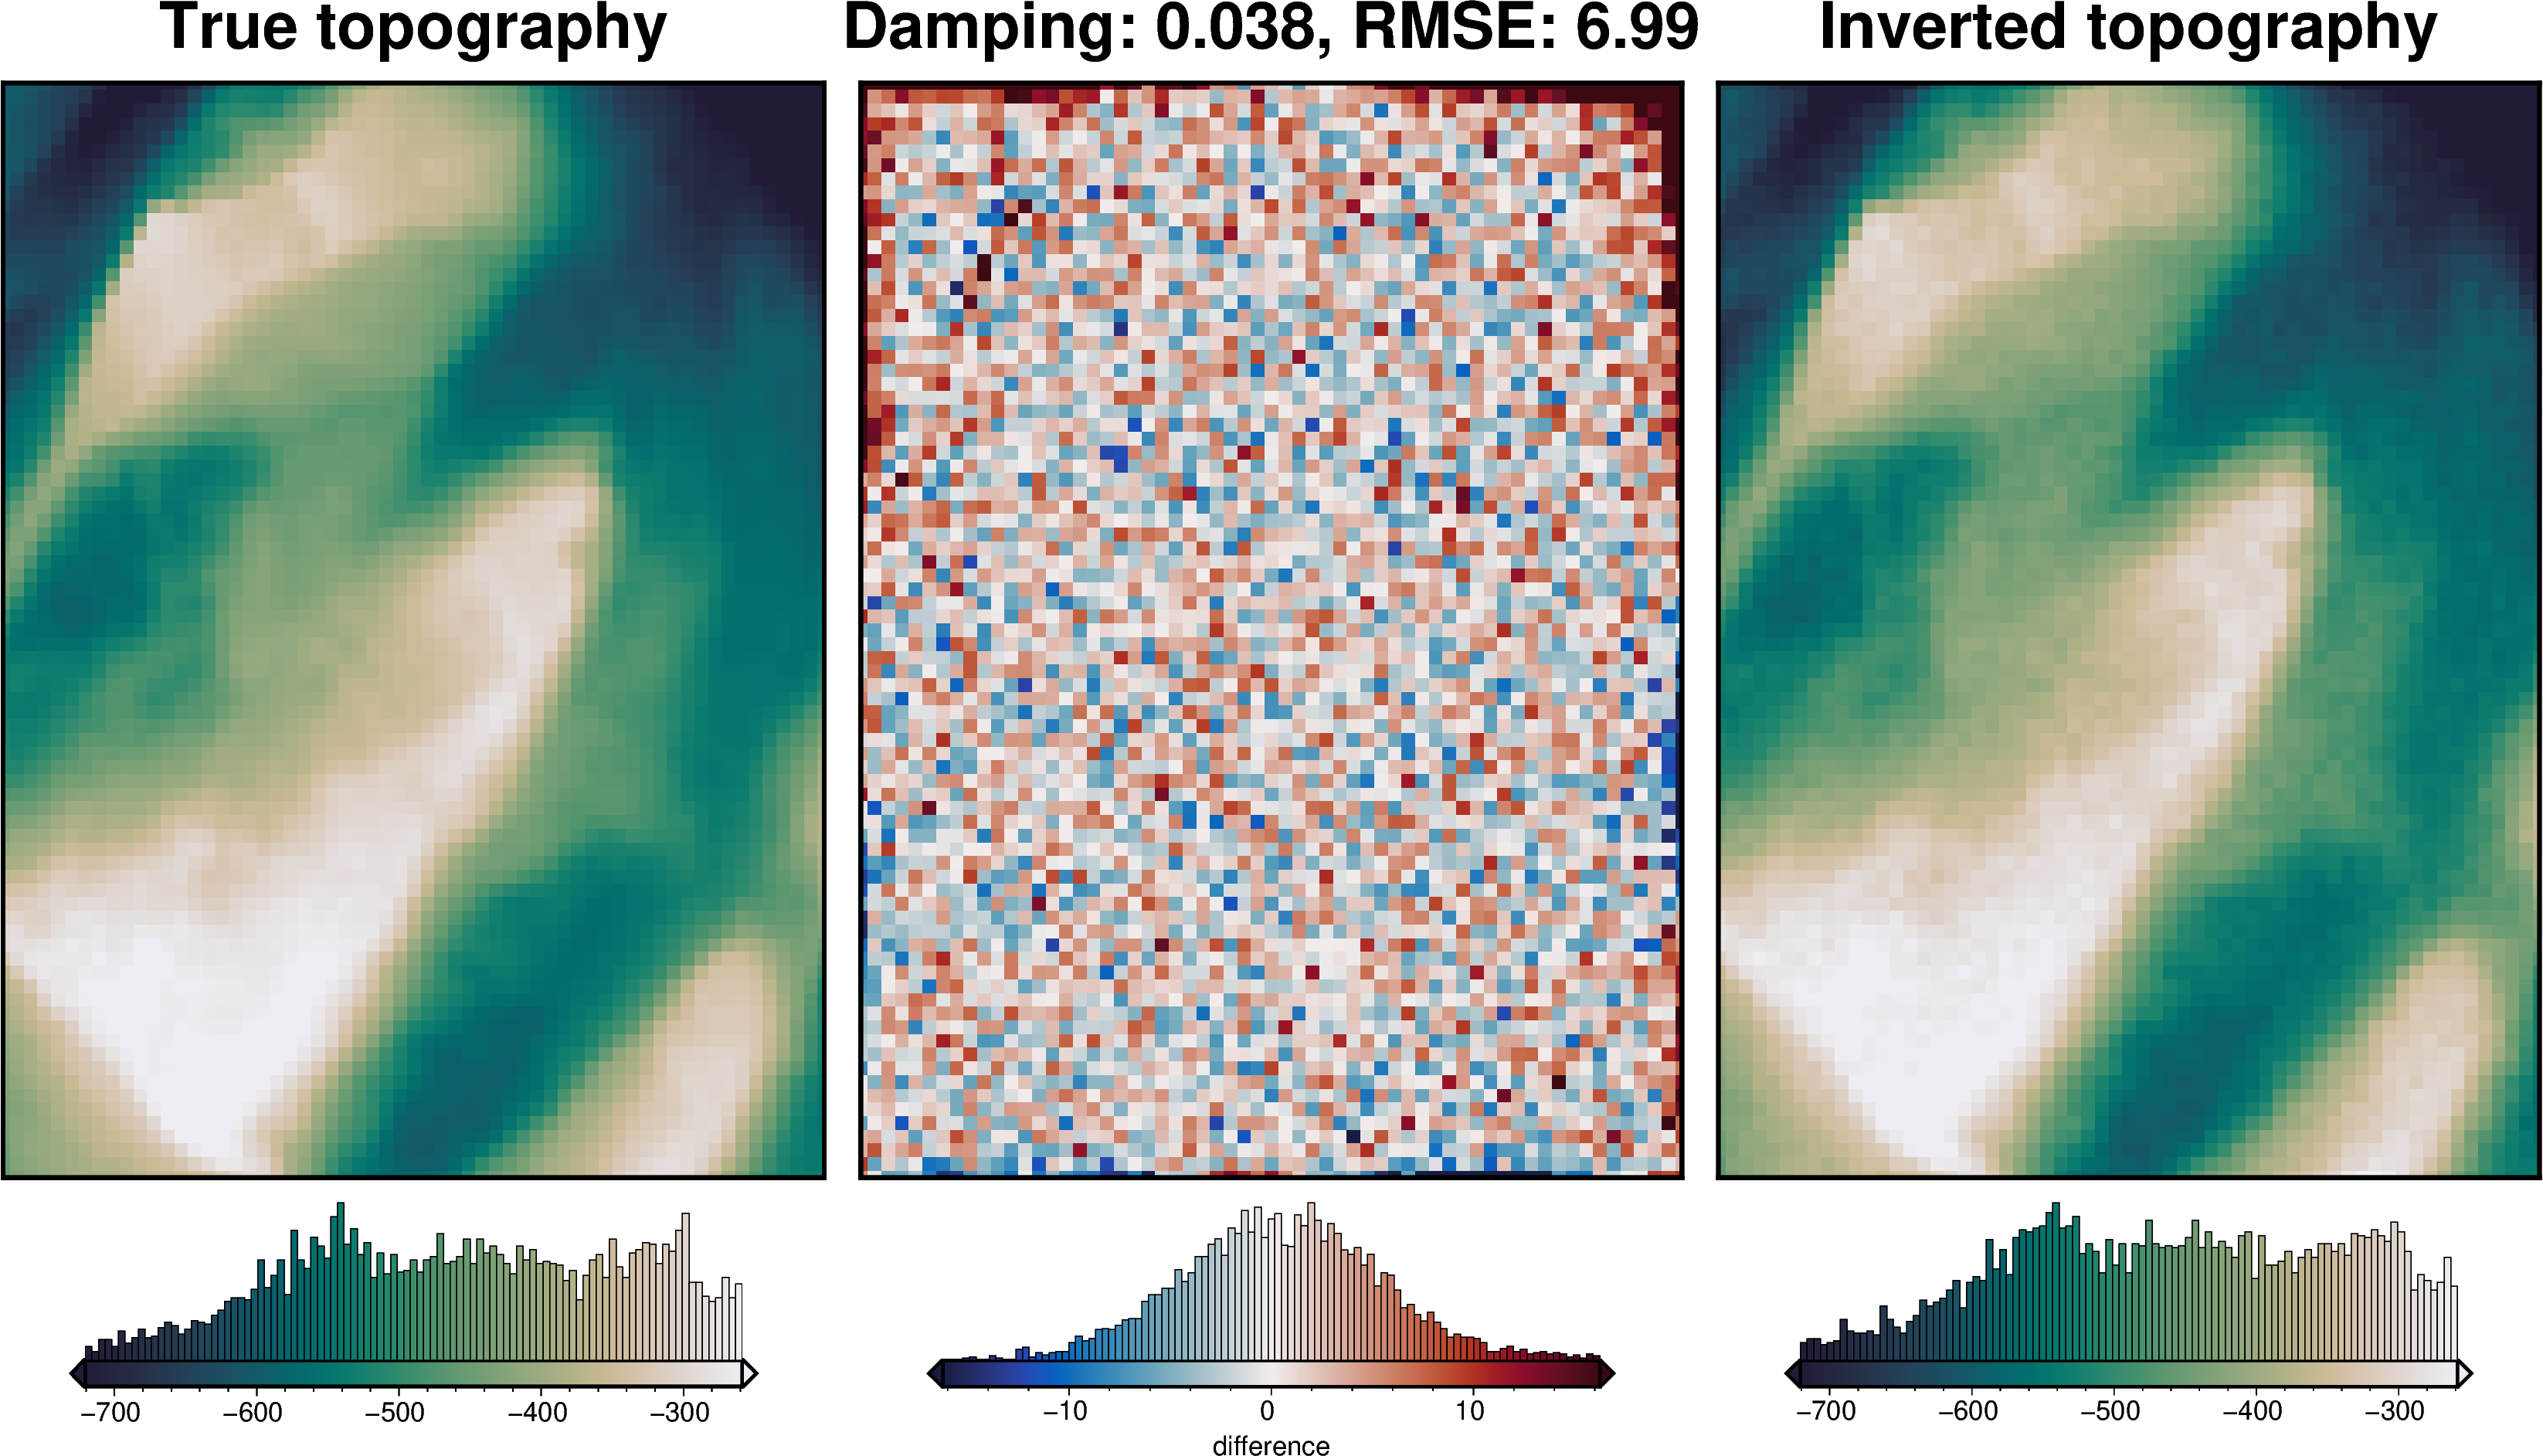

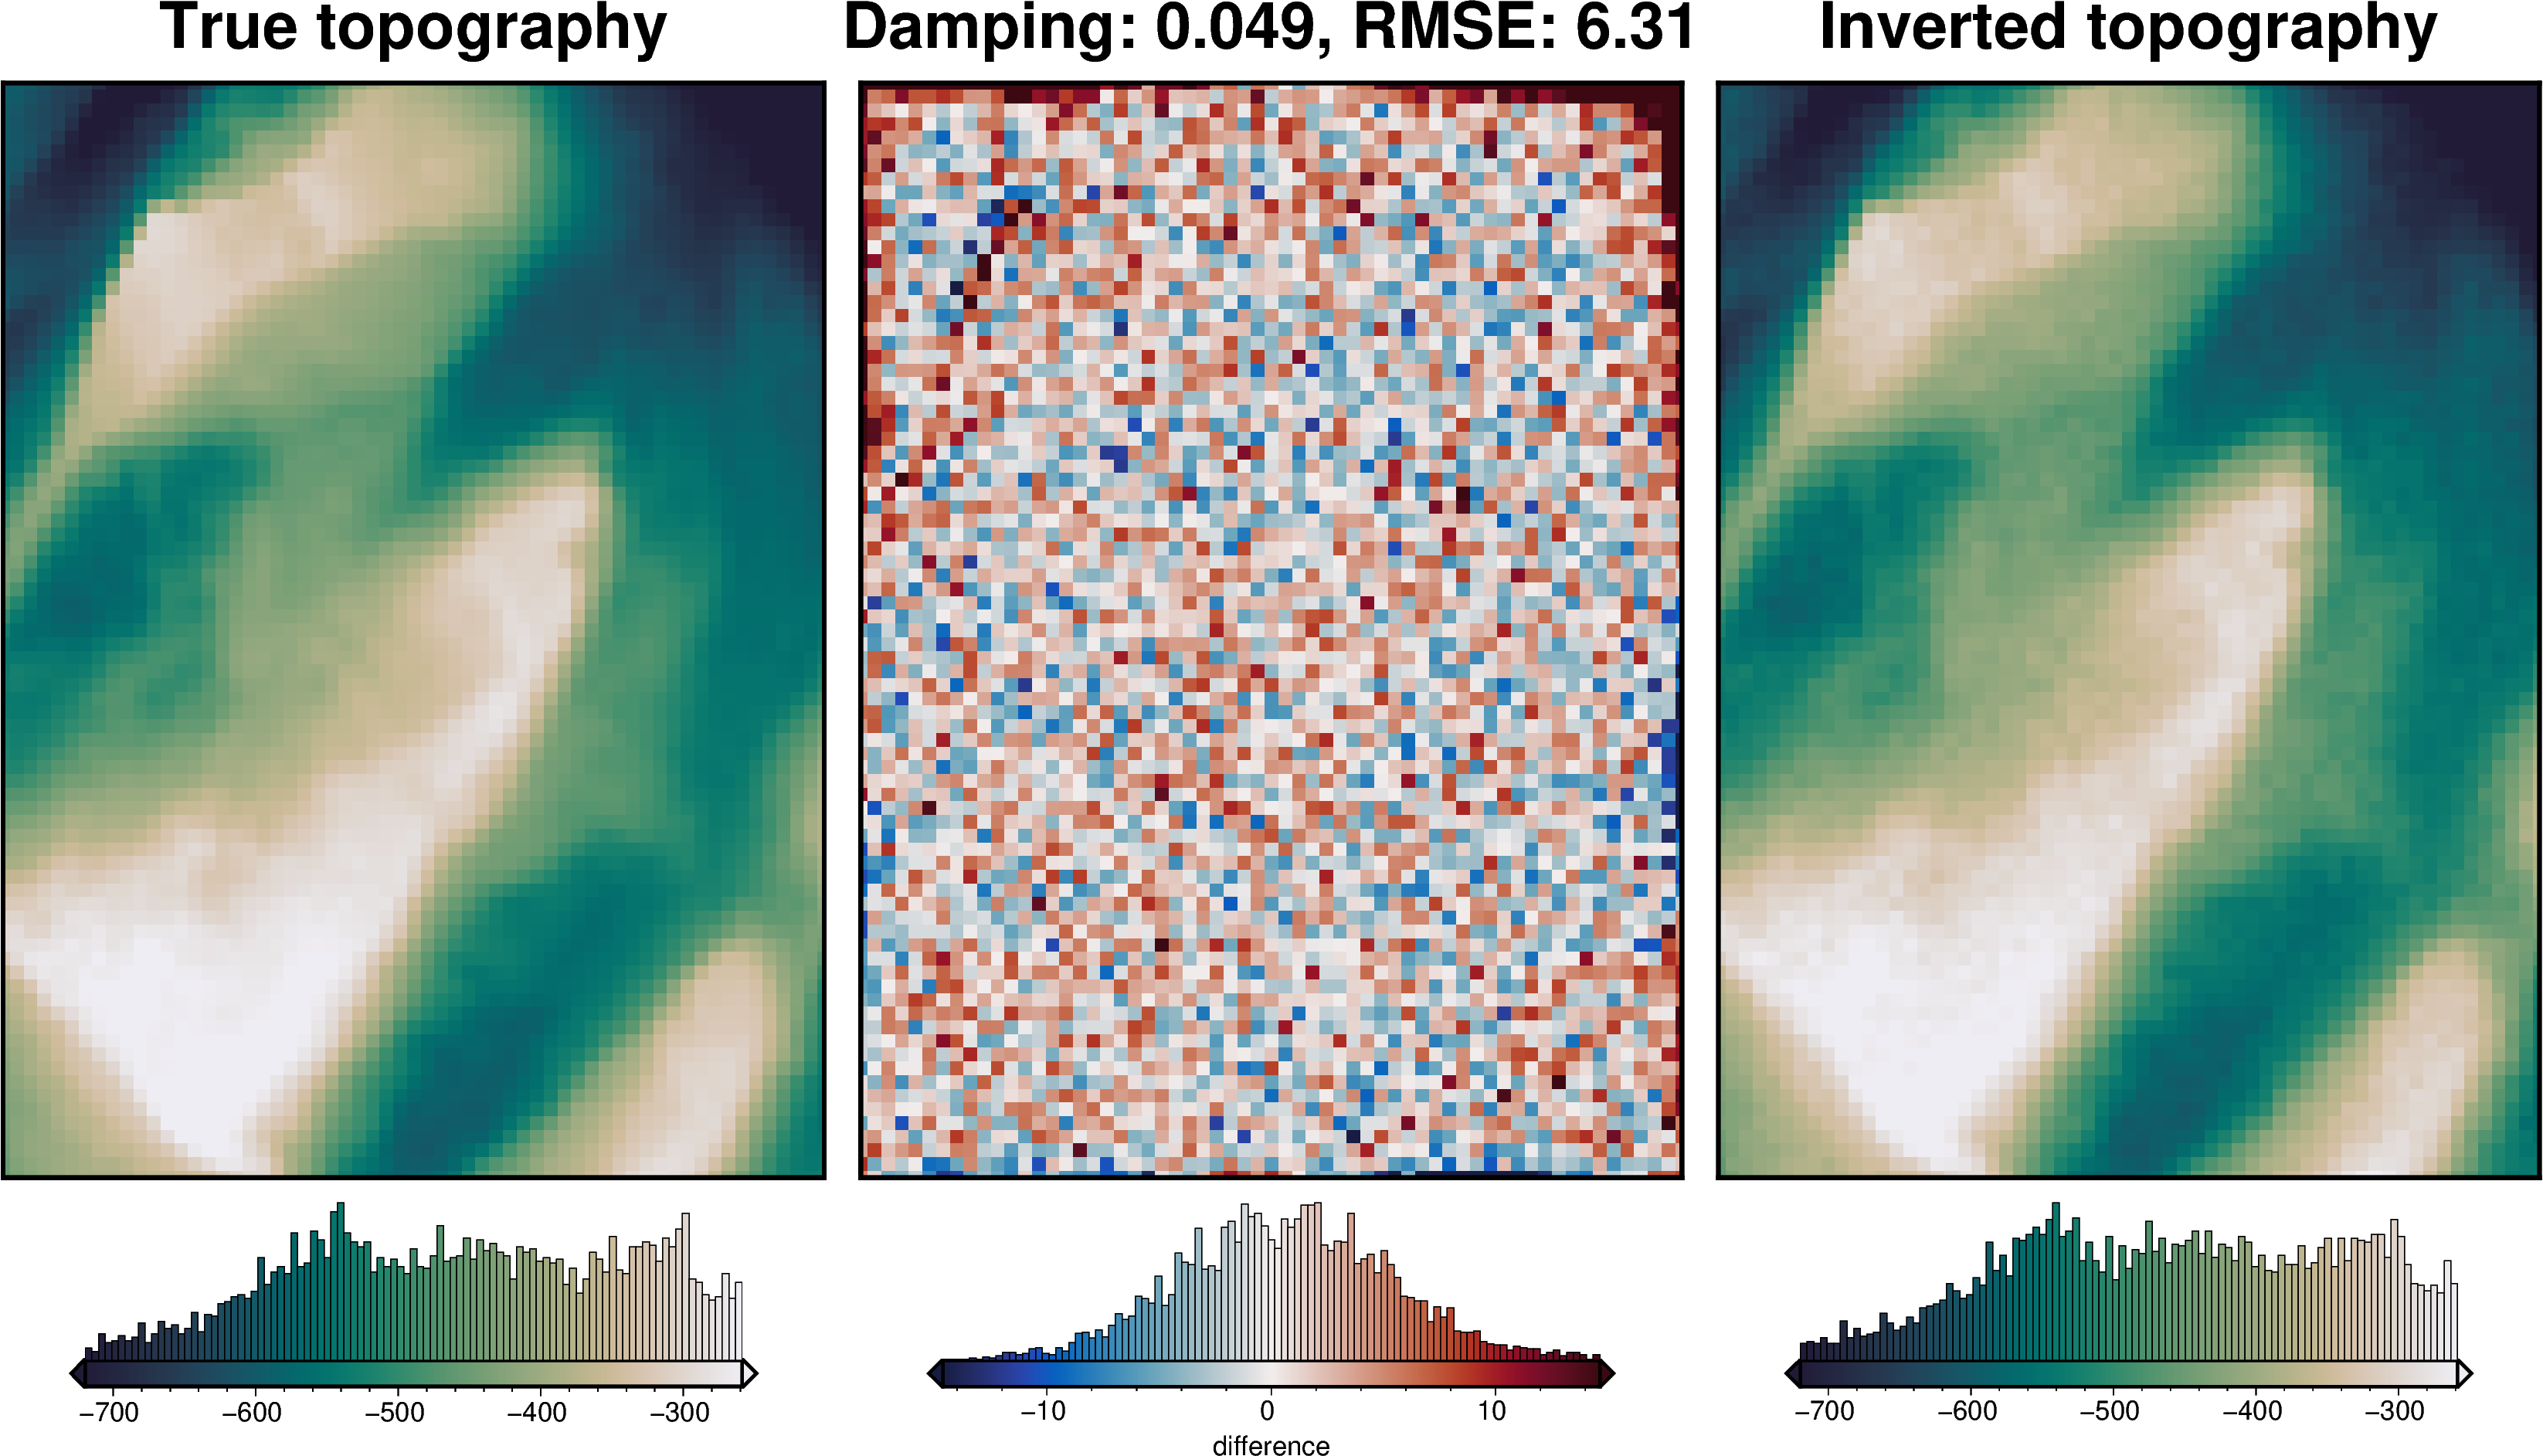

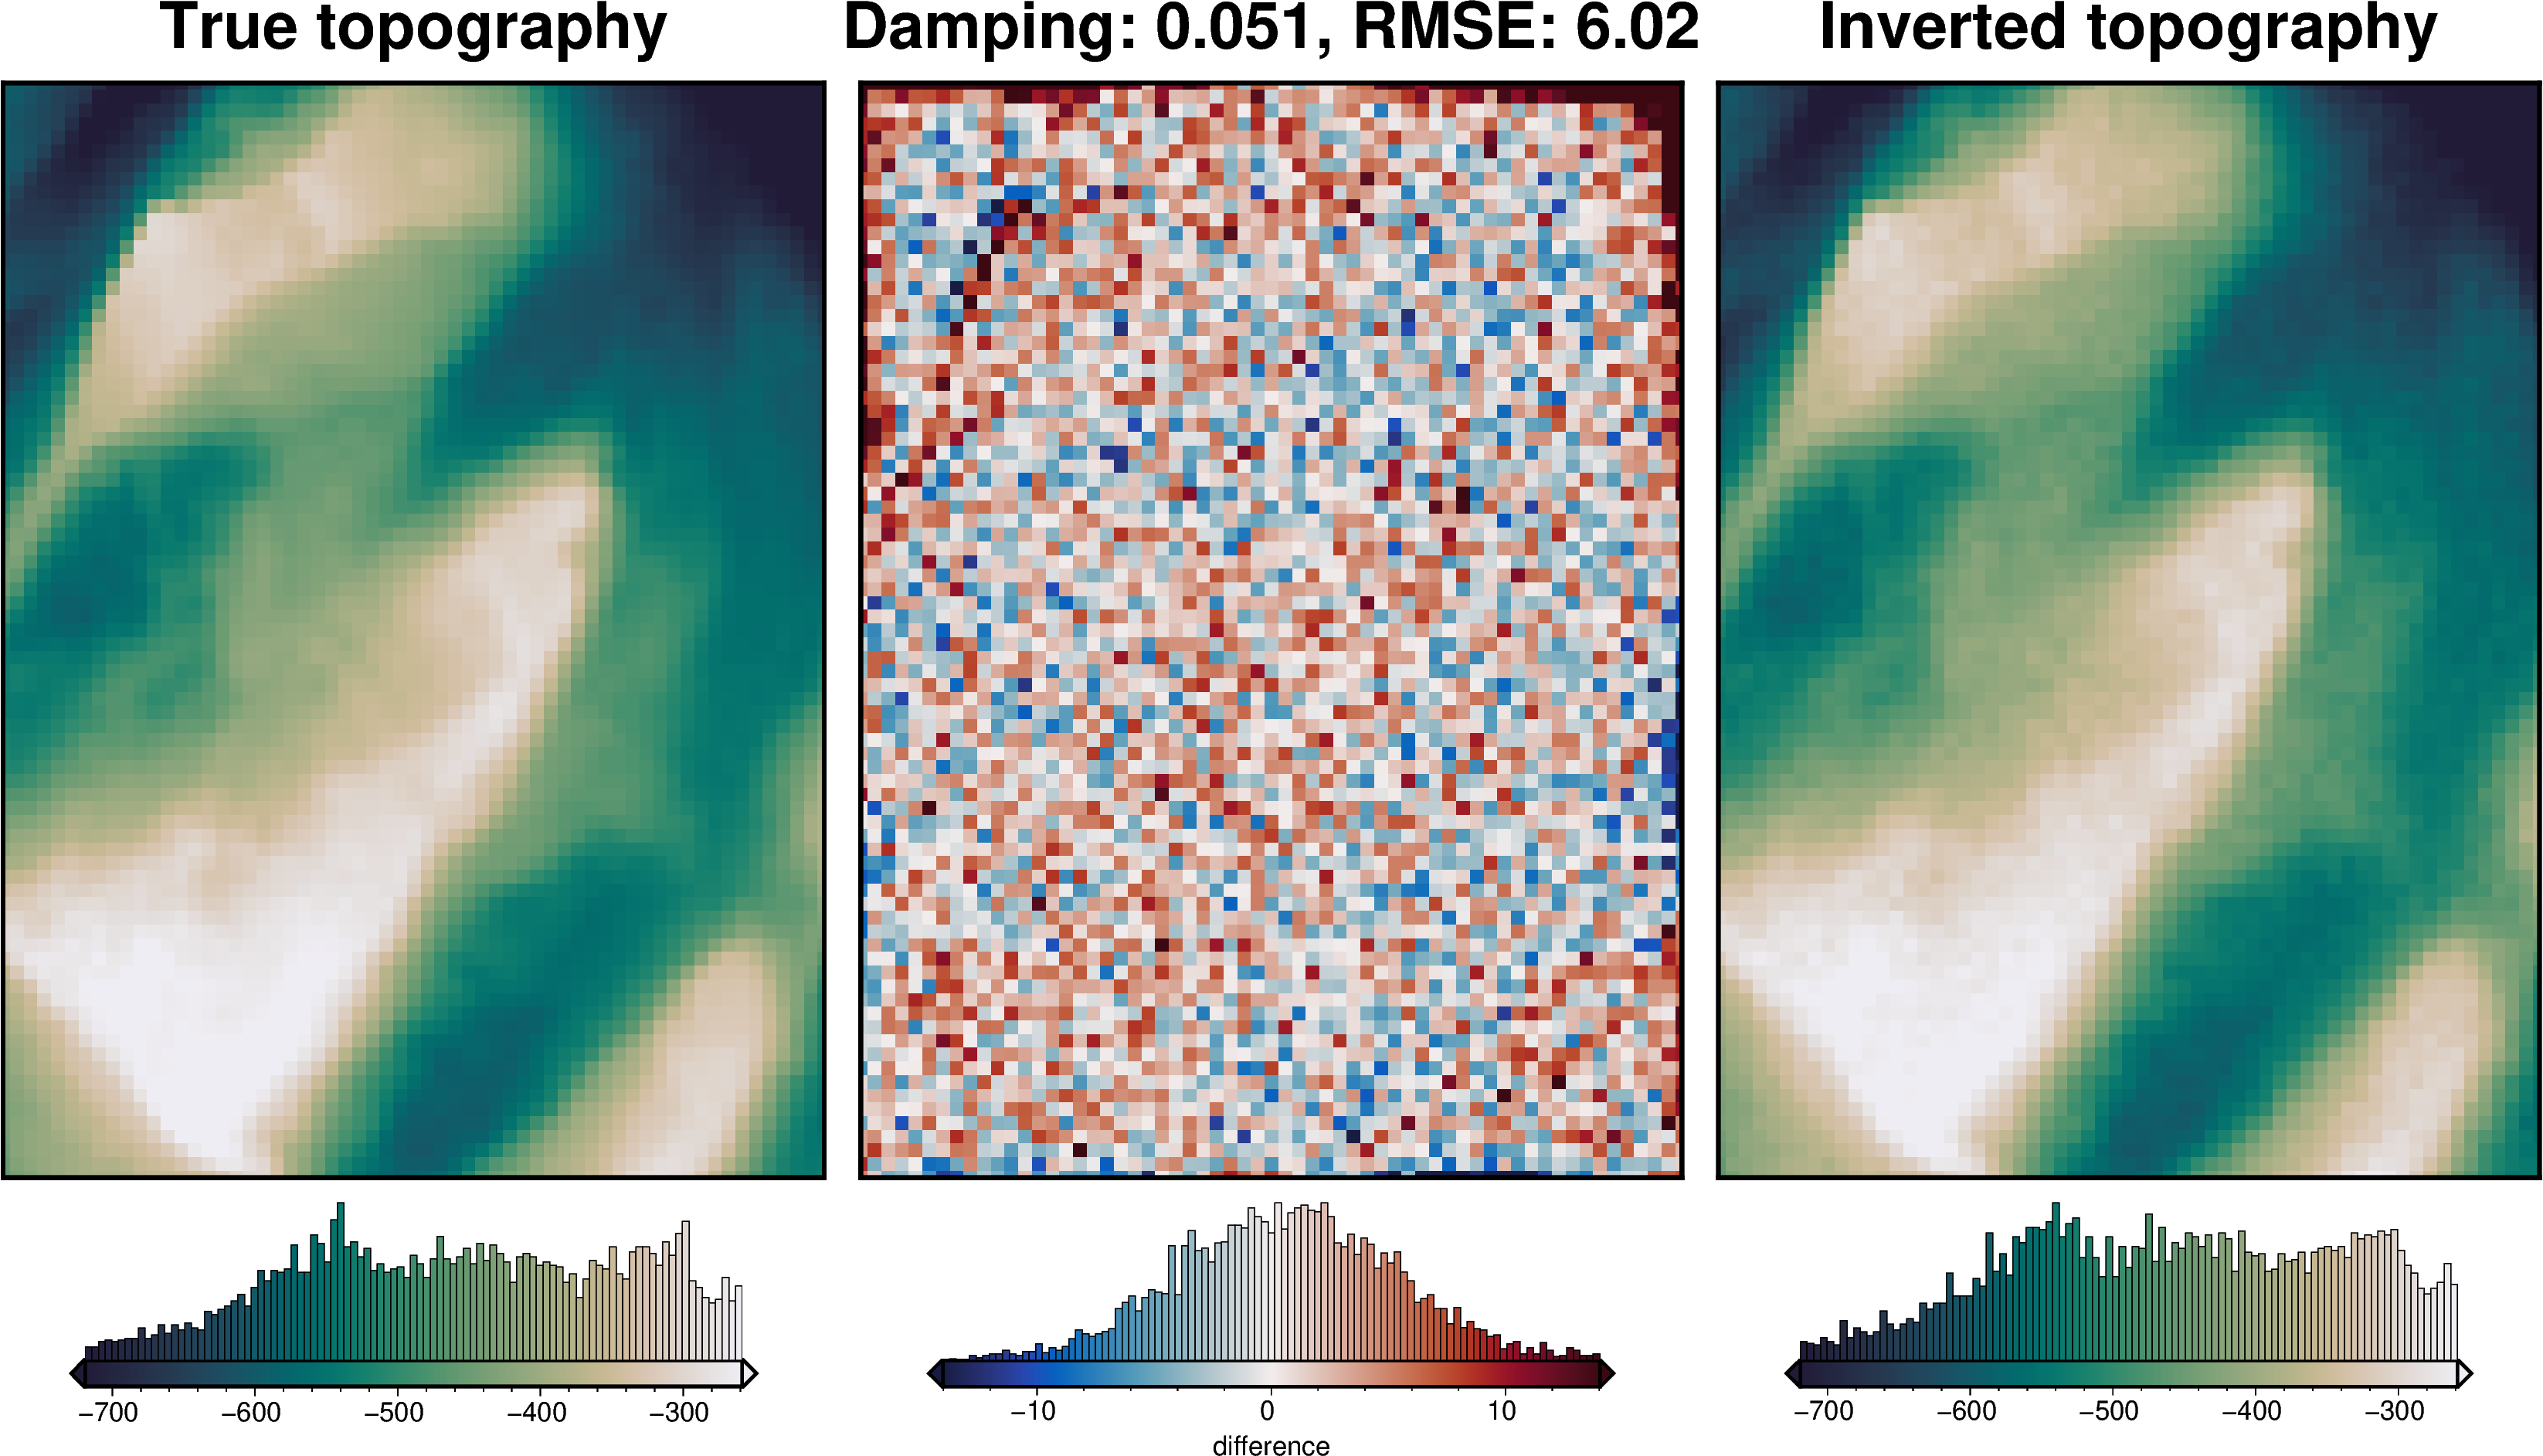

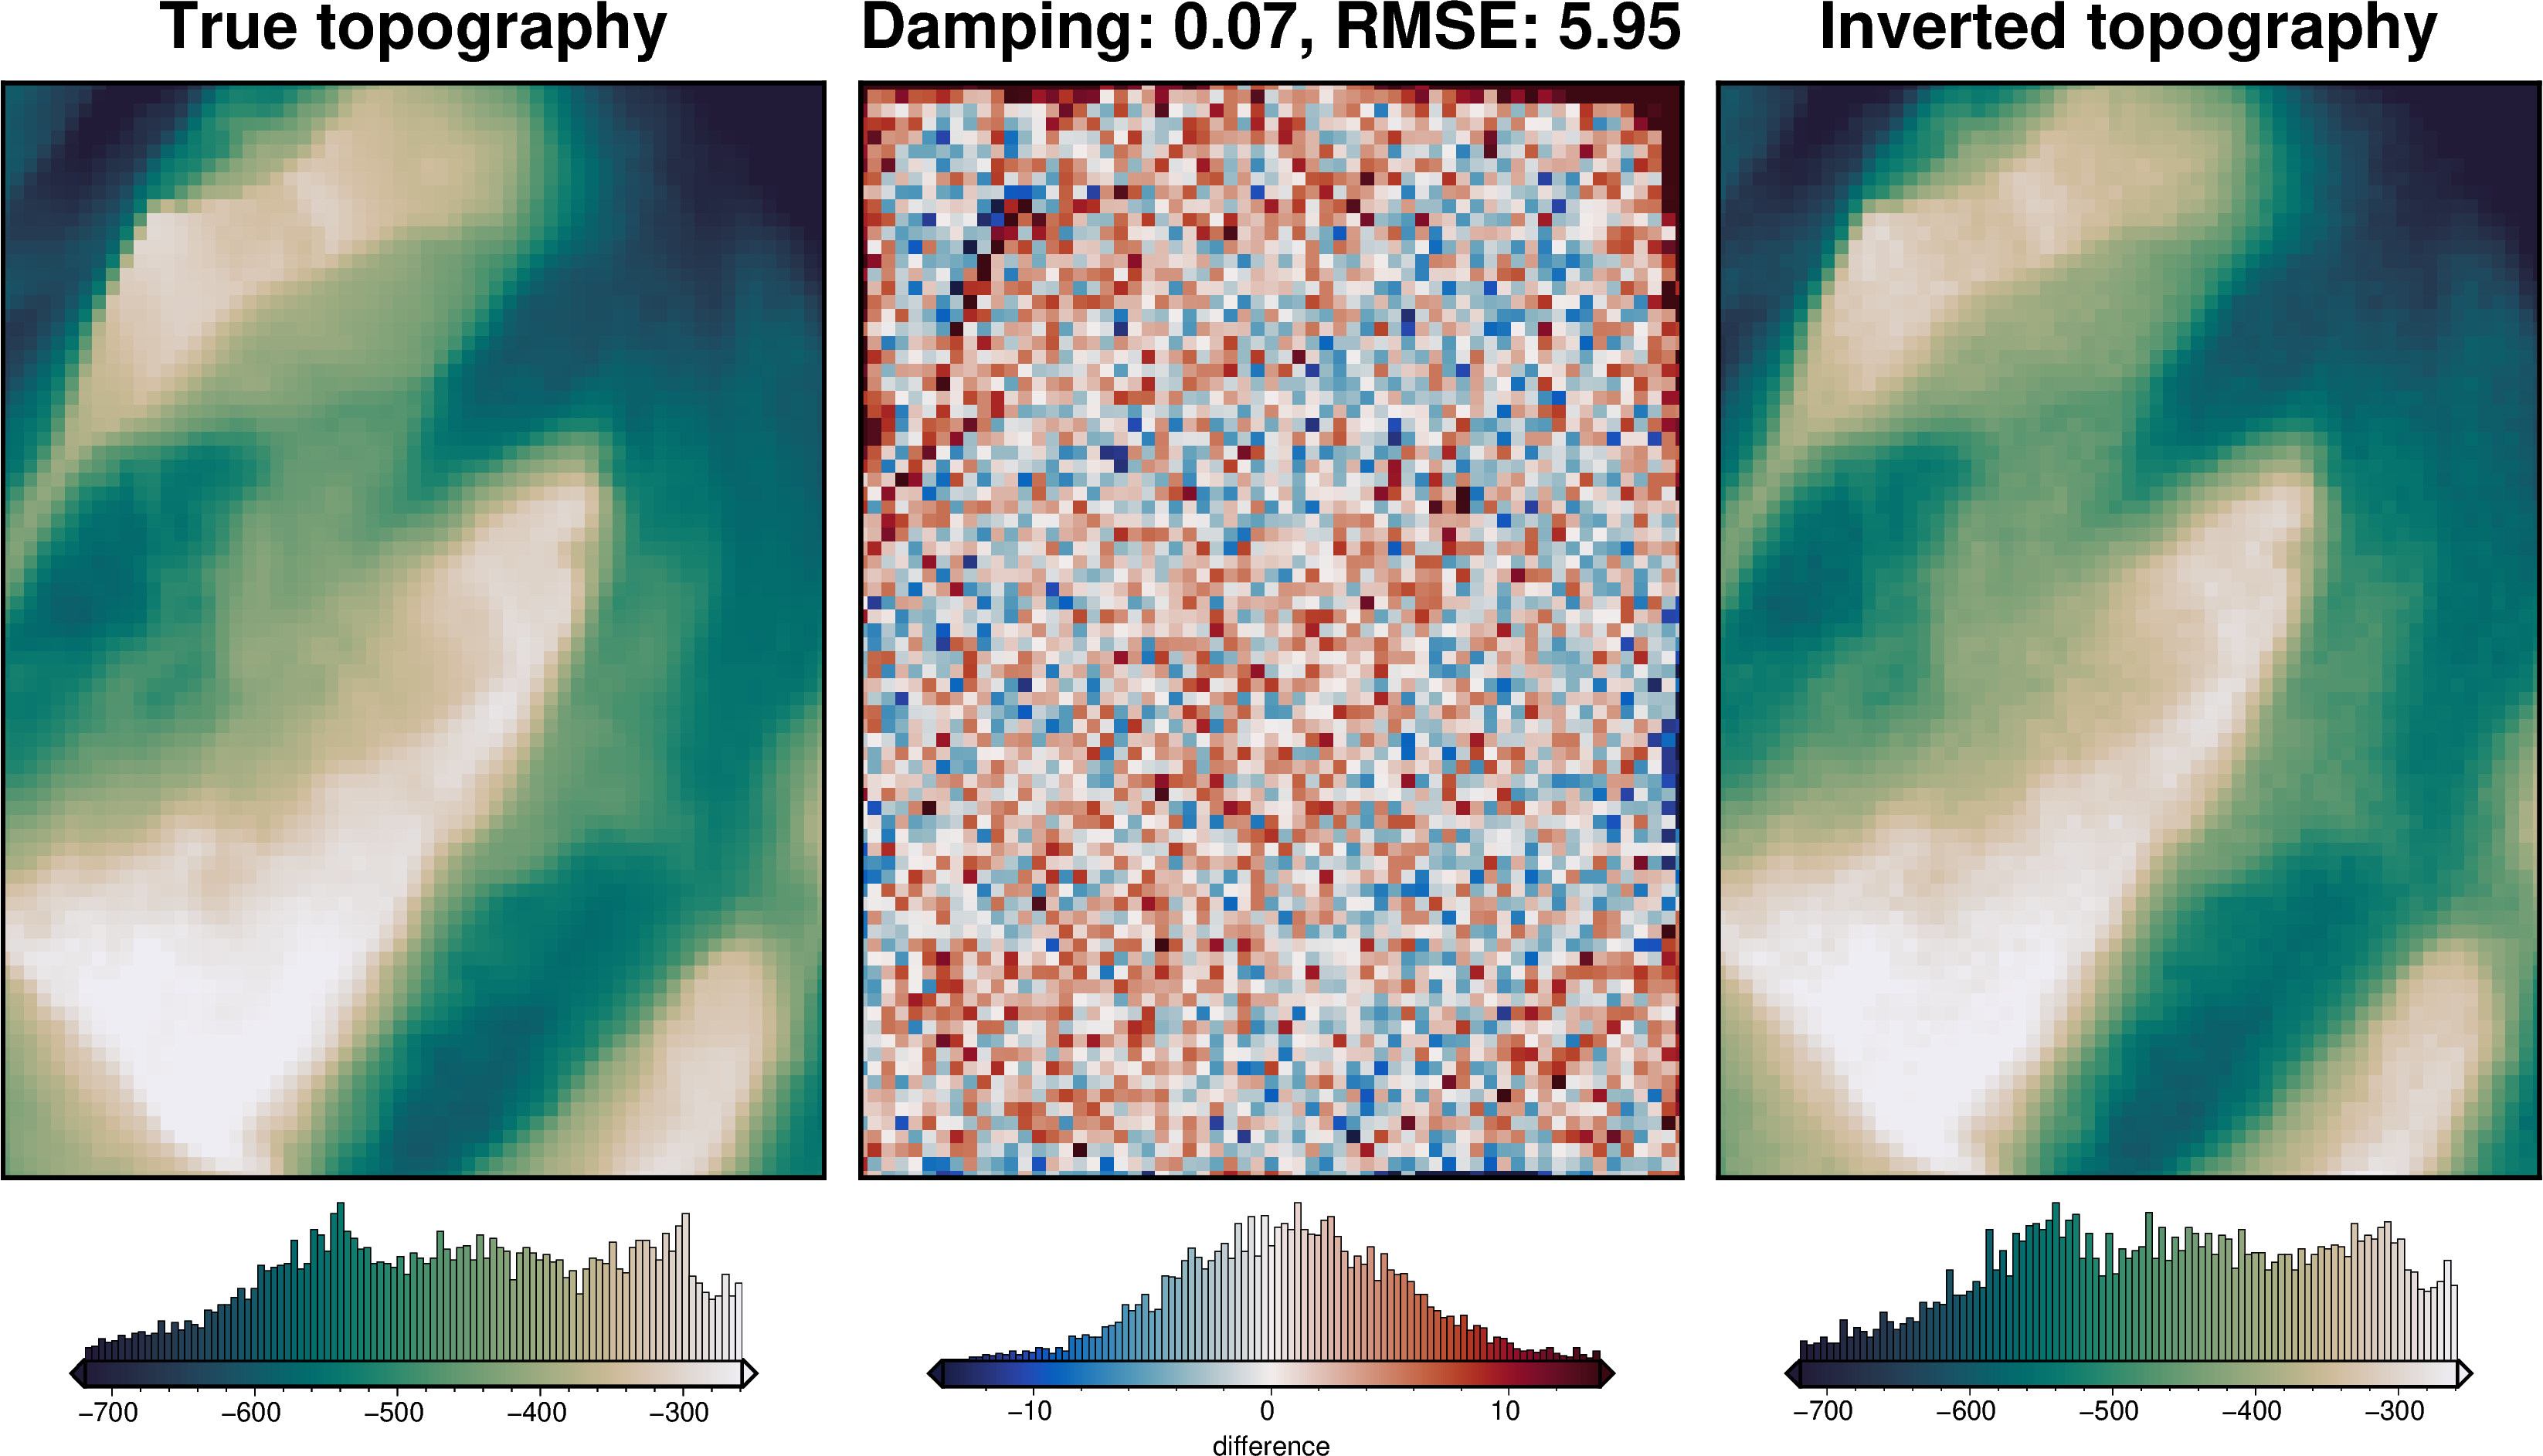

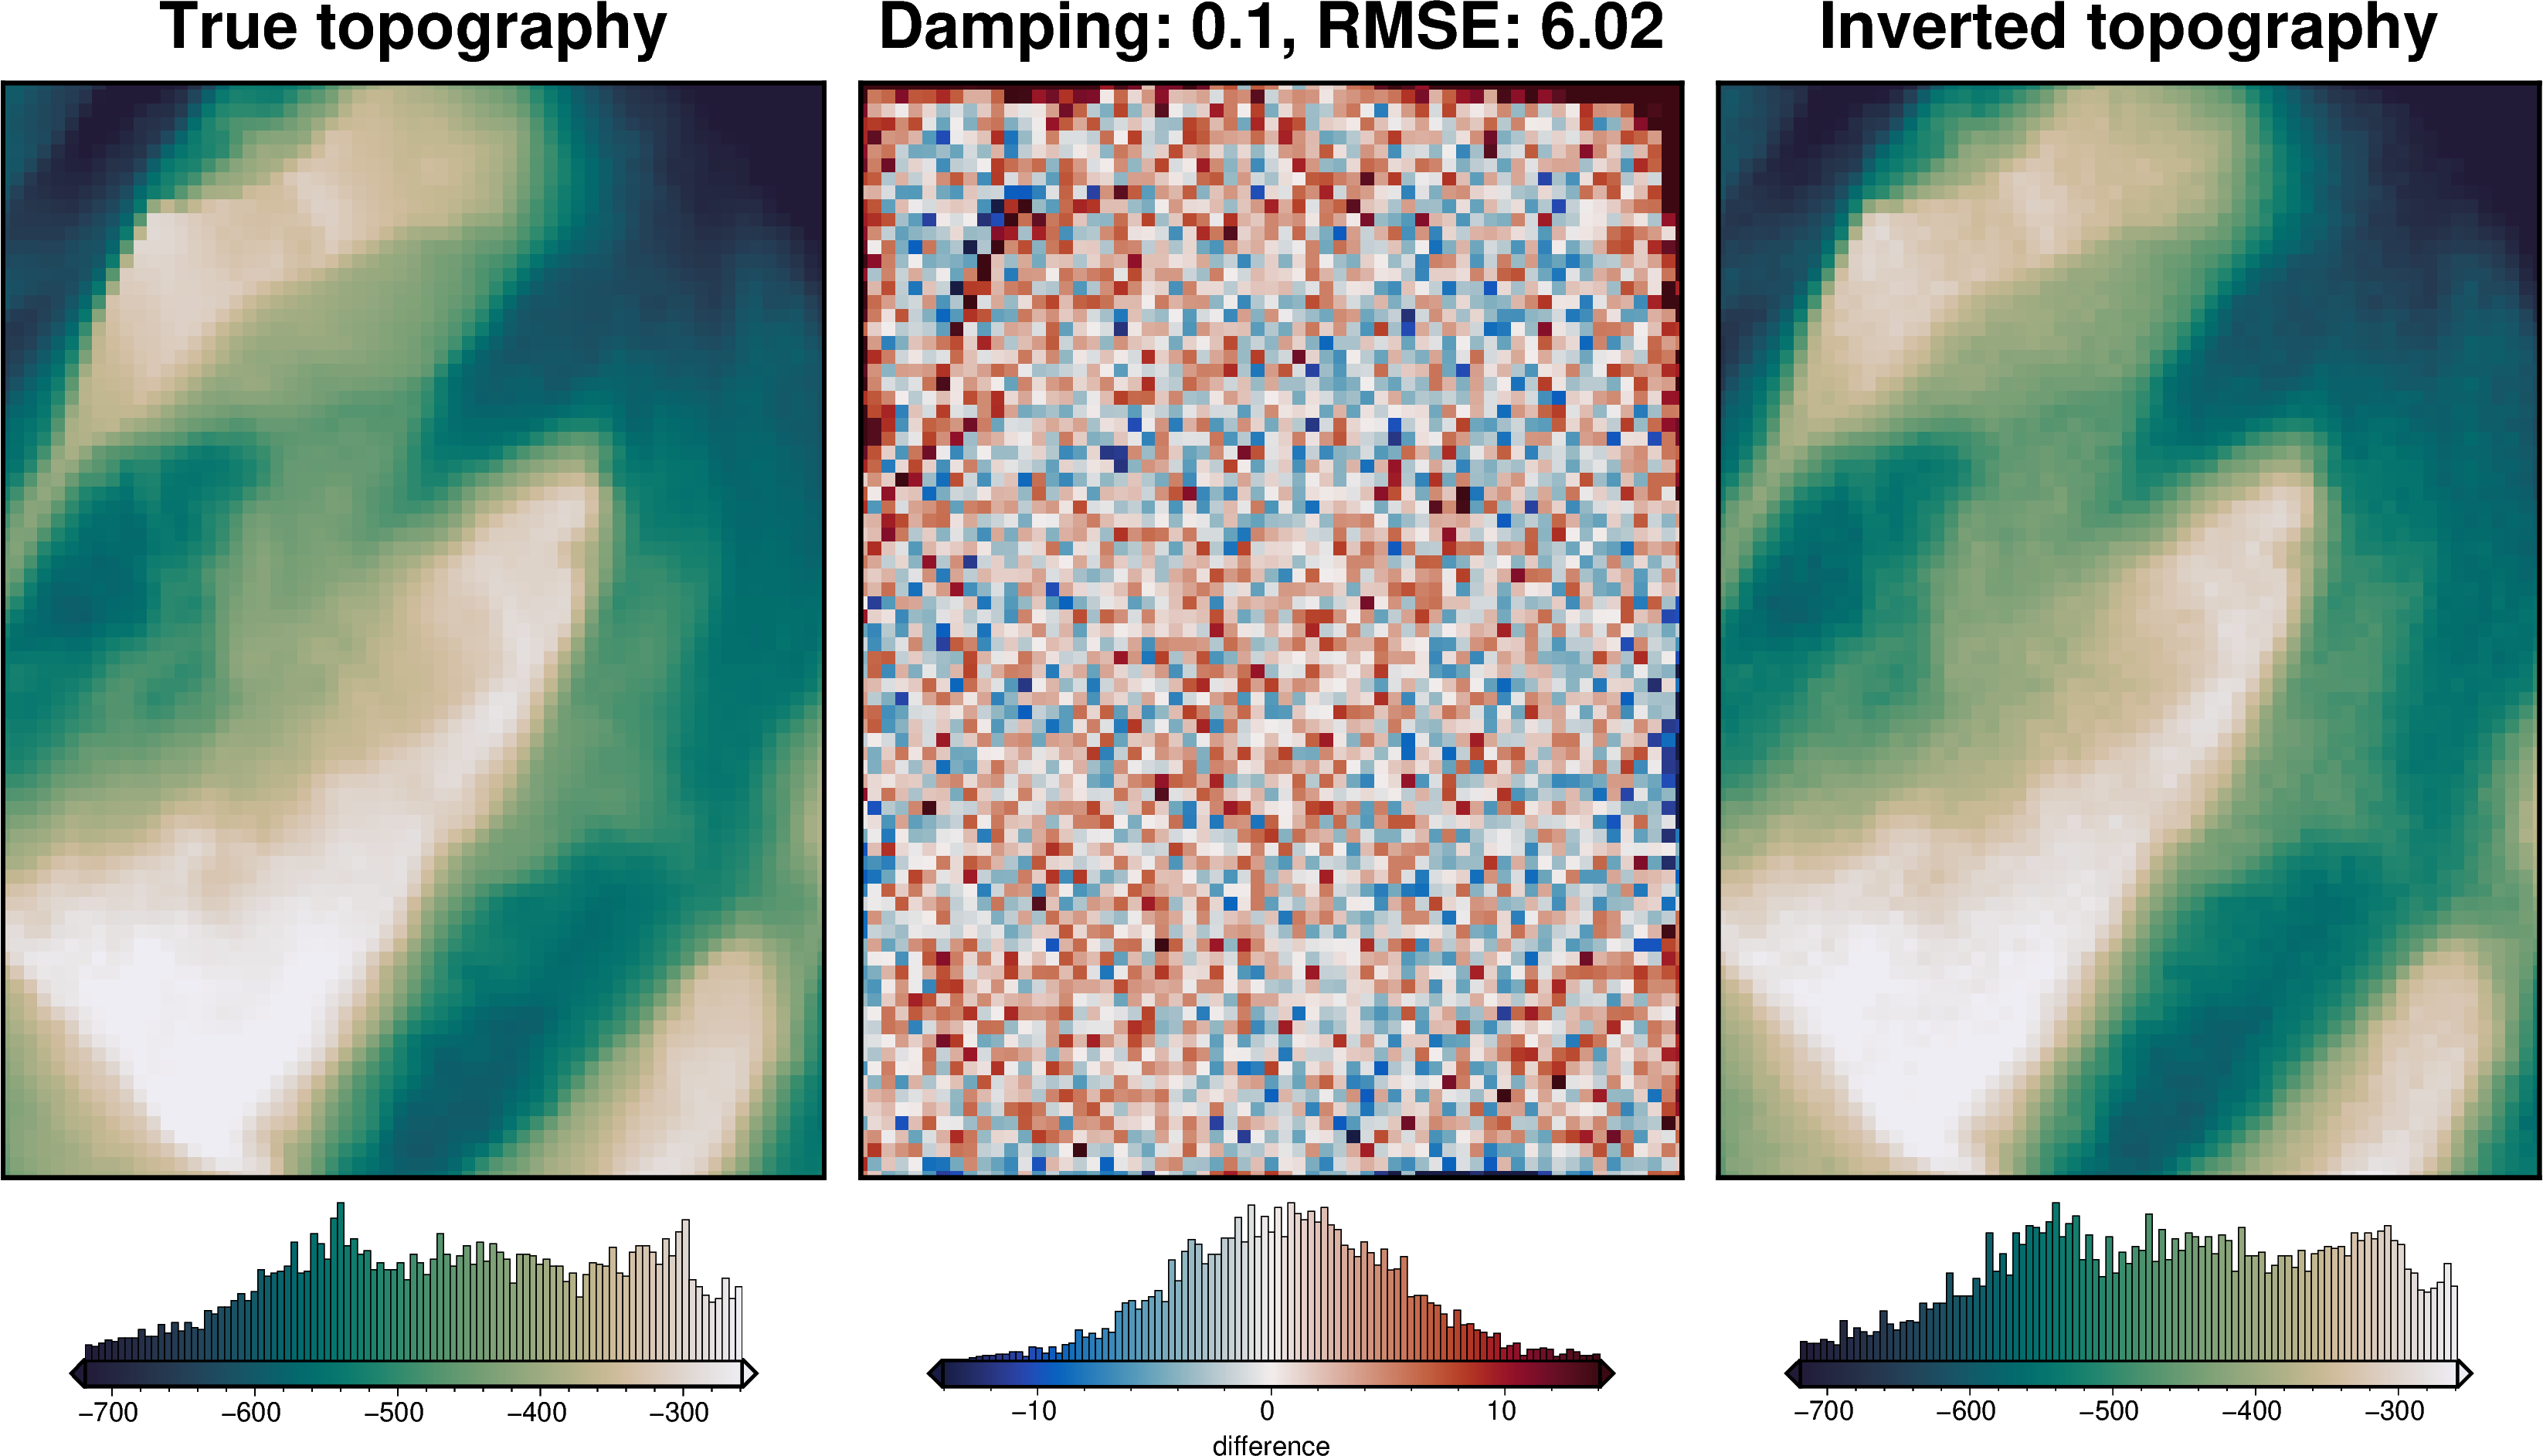

In [91]:
dampings = [
    (t.params["damping"], t.user_attrs["results"][0]) for t in study.get_trials()
]
dampings = sorted(dampings, key=lambda x: x[0])

for damp, df in dampings:
    final_topography = df.set_index(["northing", "easting"]).to_xarray().topo

    _ = polar_utils.grd_compare(
        bathymetry,
        final_topography,
        region=inversion_region,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title=f"Damping: {round(damp,3)}",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
    )

In [83]:
# # sample the inverted topography at the constraint points
# constraint_points = utils.sample_grids(
#     constraint_points,
#     final_topography,
#     "inverted_topography",
#     coord_names=("easting", "northing"),
# )

# rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
# print(f"RMSE: {rmse:.2f} m")

# No info on density

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_no_regional_with_starting'
INFO:invert4geom:running zref and/or density contrast cross validation


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 9
INFO:invert4geom:	parameter: {'density_contrast': 1469.7918445687803}
INFO:invert4geom:	scores: [21.880050149777333]


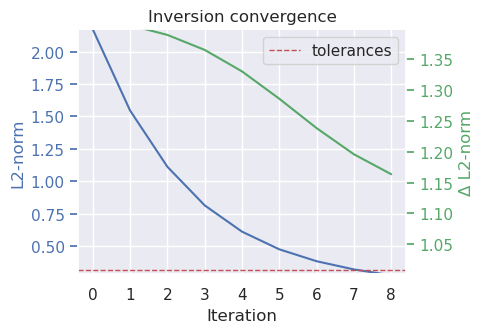

INFO:invert4geom:results saved to ../../results/Ross_Sea_no_regional_with_starting_results.pickle


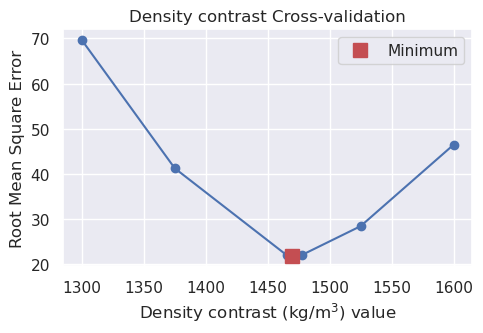

In [64]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=best_damping,
    starting_topography=starting_bathymetry,
    starting_prisms=starting_prisms,
    zref= 0,
    calculate_regional_misfit=True,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    run_zref_or_density_cv=True,
    constraints_df=constraint_points,
    density_contrast_limits=(1300, 1600),
    zref_density_cv_trials=10,
    plot_cv=True,
    fname="../../results/Ross_Sea_no_regional_with_starting",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [65]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_no_regional_with_starting_results.pickle").open("rb") as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [66]:
best_density_contrast = float(parameters.get("Density contrast(s)")[1:-7])
best_density_contrast

1469.79184457

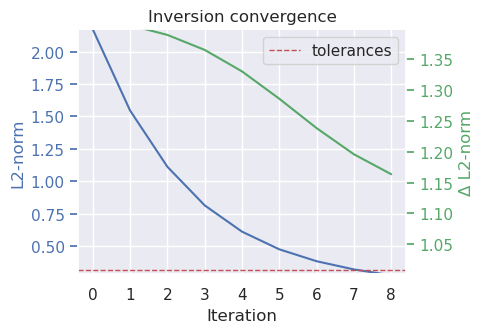

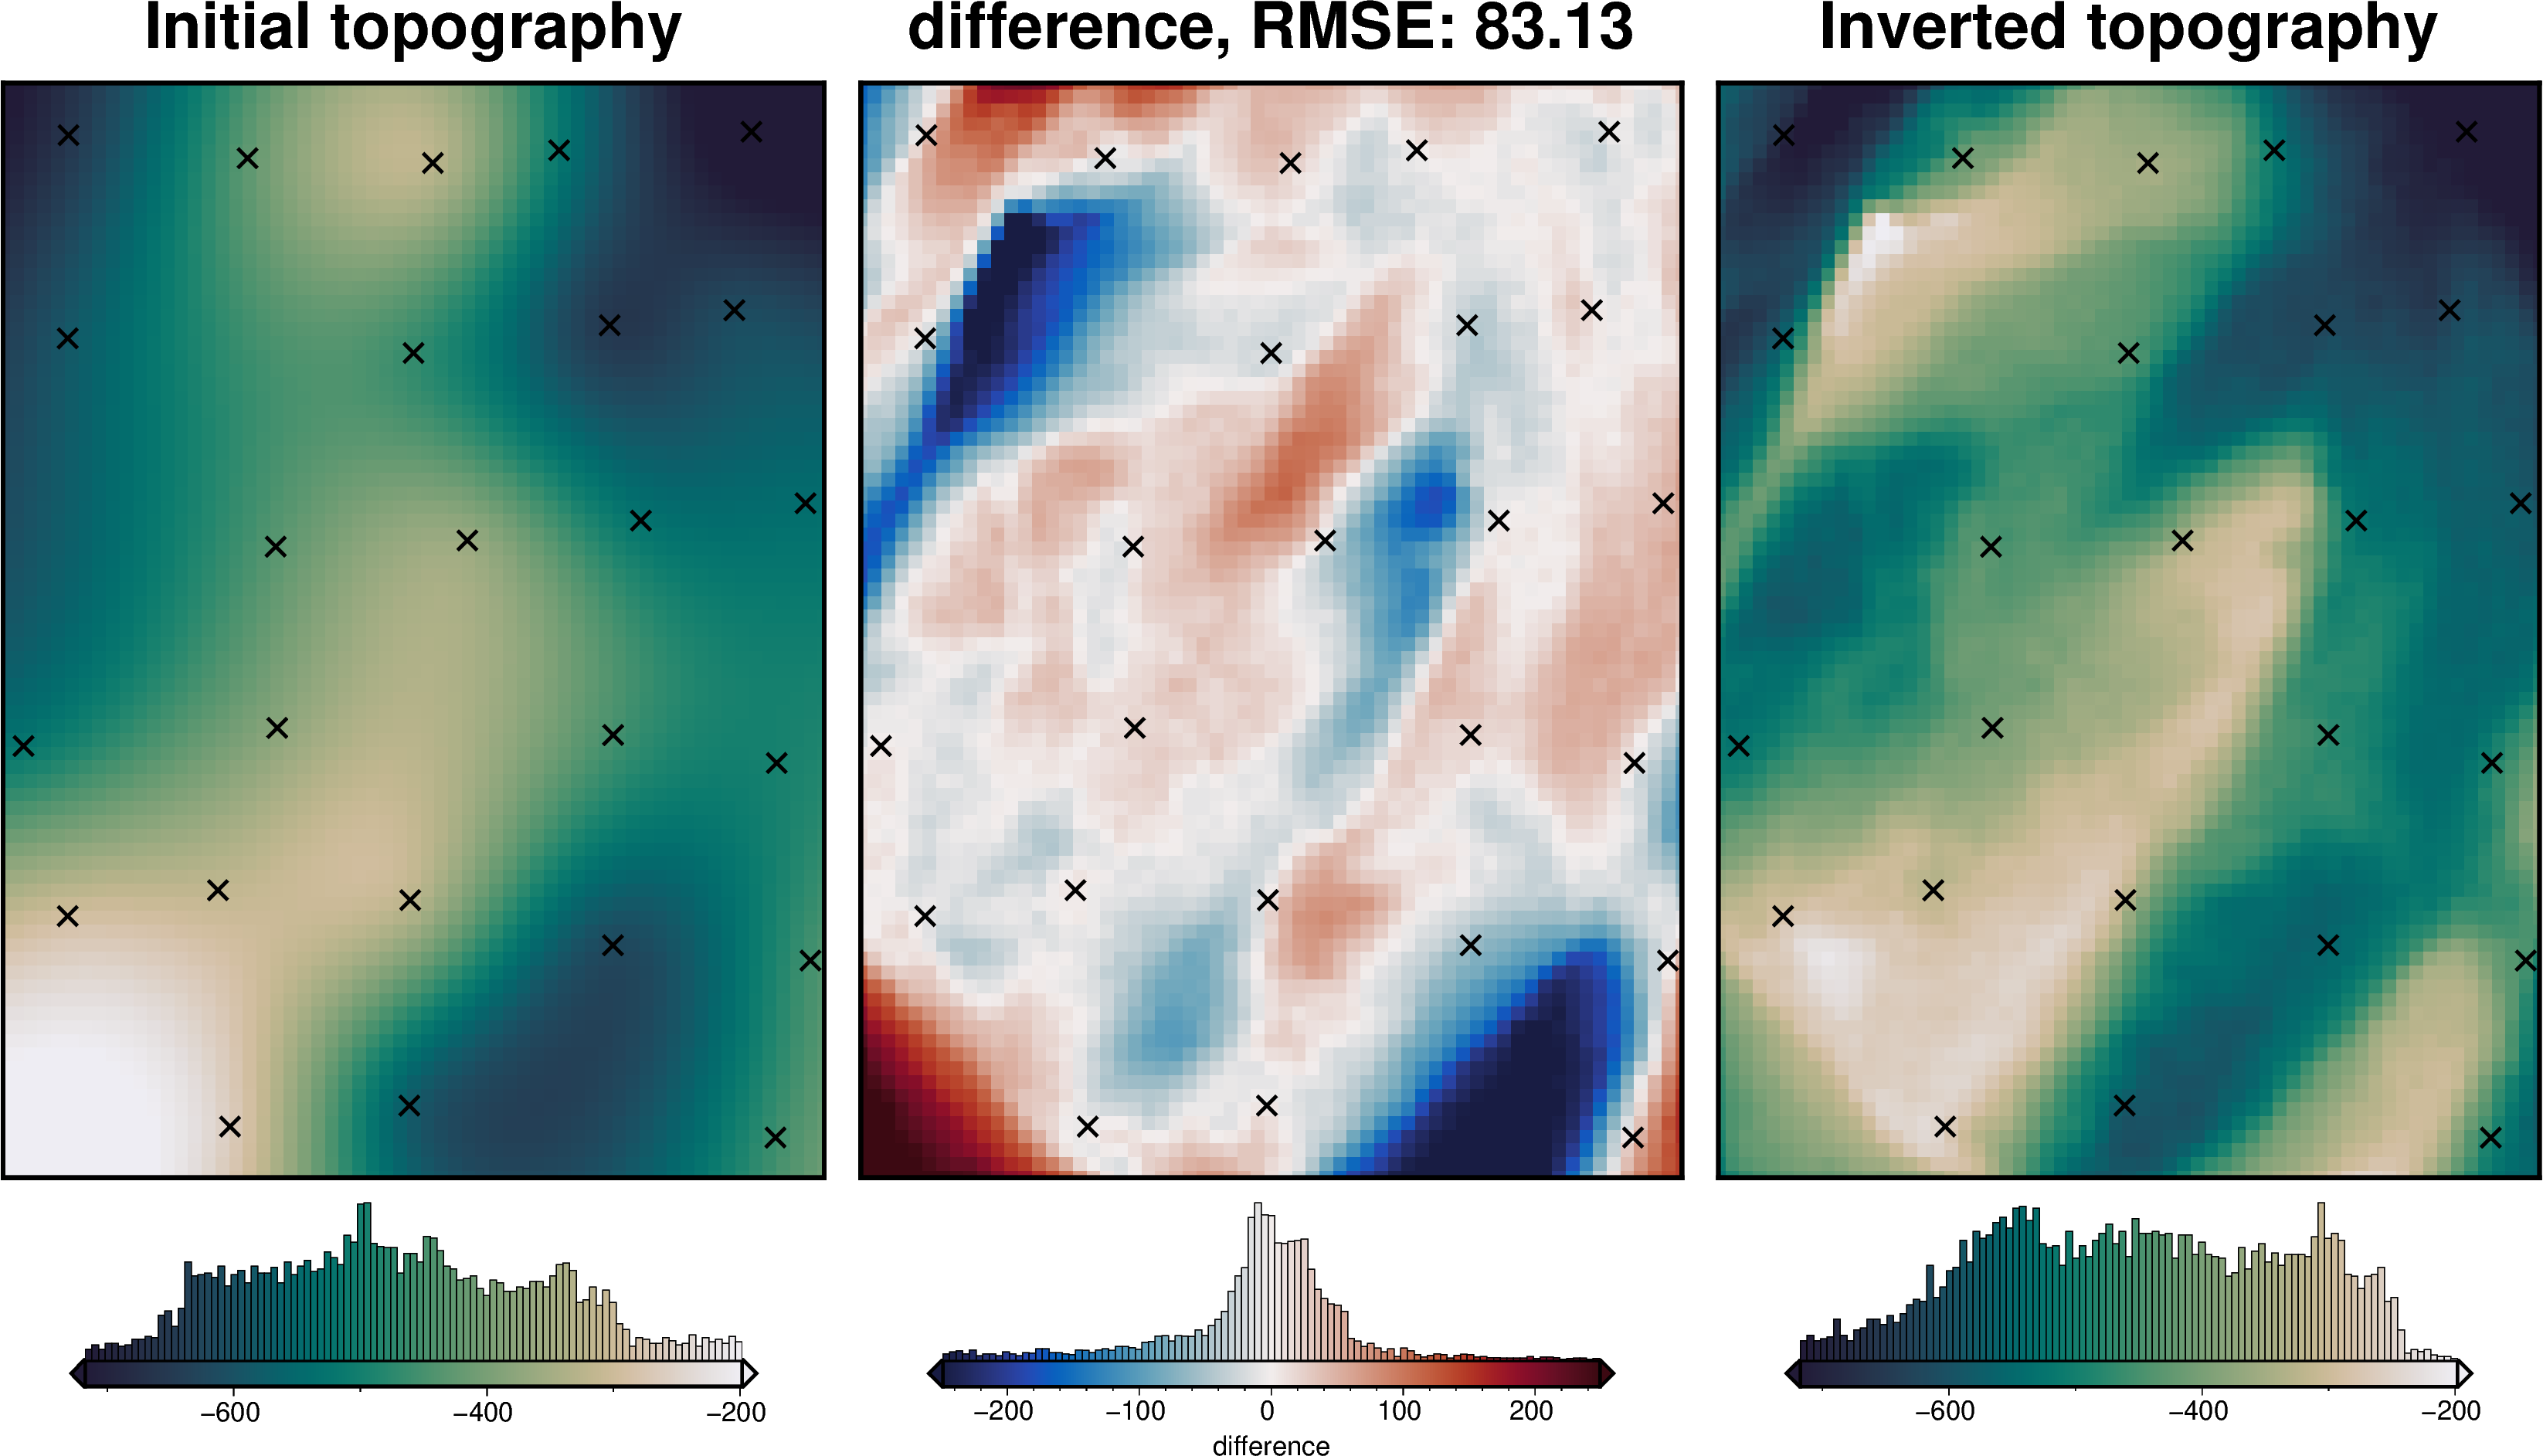

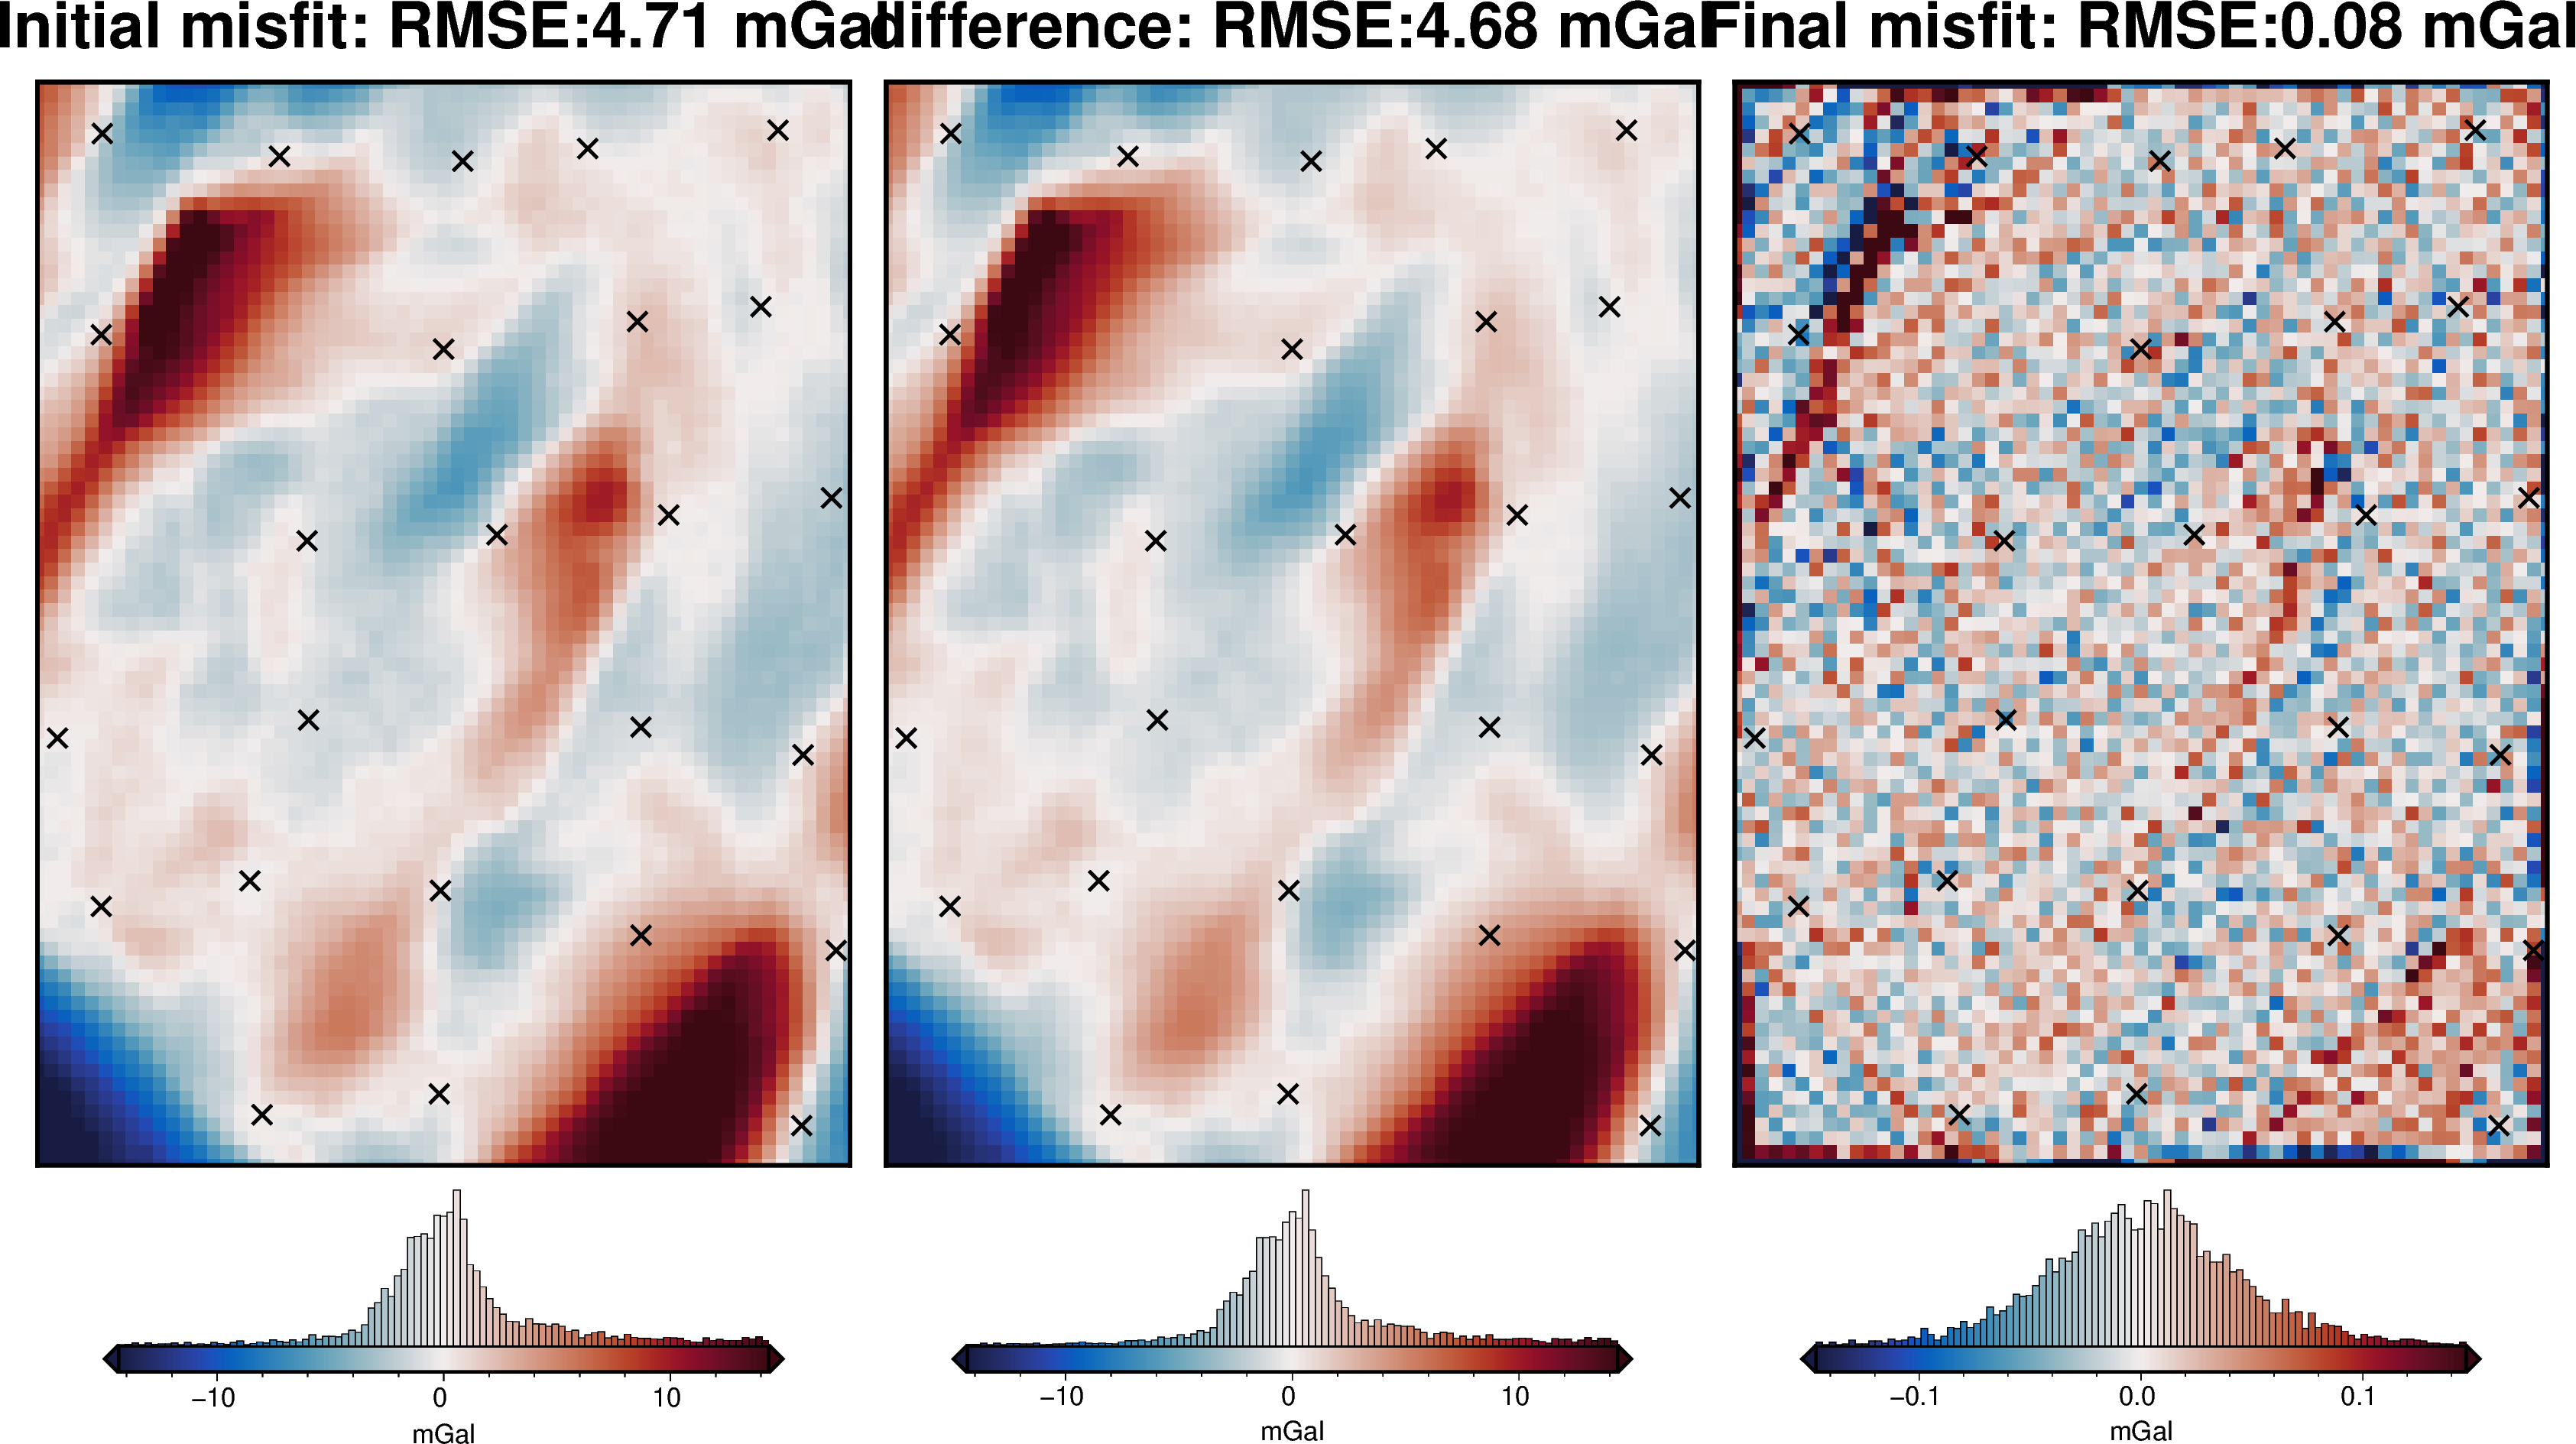

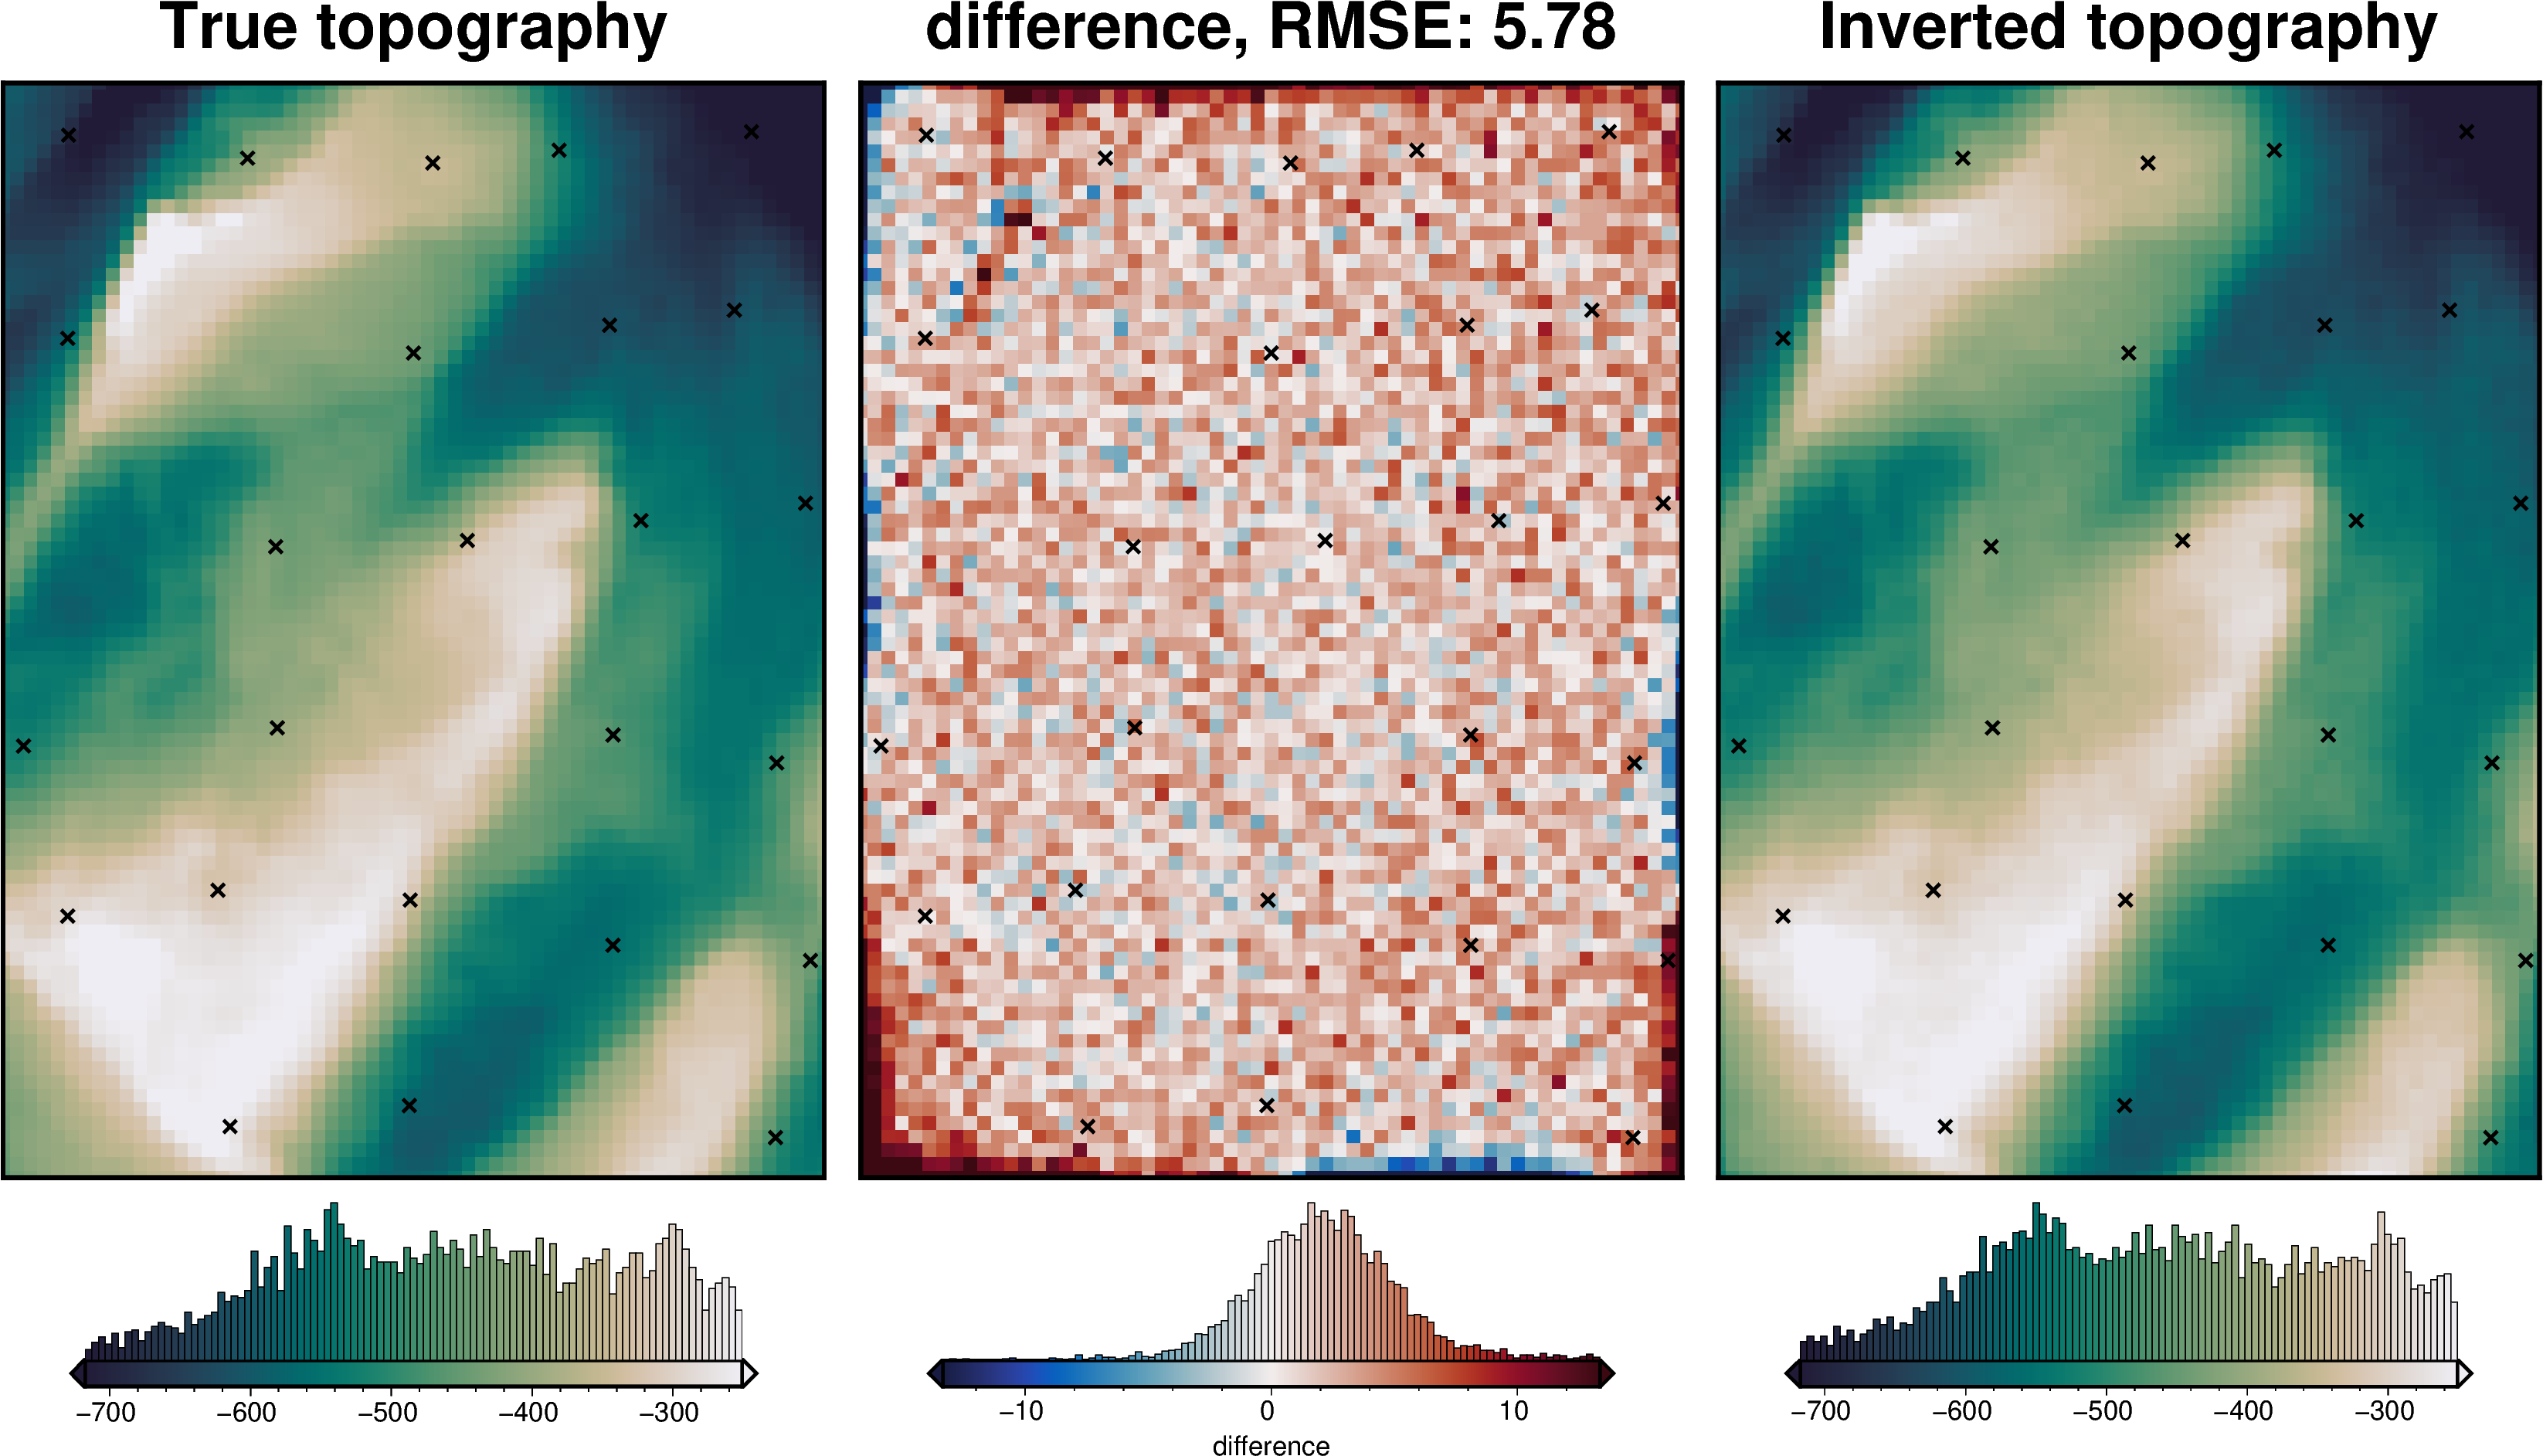

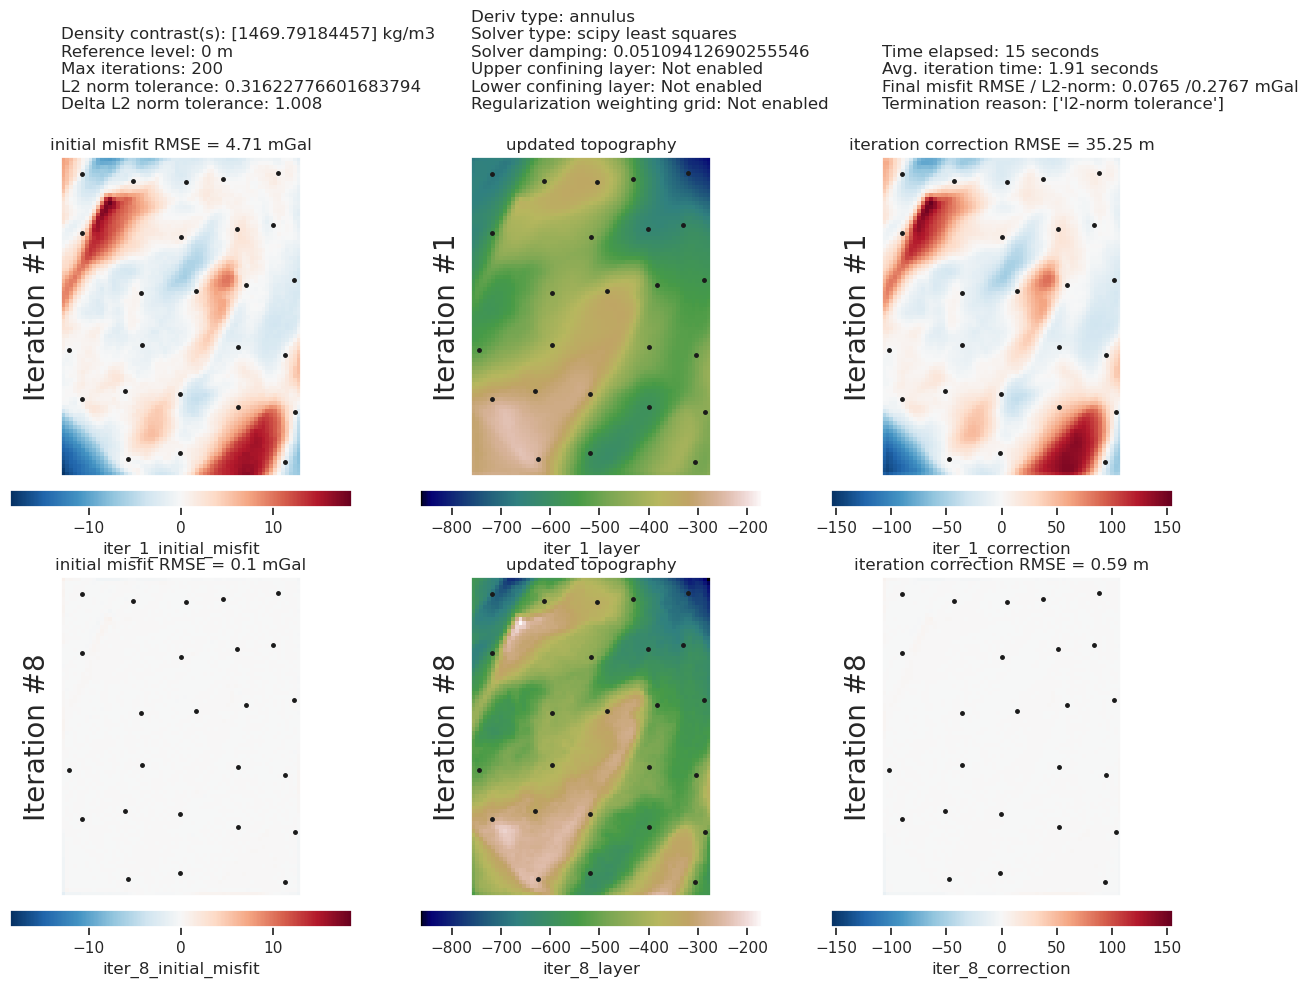

In [67]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints_df=constraint_points,
    constraint_size=5,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    points_pen="1p",
)

In [68]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 21.88 m


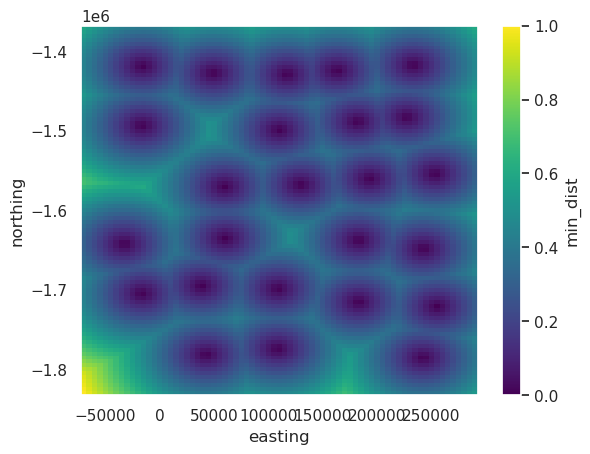

In [82]:
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_bathymetry,
    low=0,
    high=1,
)
weighting_grid.plot()

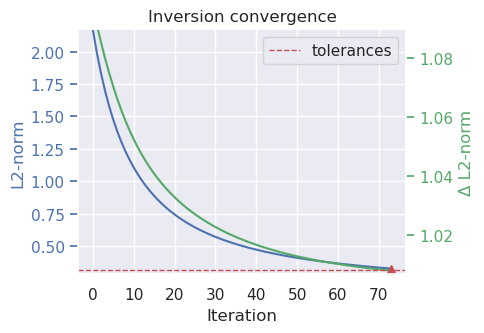

In [83]:
# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=best_damping,
    starting_topography=starting_bathymetry,
    create_starting_prisms=True,
    zref= 0,
    density_contrast=best_density_contrast,
    calculate_regional_misfit=True,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    plot_dynamic_convergence=True,
    fname="../../results/Ross_Sea_no_regional_with_starting_weighting",
    # enable the use of weights
    apply_weighting_grid=True,
    weighting_grid=weighting_grid,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

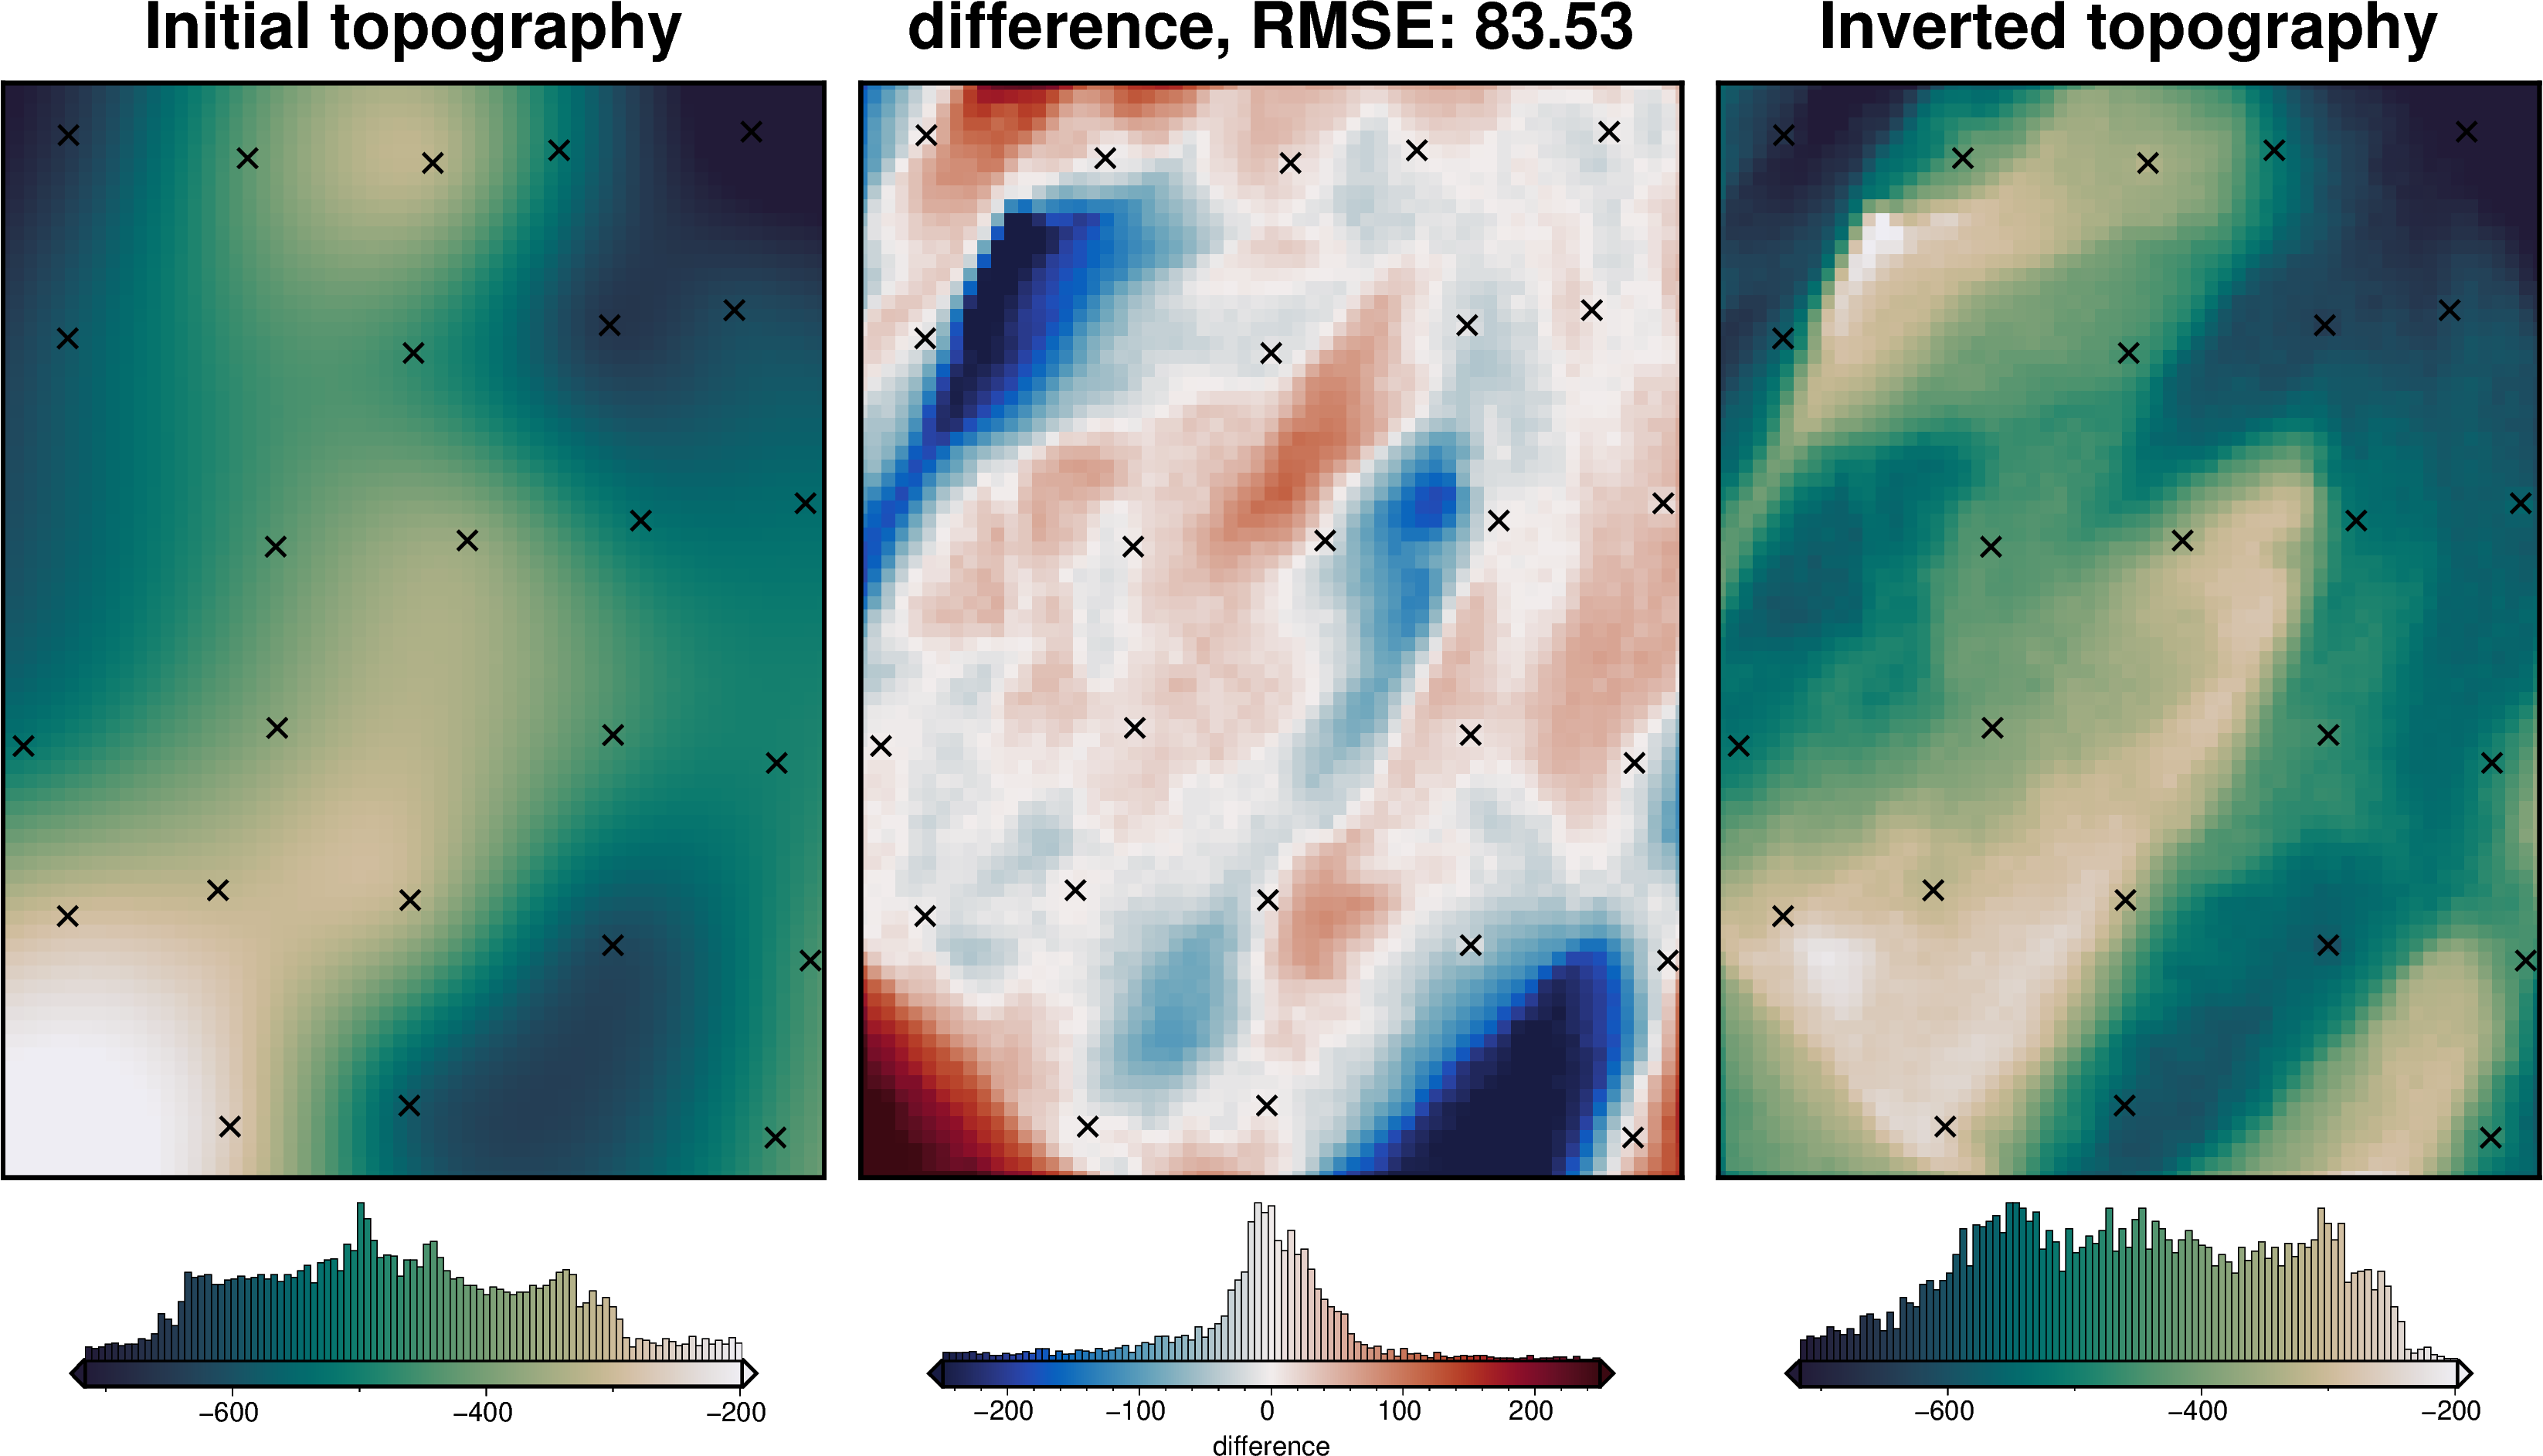

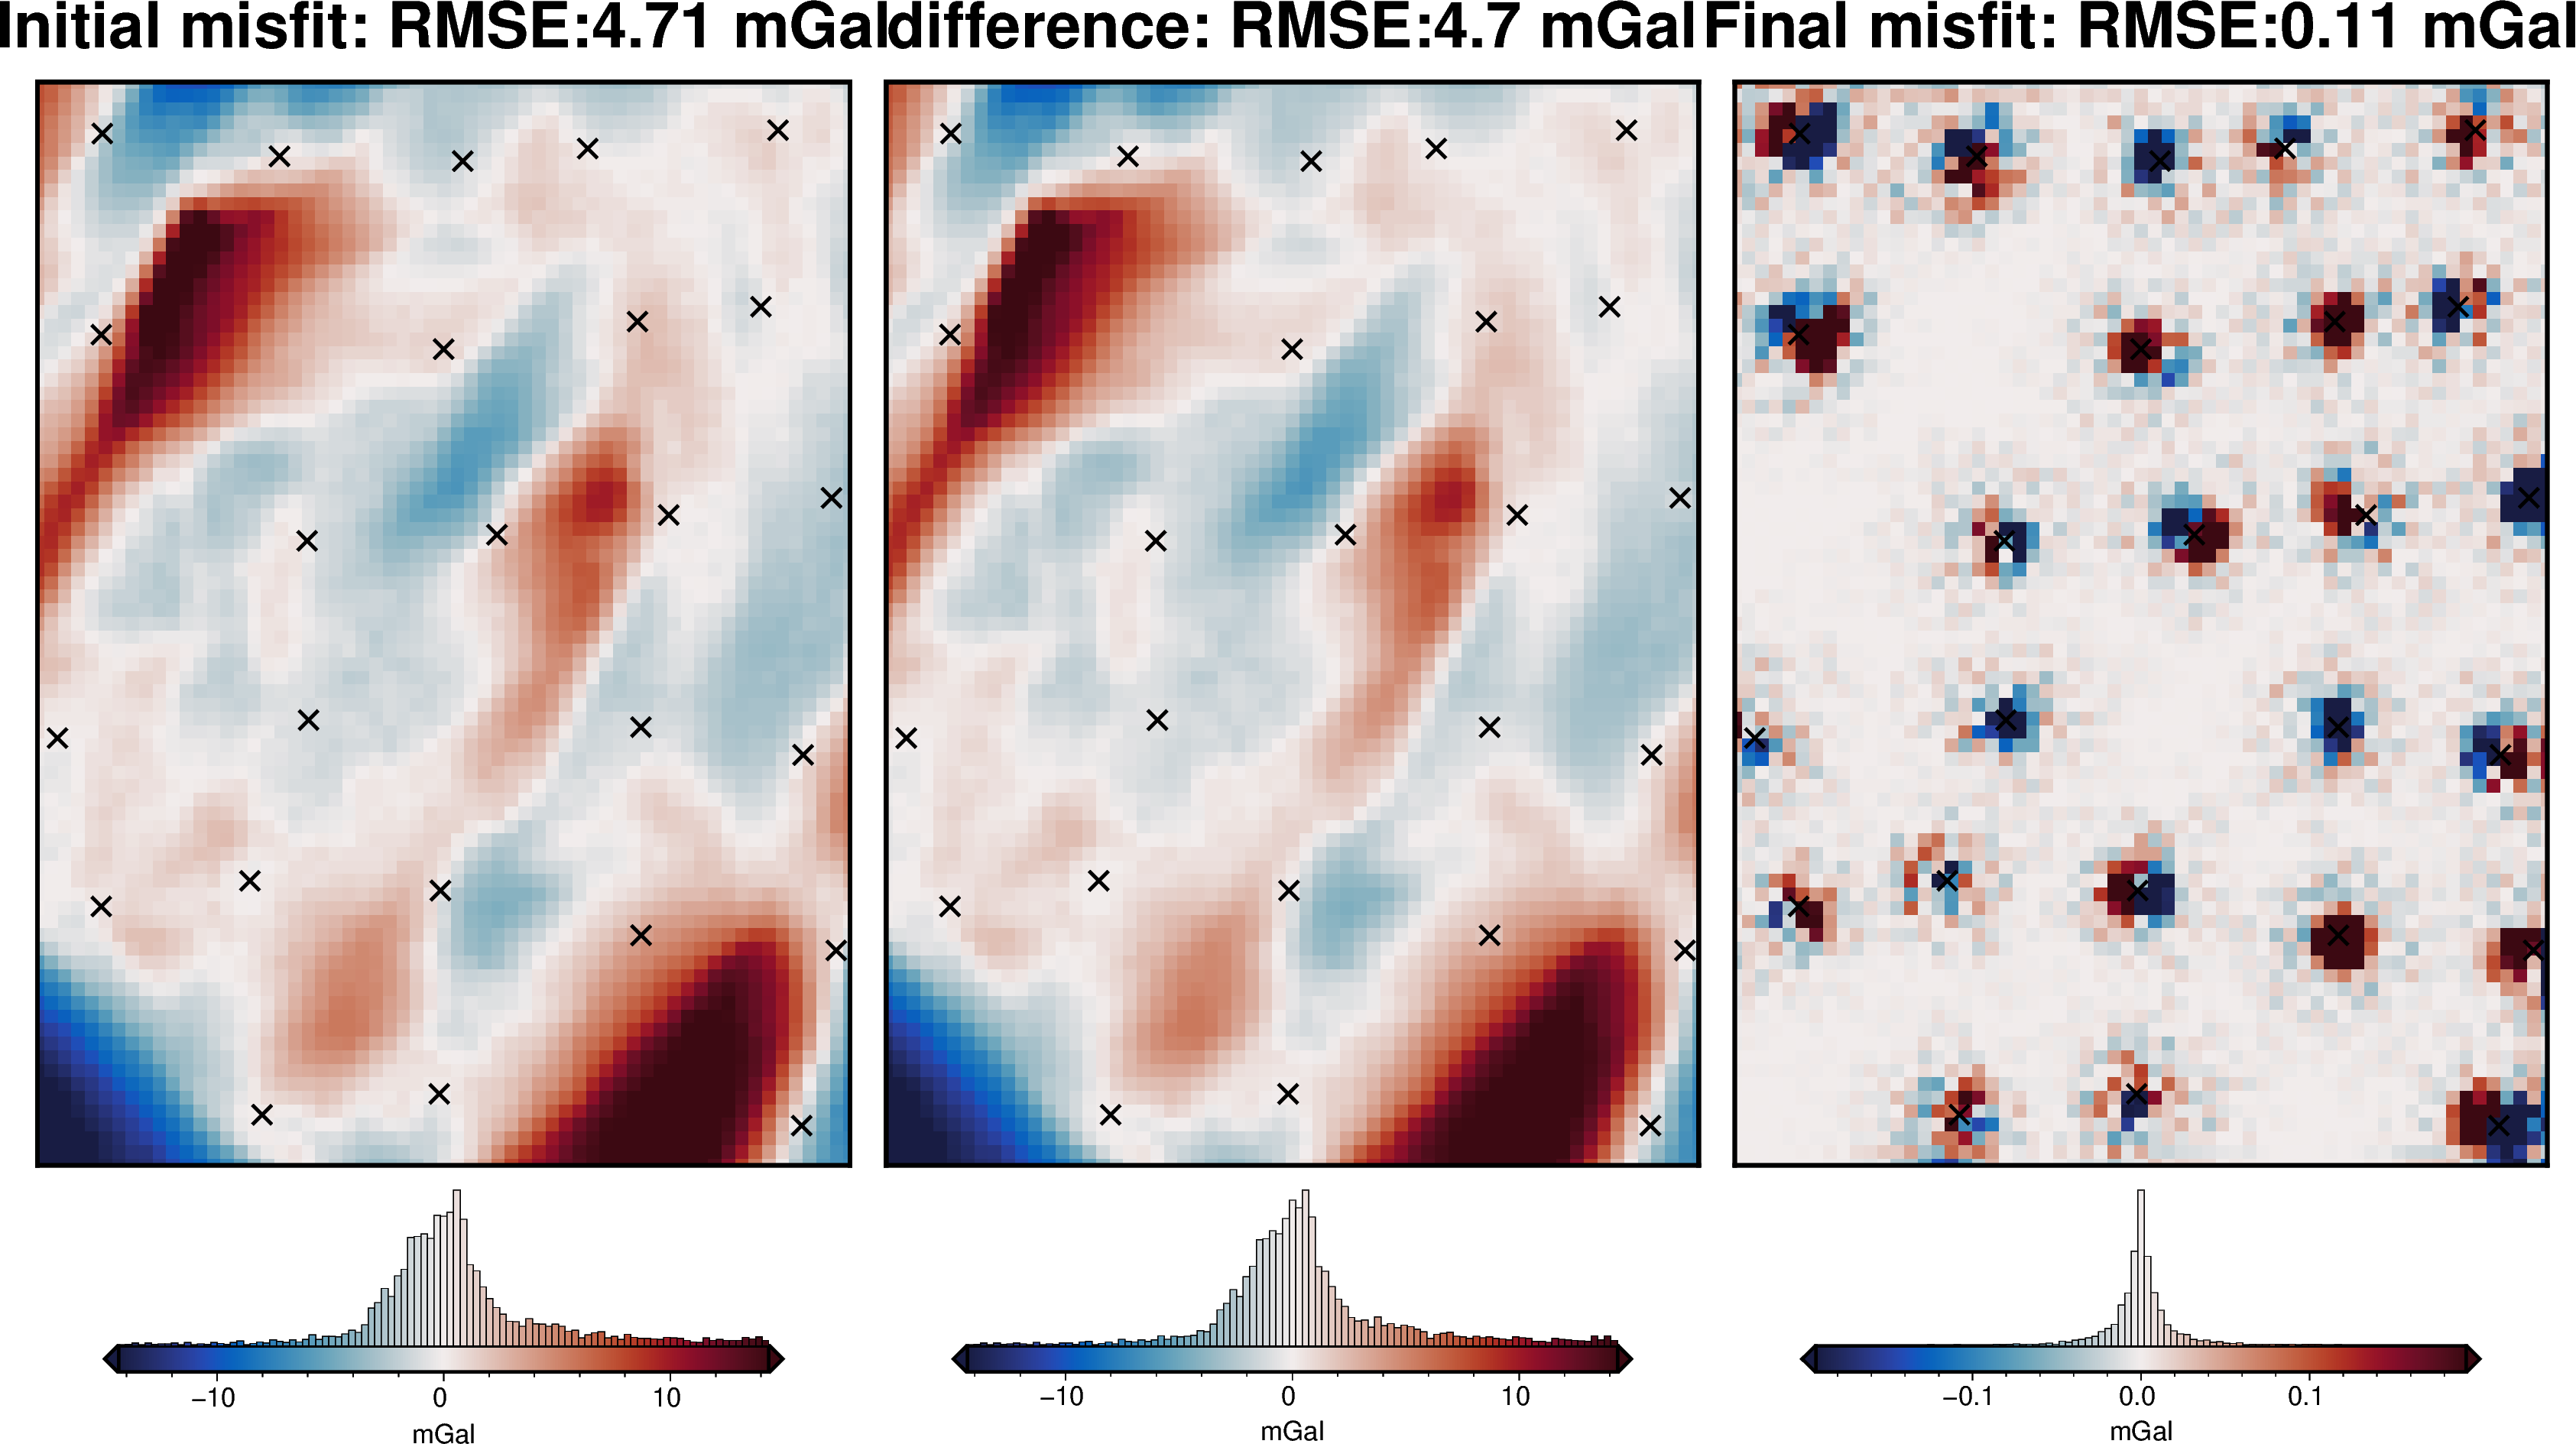

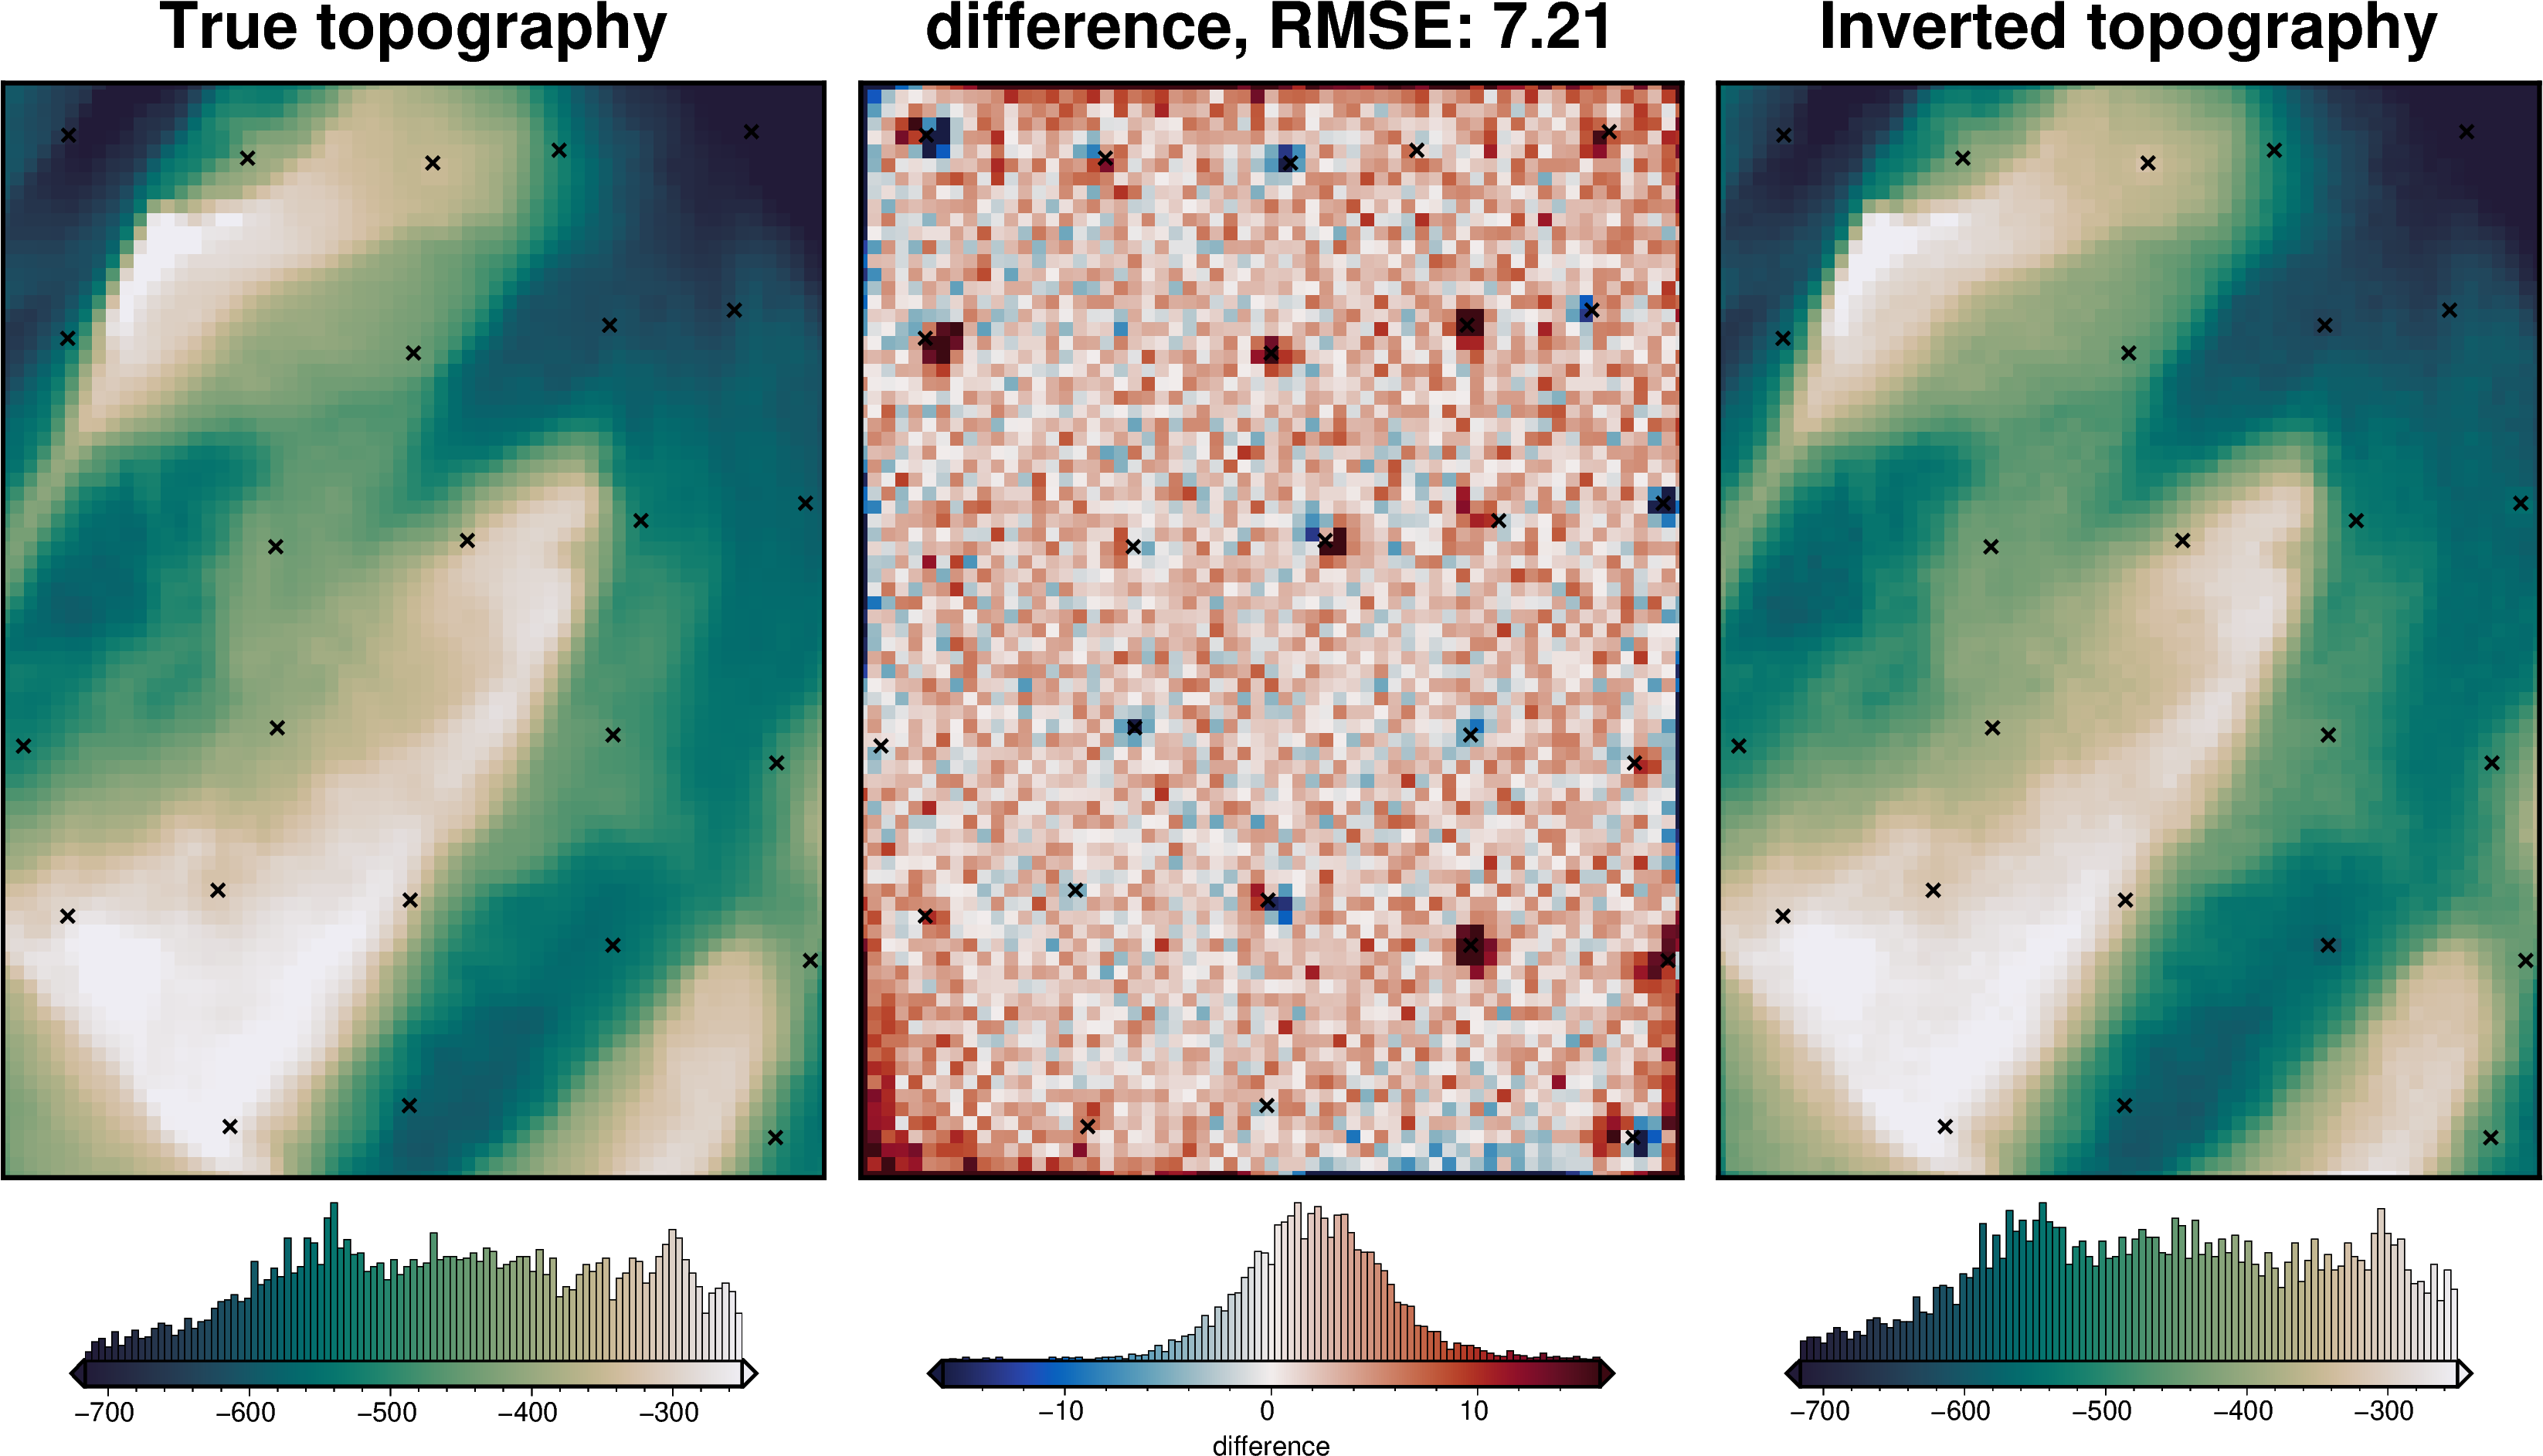

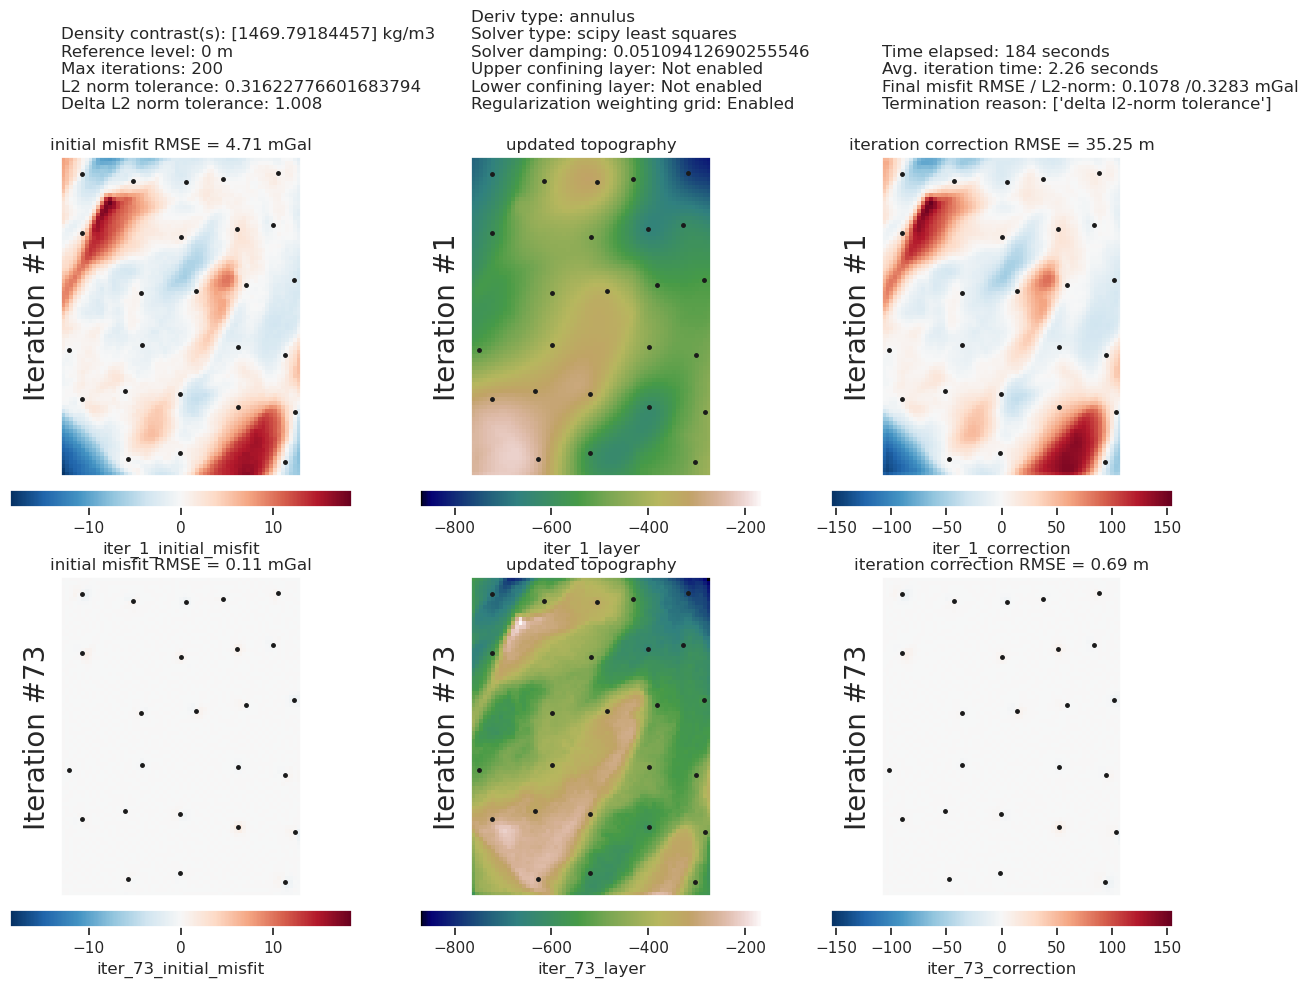

In [84]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints_df=constraint_points,
    constraint_size=5,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
    points_pen="1p",
)

In [85]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 5.88 m
